In [1]:
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import numpy as np

from latex import latexify
latexify(columns=2)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [12]:
def model1_competition(P, t, r, C):
    """
    Lotka-Volterra competition model.
    P = [P1, P2, P3] (current populations)
    t = time
    r = [r1, r2, r3] (intrinsic growth rates)
    C = carrying capacity
    """
    
    # Unpack populations
    P1, P2, P3 = P
    
    # Calculate total population
    N = P1 + P2 + P3
    
    # Calculate the competition term (logistic factor)
    # Use max(0, ...) to prevent negative growth if N > C
    logistic_term = max(0, (1 - N / C))
    
    # Calculate dP/dt for each species
    dP1_dt = r[0] * P1 * logistic_term
    dP2_dt = r[1] * P2 * logistic_term
    dP3_dt = r[2] * P3 * logistic_term
    
    return [dP1_dt, dP2_dt, dP3_dt]

In [13]:
r = [0.3, 0.5, 0.8]  # r1, r2, r3
C = 1000.0           # Carrying capacity
P0 = [10.0, 10.0, 10.0] # Initial populations [P1, P2, P3]

# 3. Set up Time
t = np.linspace(0, 50, 500) # Time from 0 to 50

# 4. Solve the ODE
solution = odeint(model1_competition, P0, t, args=(r, C))

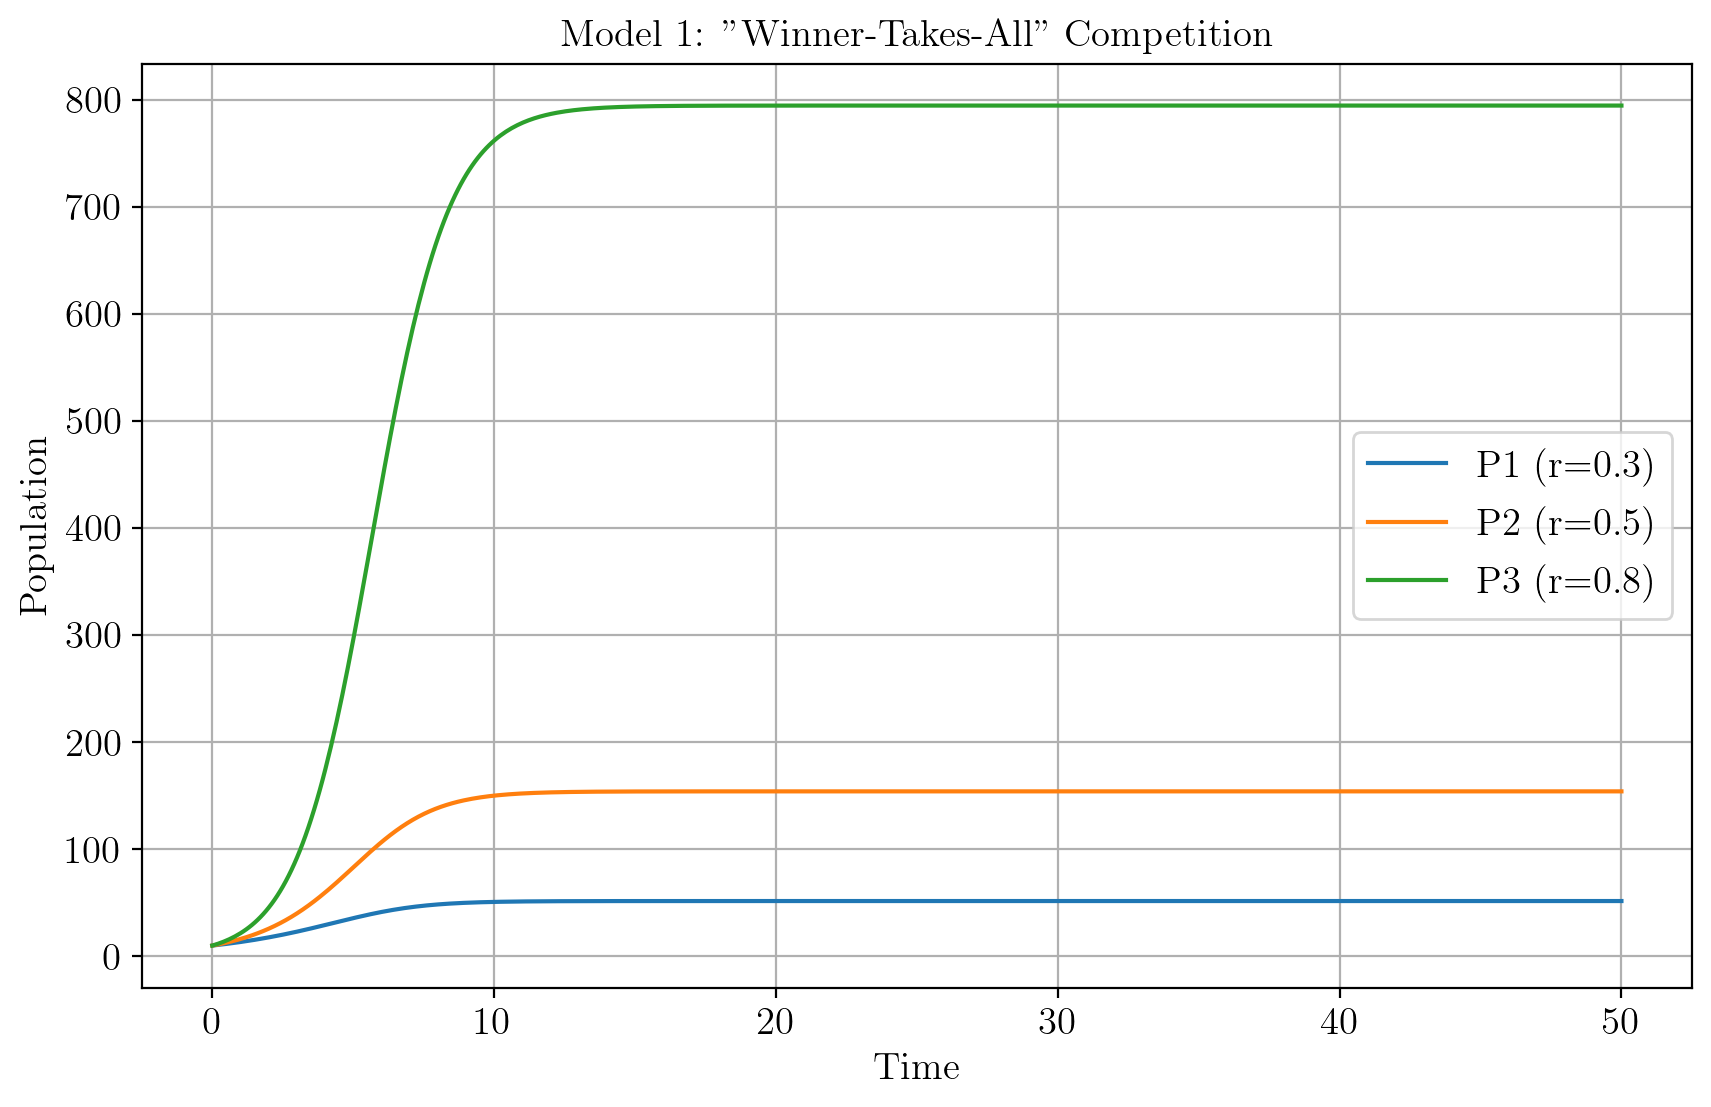

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(t, solution[:, 0], label='P1 (r=0.3)')
plt.plot(t, solution[:, 1], label='P2 (r=0.5)')
plt.plot(t, solution[:, 2], label='P3 (r=0.8)')
plt.title('Model 1: "Winner-Takes-All" Competition')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
def model2_evolution(P, t, R, D, M, C):
    """
    Evolutionary network model (quasispecies).
    P = [P1, P2, P3] (current populations)
    t = time
    R = [R1, R2, R3] (replication rates)
    D = [D1, D2, D3] (death rates)
    M = [M1, M2] (mutation rates P1->P2, P2->P3)
    C = carrying capacity
    """
    
    # Unpack populations
    P1, P2, P3 = P
    
    # Calculate total population
    N = P1 + P2 + P3
    
    # Calculate the resource-limited replication term
    logistic_term = max(0, (1 - N / C))
    
    # --- Calculate dP/dt for each species ---
    
    # P1: Gains from perfect copies, loses to death
    dP1_dt = P1 * R[0] * (1 - M[0]) * logistic_term - P1 * D[0]
    
    # P2: Gains from perfect copies AND P1 mutations, loses to death
    gain_P2_perfect = P2 * R[1] * (1 - M[1]) * logistic_term
    gain_P2_mutation = P1 * R[0] * M[0] * logistic_term
    loss_P2_death = P2 * D[1]
    dP2_dt = gain_P2_perfect + gain_P2_mutation - loss_P2_death
    
    # P3: Gains from perfect copies (M3=0) AND P2 mutations, loses to death
    gain_P3_perfect = P3 * R[2] * logistic_term # Assumes M3=0
    gain_P3_mutation = P2 * R[1] * M[1] * logistic_term
    loss_P3_death = P3 * D[2]
    dP3_dt = gain_P3_perfect + gain_P3_mutation - loss_P3_death
    
    return [dP1_dt, dP2_dt, dP3_dt]

In [16]:
R = [0.5, 0.8, 1.2]  # R1, R2, R3
D = [0.1, 0.1, 0.1]  # D1, D2, D3
M = [0.05, 0.05]      # M1 (P1->P2), M2 (P2->P3)
C = 1000.0           # Carrying capacity
P0 = [10.0, 0.0, 0.0]  # Initial populations [P1, P2, P3]

# 3. Set up Time
t = np.linspace(0, 100, 1000) # Time from 0 to 100 (needs longer)

# 4. Solve the ODE
solution = odeint(model2_evolution, P0, t, args=(R, D, M, C))

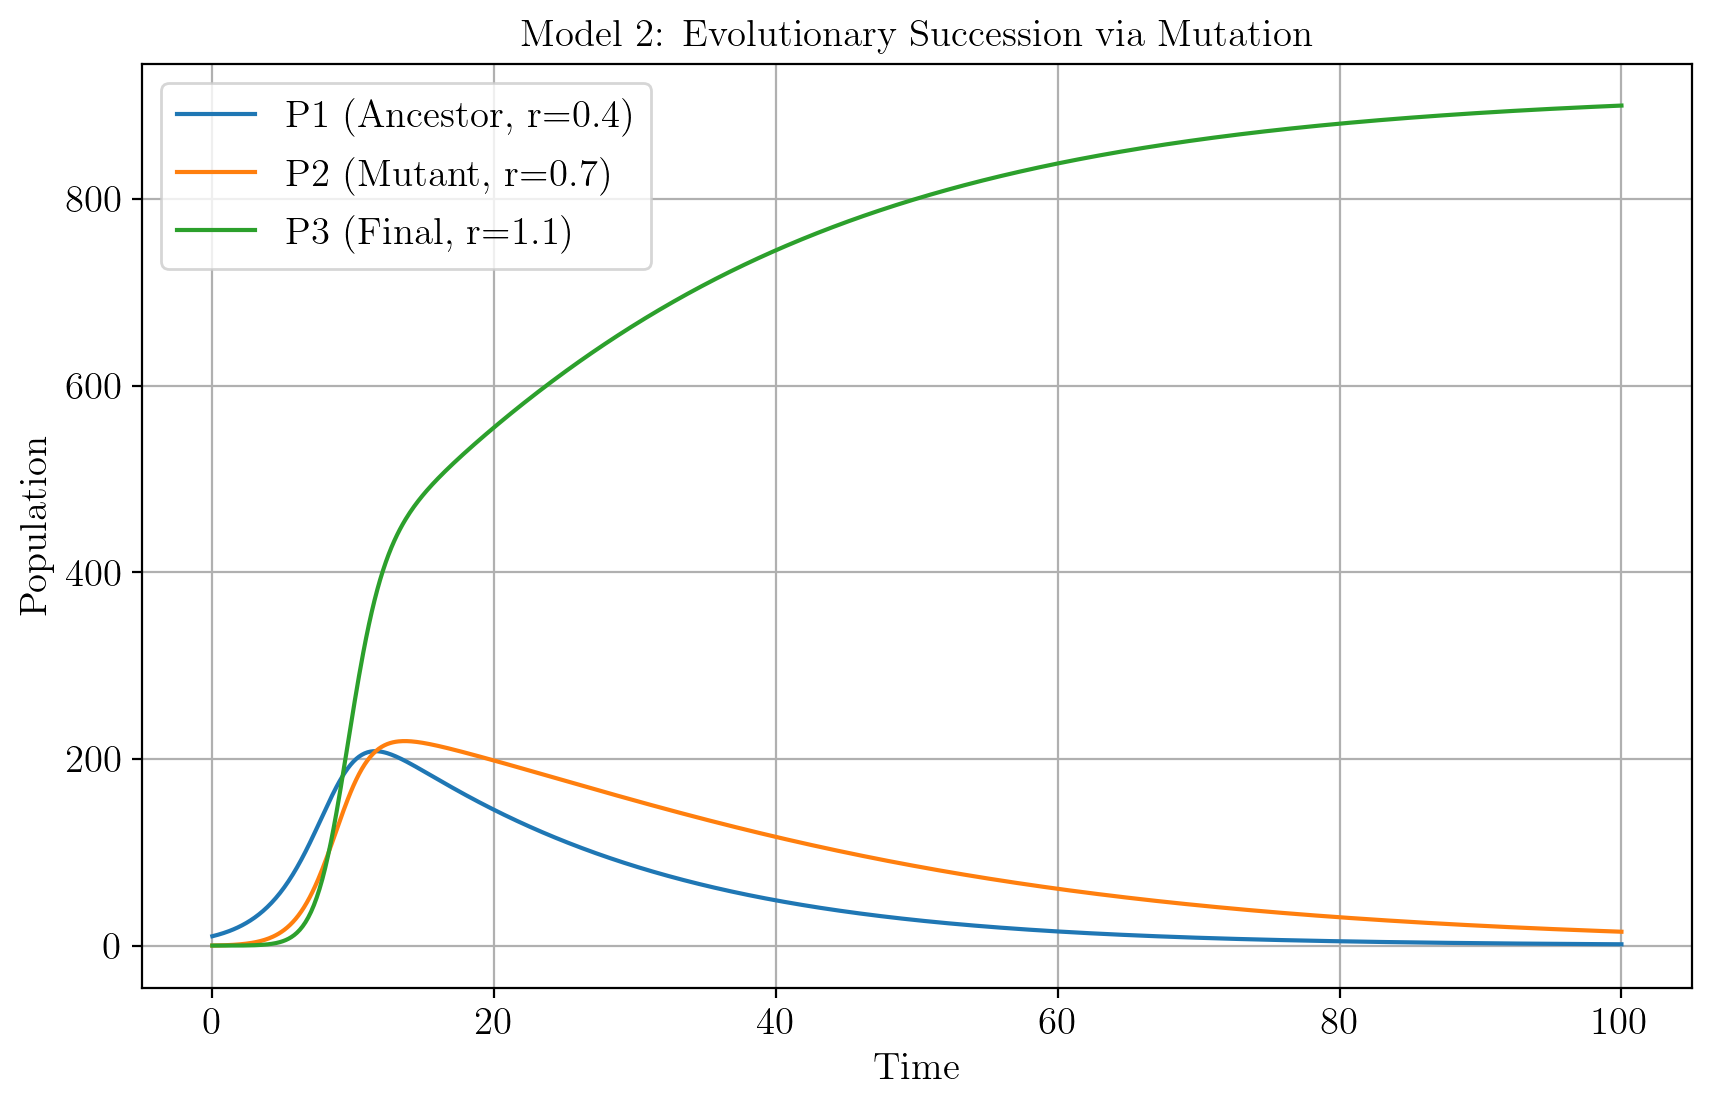

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(t, solution[:, 0], label='P1 (Ancestor, r=0.4)')
plt.plot(t, solution[:, 1], label='P2 (Mutant, r=0.7)')
plt.plot(t, solution[:, 2], label='P3 (Final, r=1.1)')
plt.title('Model 2: Evolutionary Succession via Mutation')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.grid(True)
plt.show()

### 3.6 Expected Results & Interpretation

**Key Observations**:
1. **Photostationary State**: During daylight, the system reaches a quasi-equilibrium where d[O$_3$]/dt ≈ 0
2. **Ozone Limitation**: In this simple model, ozone cannot accumulate significantly because NO immediately titrates it back to NO₂
3. **Diurnal Pattern**: Concentrations oscillate with solar radiation
4. **Conservation**: [NO] + [O₃] remains approximately constant (nitrogen conservation)

**Physical Insight**: This model shows the **basic photochemical cycle** but cannot explain high ozone episodes because it lacks the crucial ingredient: **VOCs (hydrocarbons)**. This motivates Model 2!

---

## **MODEL 2: Generic Reaction Set (GRS) - 7 Reactions**

### 4.1 Motivation
The simple cycle cannot produce net ozone. We need to include **Reactive Organic Compounds (ROCs)** that create radicals, which oxidize NO to NO₂ *without consuming ozone*.

### 4.2 Reaction Mechanism (from Document 1, Section 10.1.2)

This is the **GRS mechanism** - a simplified yet effective representation:
```
(R1) ROC + hν → RP                  (radical production, k₁)
(R2) RP + NO → NO₂                  (NO oxidation, k₂)
(R3) NO₂ + hν → NO + O              (photolysis, k$_3$)
(R4) O + O₂ → O₃                    (ozone formation, fast)
(R5) NO + O₃ → NO₂ + O₂             (titration, k₅)
(R6) RP + NO₂ → SGN                 (radical termination, k₆)
(R7) RP + RP → products             (radical recombination, k₇)
```

Where:
- **ROC** = Reactive Organic Compound (lumped VOCs)
- **RP** = Radical Pool (HO•, HO₂•, RO₂• combined)
- **SGN** = Stable Gaseous Nitrogen (HNO₃, organic nitrates)

### 4.3 Mathematical Formulation

**State Variables**: [NO], [NO₂], [O₃], [ROC], [RP]

**Differential Equations**:
```
d[NO]/dt = k₃[NO₂] - k₂[RP][NO] - k₅[NO][O₃] + E_NO

d[NO₂]/dt = -k₃[NO₂] + k₂[RP][NO] + k₅[NO][O₃] - k₆[RP][NO₂] + E_NO2

d[O₃]/dt = k₄[O][O₂] - k₅[NO][O₃]

d[ROC]/dt = -k₁[ROC] + E_ROC

d[RP]/dt = k₁[ROC] - k₂[RP][NO] - k₆[RP][NO₂] - 2k₇[RP]²
```

**Assumptions**:
- Atomic oxygen O in pseudo-steady state: [O] ≈ k₃[NO₂]/k₄[O₂]
- [O₂] constant
- Emission rates E_i for primary pollutants

**Simplified** (substituting for O):
```
d[NO]/dt = k₃[NO₂] - k₂[RP][NO] - k₅[NO][O₃] + E_NO

d[NO₂]/dt = -k₃[NO₂] + k₂[RP][NO] + k₅[NO][O₃] - k₆[RP][NO₂] + E_NO2

d[O₃]/dt = k₃[NO₂] - k₅[NO][O₃]

d[ROC]/dt = -k₁[ROC] + E_ROC

d[RP]/dt = k₁[ROC] - k₂[RP][NO] - k₆[RP][NO₂] - 2k₇[RP]²
```

In [18]:
T = 298  # Temperature in K
k3 = 3.1e3 * np.exp(-1450/T)  # ppm^-1 min^-1

def k1(t):
    """Photolysis rate - depends on solar radiation"""
    if 6 <= t <= 18:
        return 0.508 * np.sin(np.pi * (t - 6) / 12)
    else:
        return 0.0

def model1(y, t):
    """
    Model 1: Simple NO-NO2-O3 cycle
    y = [NO, NO2, O3]
    """
    NO, NO2, O3 = y
    
    # Current photolysis rate
    k1_t = k1(t)
    
    # Differential equations
    dNO_dt = k1_t * NO2 - k3 * NO * O3
    dNO2_dt = -k1_t * NO2 + k3 * NO * O3
    dO3_dt = k1_t * NO2 - k3 * NO * O3
    
    return [dNO_dt, dNO2_dt, dO3_dt]

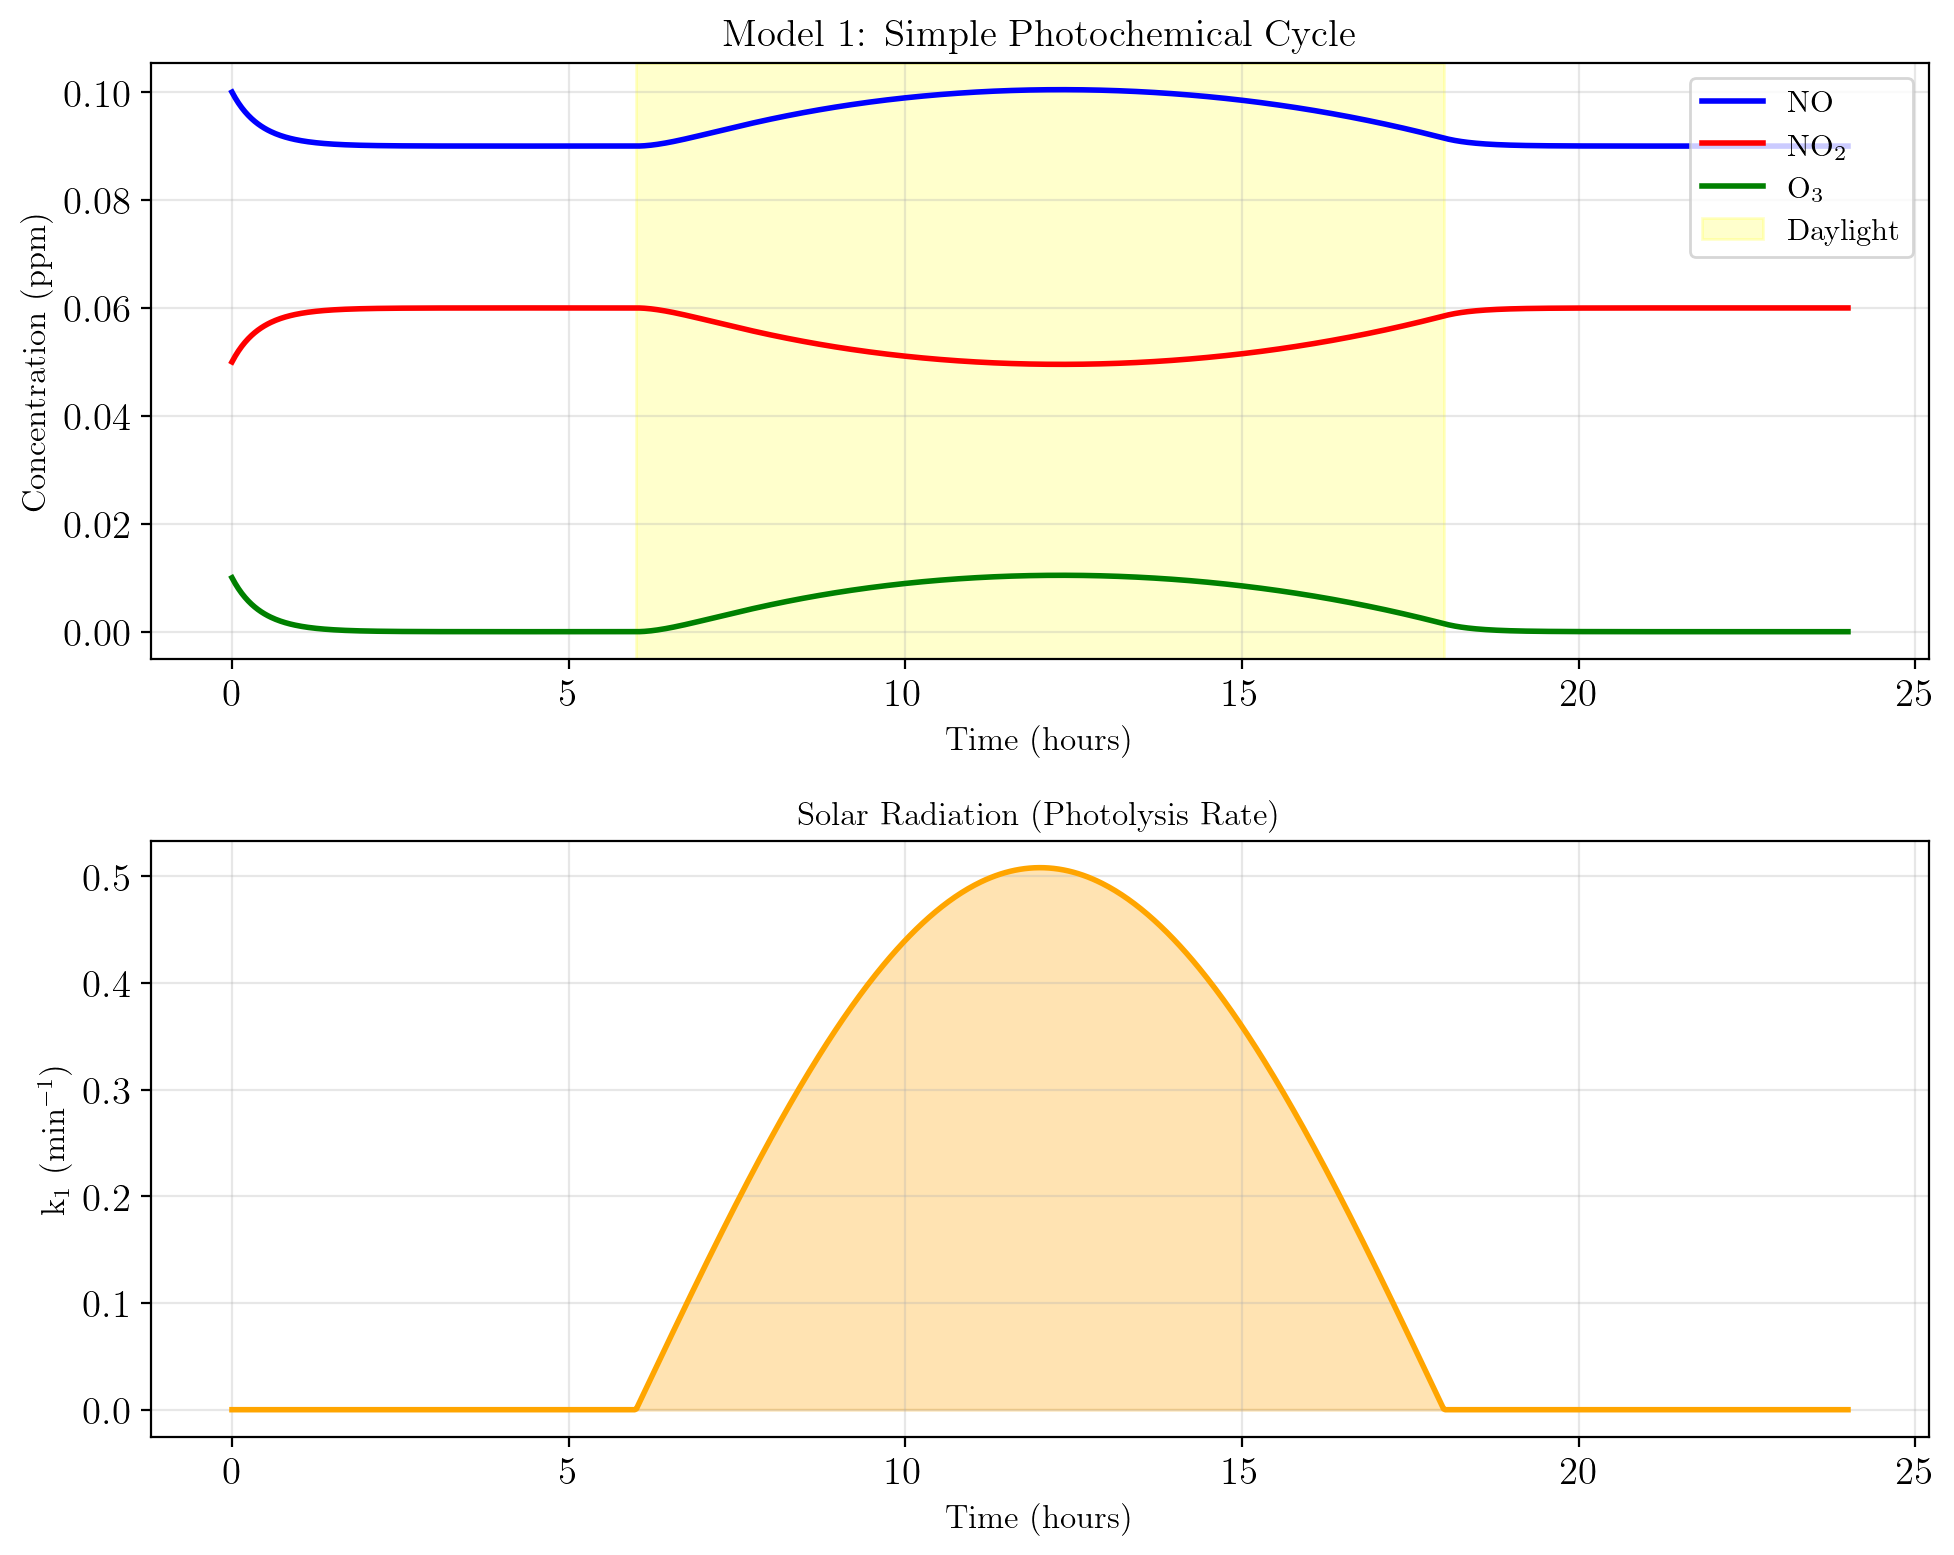

MODEL 1: SUMMARY STATISTICS

Initial concentrations:
  NO:  0.100 ppm
  NO₂: 0.050 ppm
  O₃:  0.010 ppm

Peak concentrations:
  NO:  0.100 ppm at t = 12.3 hrs
  NO₂: 0.060 ppm at t = 24.0 hrs
  O₃:  0.010 ppm at t = 12.3 hrs

Conservation check:
  Initial [NO] + [O₃] = 0.110 ppm
  Final [NO] + [O₃]   = 0.090 ppm


In [20]:
# Initial conditions
y0 = [0.1, 0.05, 0.01]  # [NO, NO2, O3] in ppm

# Time span (24 hours in minutes)
t = np.linspace(0, 24, 1000)

# Solve ODE
solution = odeint(model1, y0, t)

# Extract results
NO, NO2, O3 = solution.T

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot concentrations
ax1.plot(t, NO, 'b-', label='NO', linewidth=2)
ax1.plot(t, NO2, 'r-', label=r'NO$_2$', linewidth=2)
ax1.plot(t, O3, 'g-', label=r'O$_3$', linewidth=2)
ax1.axvspan(6, 18, alpha=0.2, color='yellow', label='Daylight')
ax1.set_xlabel('Time (hours)', fontsize=12)
ax1.set_ylabel('Concentration (ppm)', fontsize=12)
ax1.set_title('Model 1: Simple Photochemical Cycle', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot photolysis rate
k1_values = [k1(ti) for ti in t]
ax2.plot(t, k1_values, 'orange', linewidth=2)
ax2.fill_between(t, k1_values, alpha=0.3, color='orange')
ax2.set_xlabel('Time (hours)', fontsize=12)
ax2.set_ylabel(r'k$_1$ (min$^{-1}$)', fontsize=12)
ax2.set_title('Solar Radiation (Photolysis Rate)', fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
# plt.savefig('model1_results.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("=" * 50)
print("MODEL 1: SUMMARY STATISTICS")
print("=" * 50)
print(f"\nInitial concentrations:")
print(f"  NO:  {y0[0]:.3f} ppm")
print(f"  NO₂: {y0[1]:.3f} ppm")
print(f"  O₃:  {y0[2]:.3f} ppm")

print(f"\nPeak concentrations:")
print(f"  NO:  {NO.max():.3f} ppm at t = {t[NO.argmax()]:.1f} hrs")
print(f"  NO₂: {NO2.max():.3f} ppm at t = {t[NO2.argmax()]:.1f} hrs")
print(f"  O₃:  {O3.max():.3f} ppm at t = {t[O3.argmax()]:.1f} hrs")

print(f"\nConservation check:")
print(f"  Initial [NO] + [O₃] = {y0[0] + y0[2]:.3f} ppm")
print(f"  Final [NO] + [O₃]   = {NO[-1] + O3[-1]:.3f} ppm")
print("=" * 50)

# RUN 1


PHOTOCHEMICAL SMOG MODELING PROJECT
From Simple to Complex Systems
Running Model 1: Simple Photochemical Cycle
Solving ODEs...
Peak O3: 0.0200 ppm at t = 0.0 hours
Peak NO2: 0.0780 ppm at t = 48.0 hours

Photostationary state check at noon (day 1):
  Predicted $\phi$ = k1/k3 = 0.0254 ppm
  Simulated $\phi$ = [NO][O3]/[NO2] = 0.0252 ppm
  Agreement: 99.1%


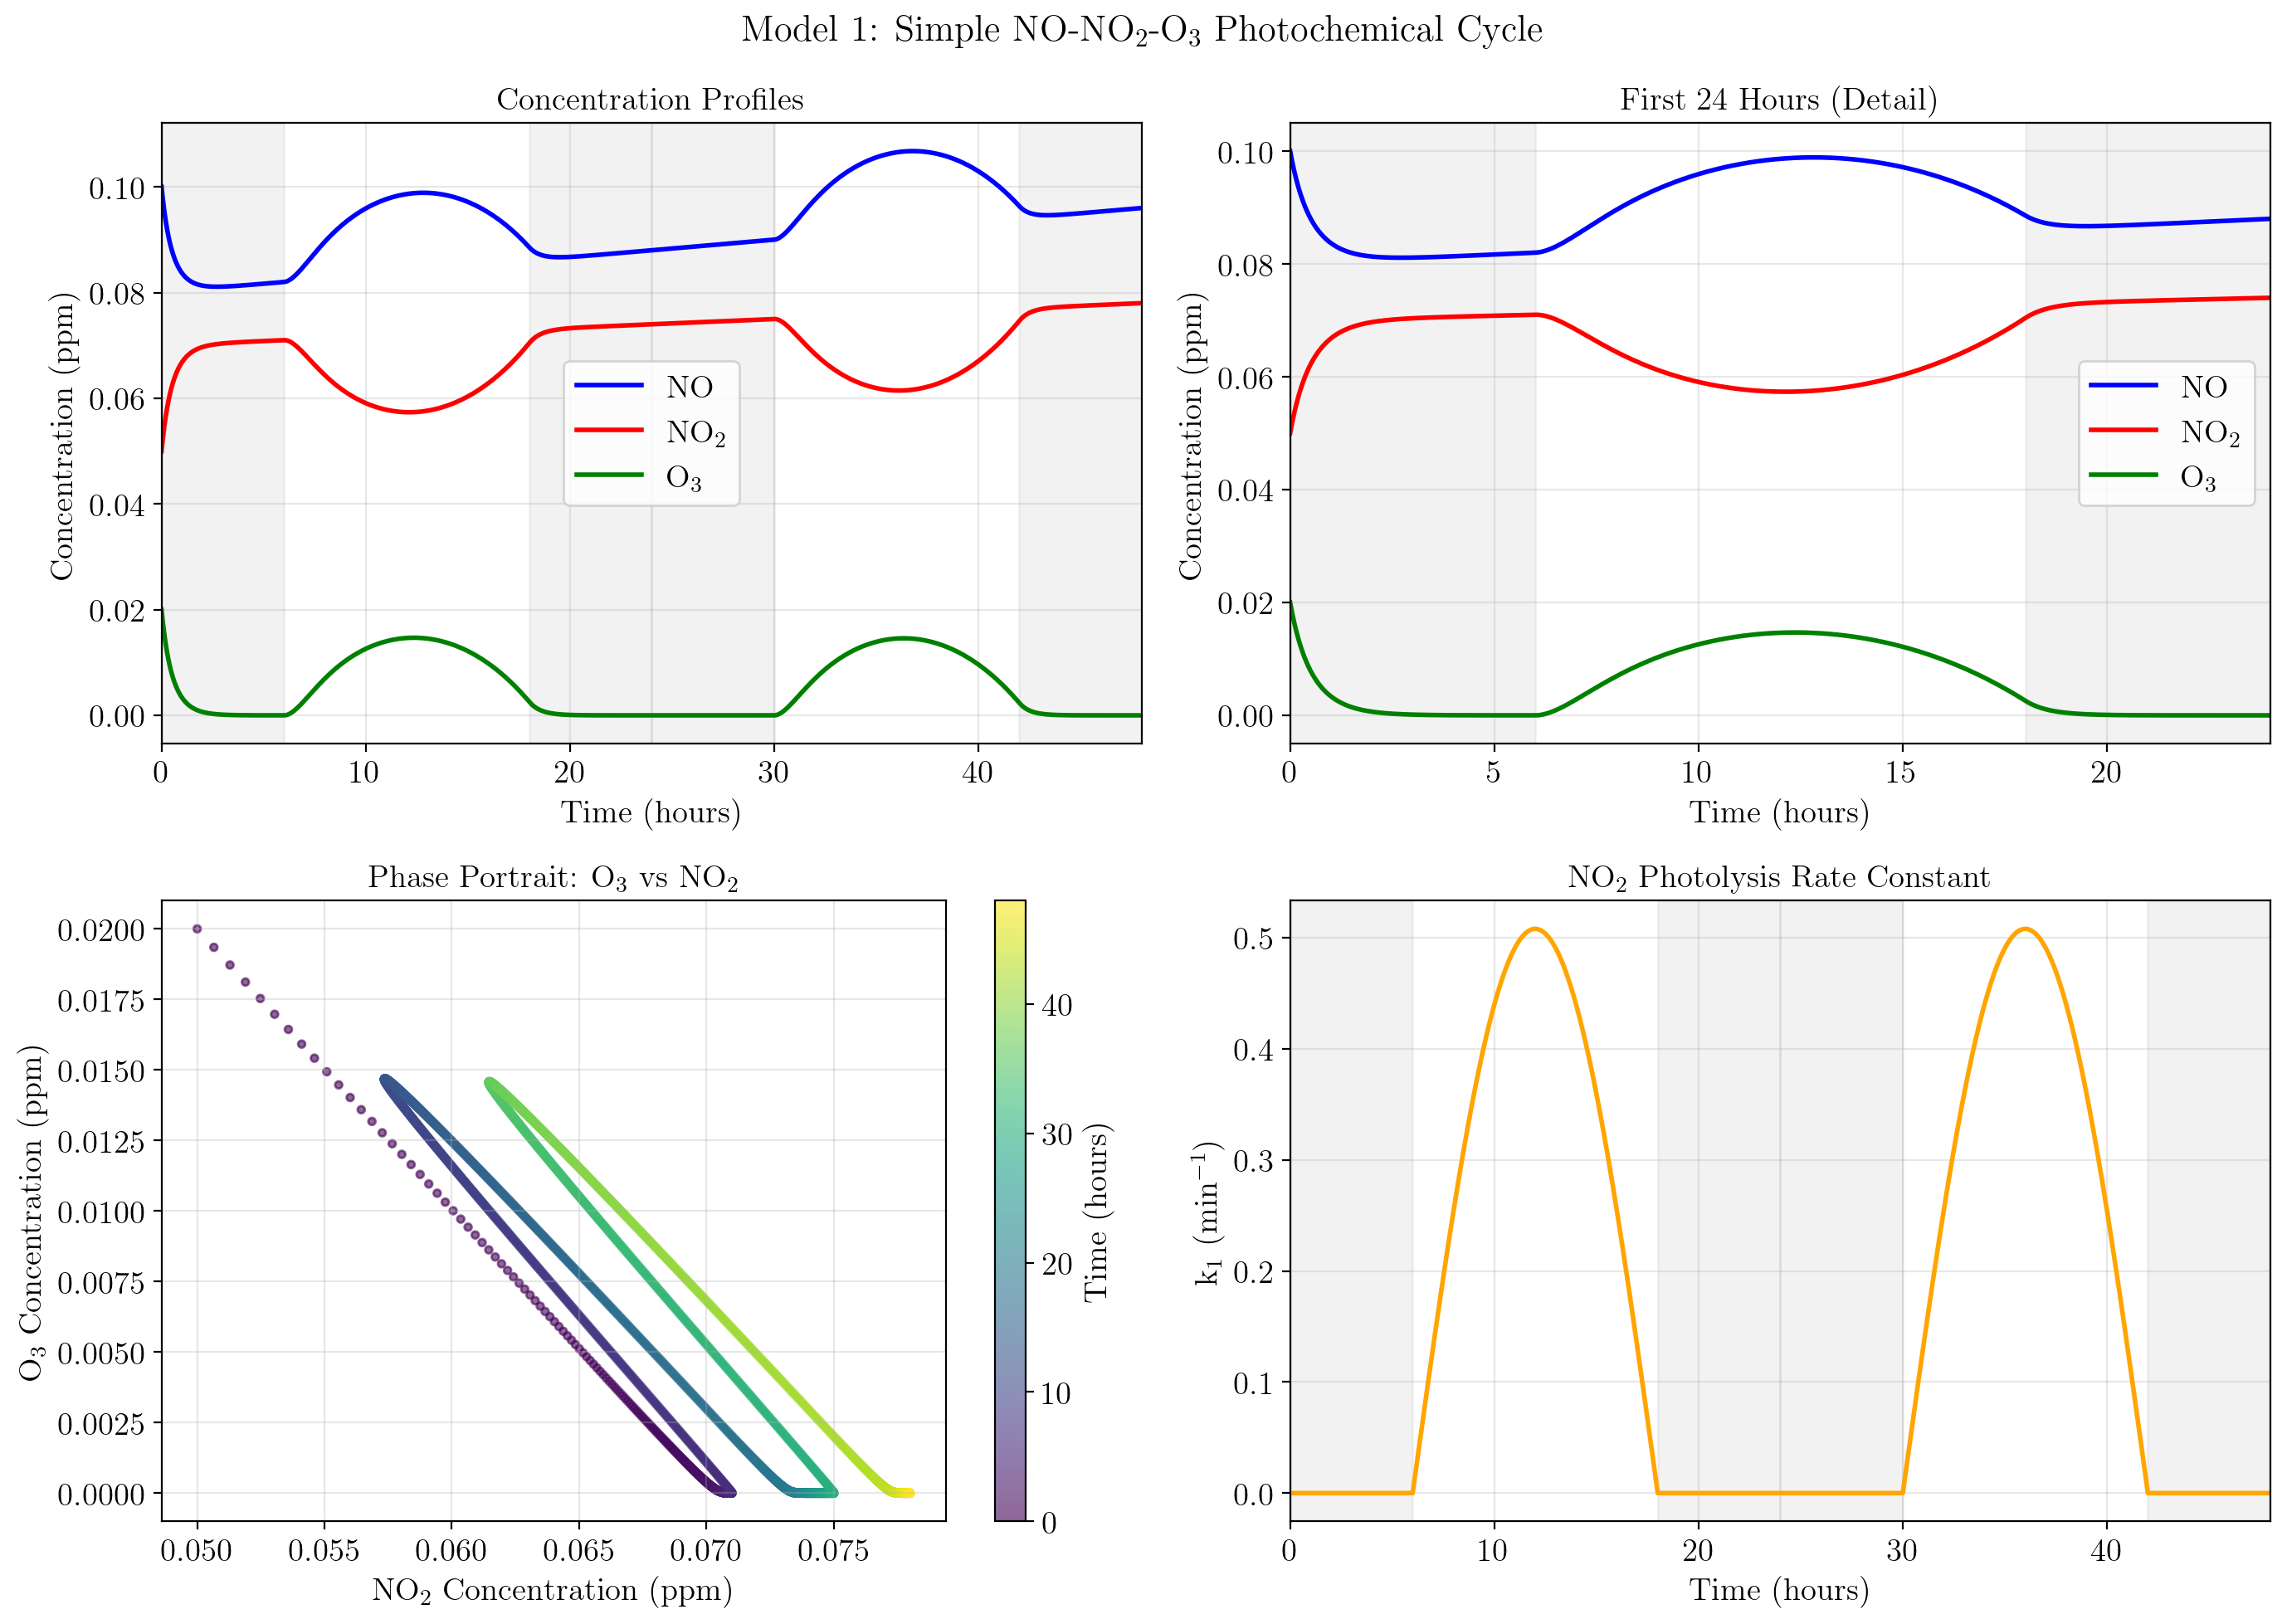


Running Model 2: Extended Chemistry with VOCs
Solving ODEs...
Peak O3: 0.3026 ppm at t = 32.8 hours
Peak OH: 4.16e-03 ppm at t = 37.2 hours
Peak HO2: 1.52e-03 ppm at t = 35.2 hours


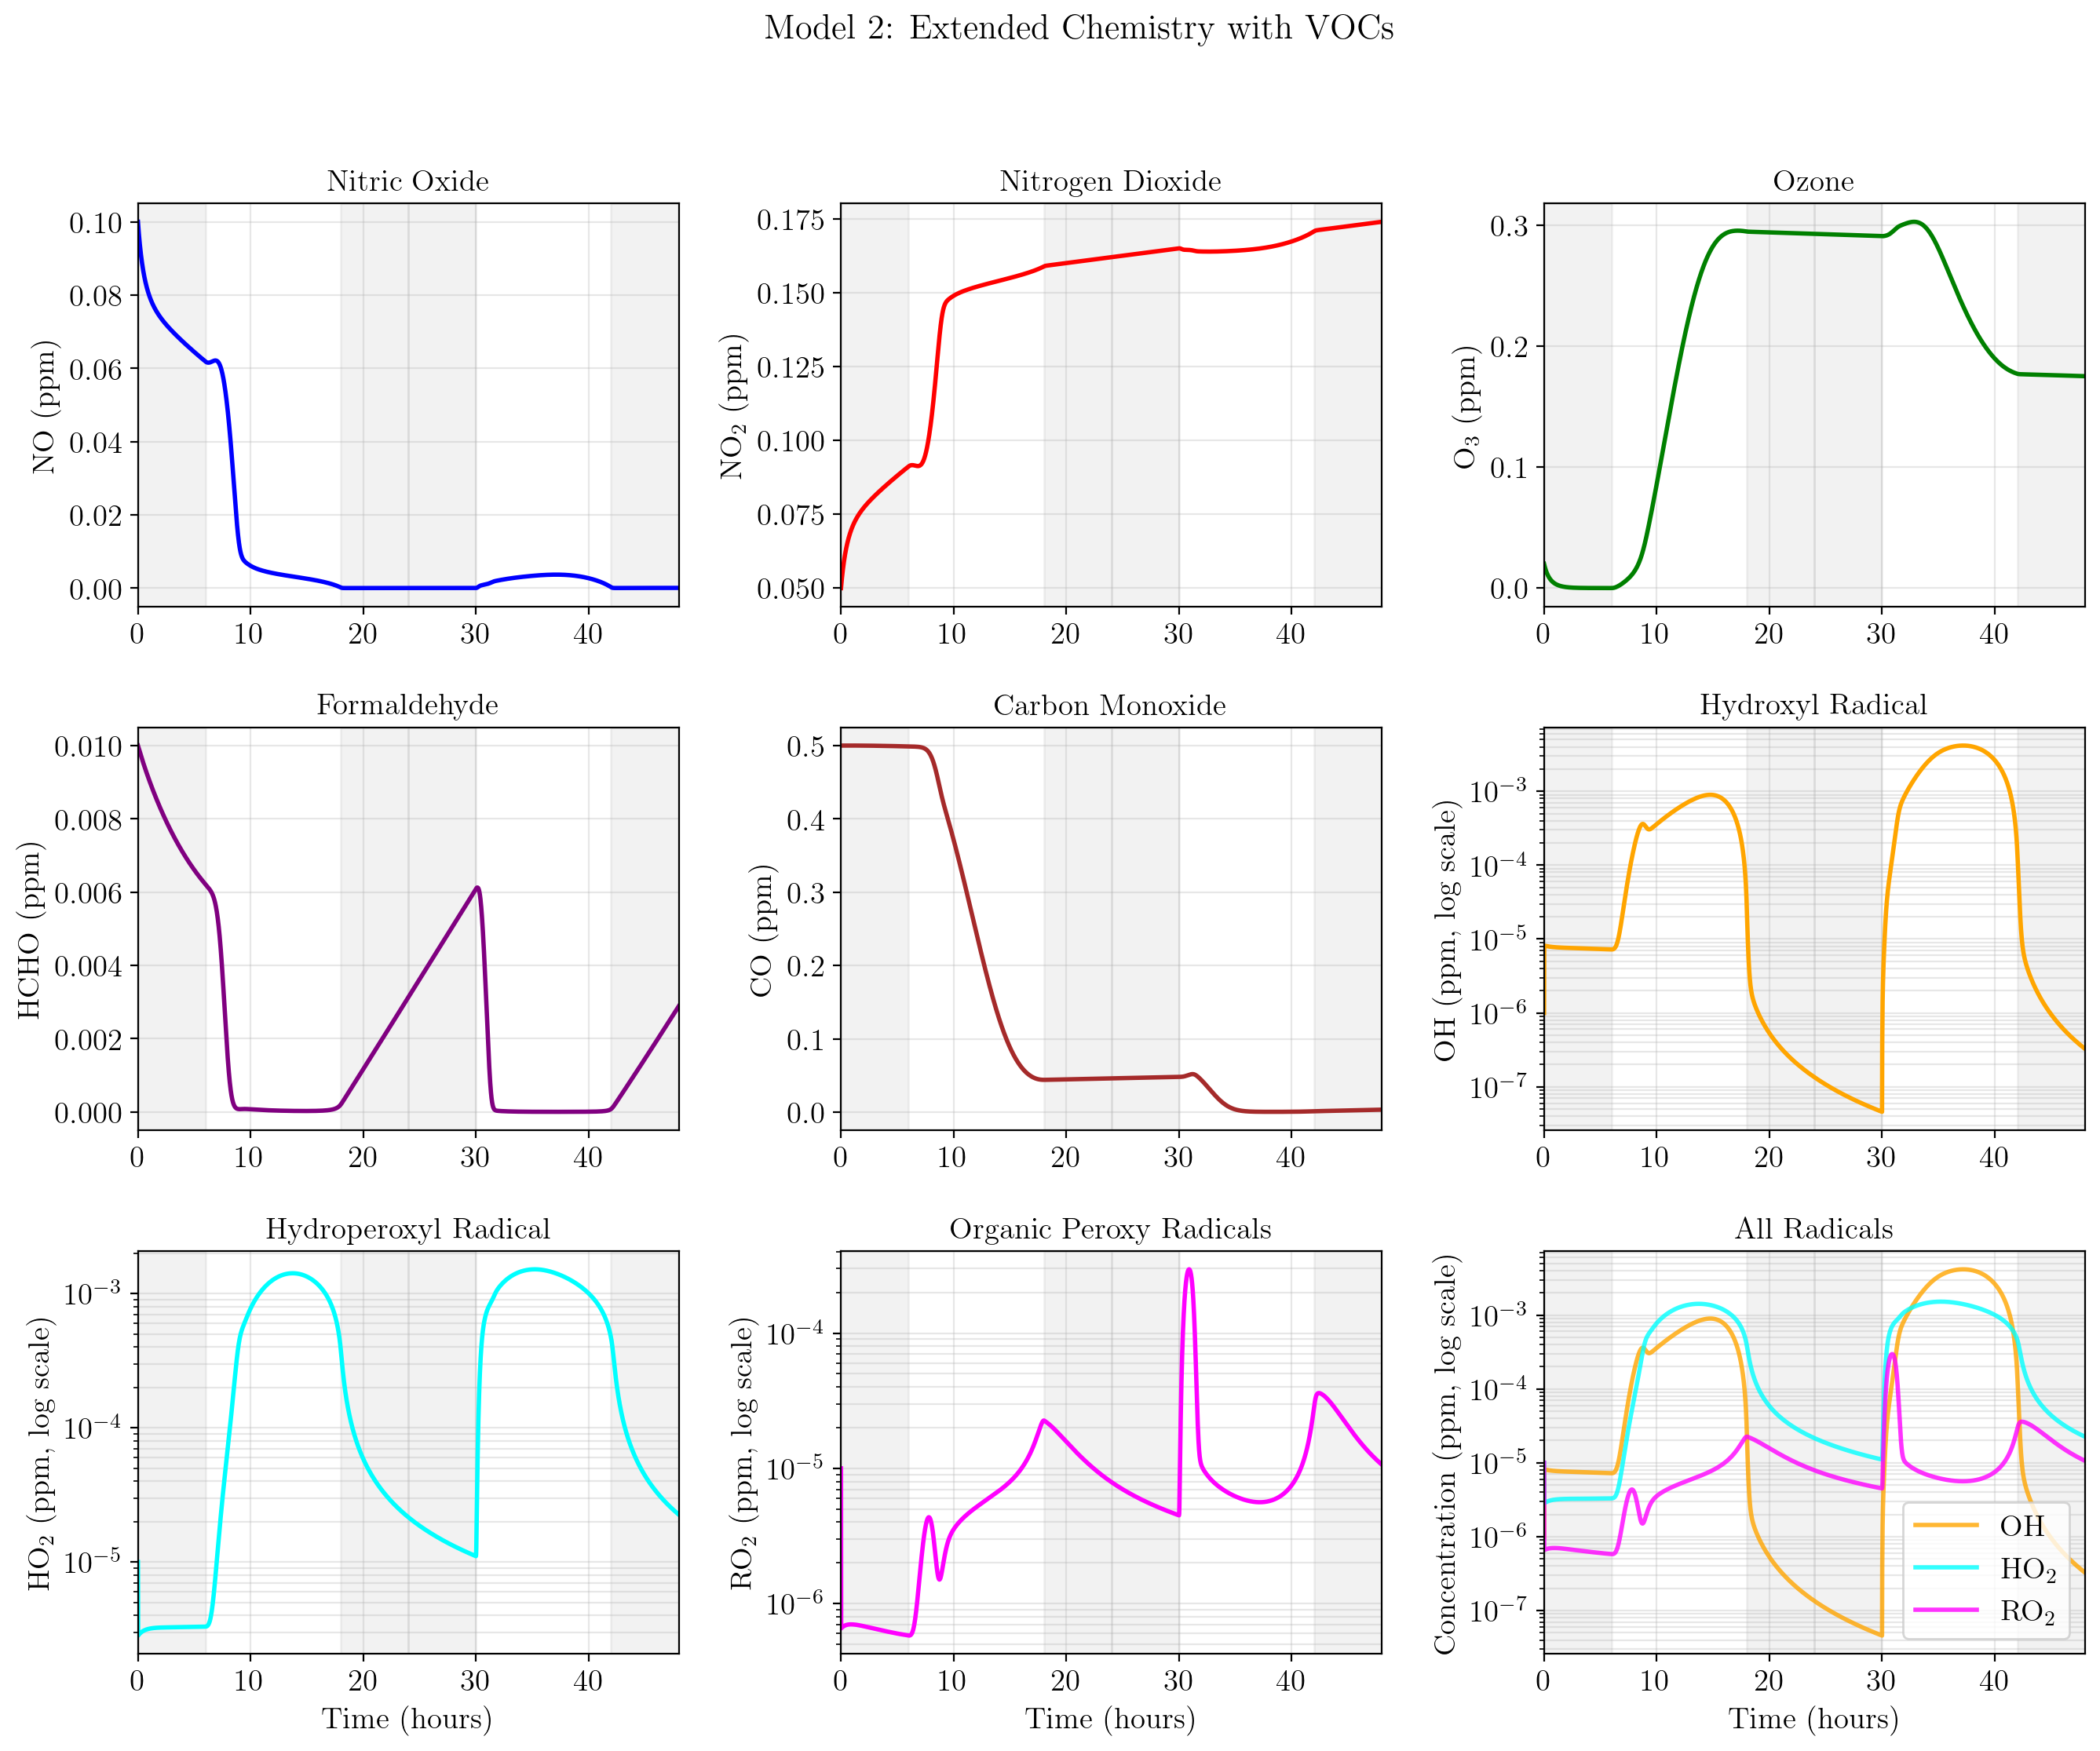


Creating Comparison Plots


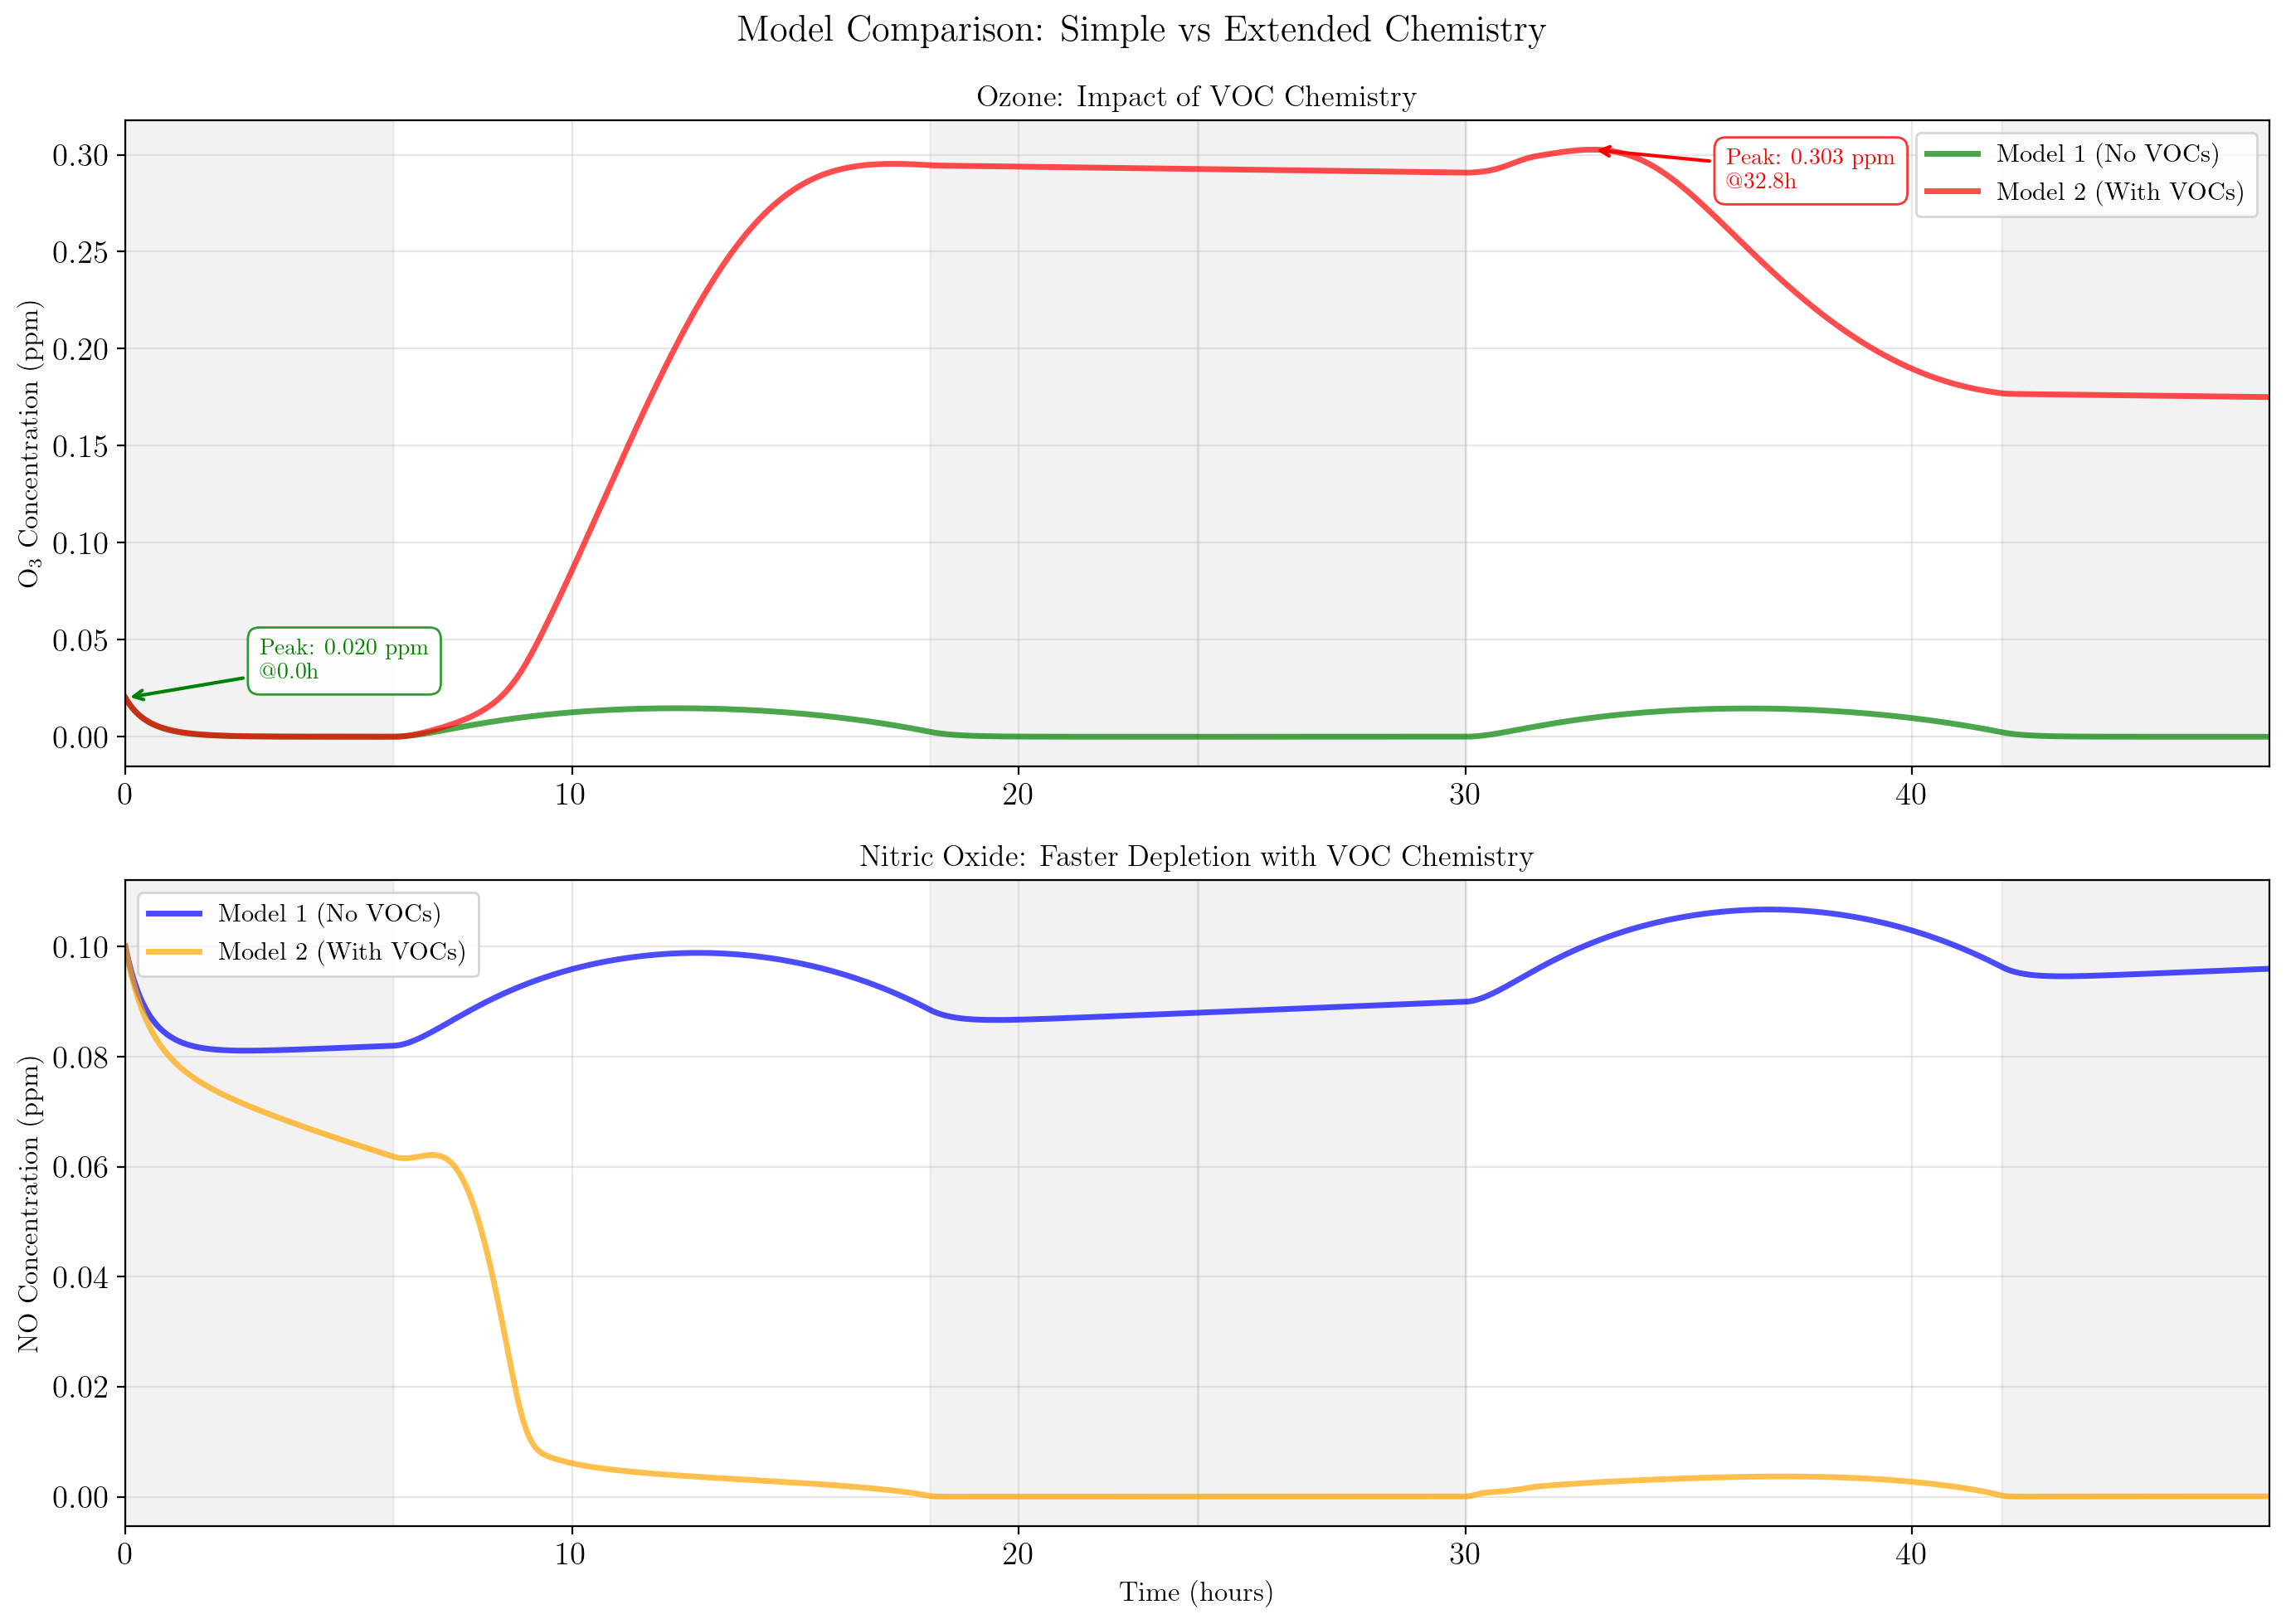


Quantitative Comparison:
------------------------------------------------------------
Metric                                   Model 1      Model 2     
------------------------------------------------------------
Peak O3 (ppm)                            0.0200       0.3026      
Peak O3 time (hours)                     0.0          32.8        
O3 enhancement factor                    -            15.13       
Min NO (ppm)                             0.0811       0.0000      
Final O3 (48h, ppm)                      0.0000       0.1751      
------------------------------------------------------------

Creating Detailed Comparison Figure
Solving Model 1...
Solving Model 2...


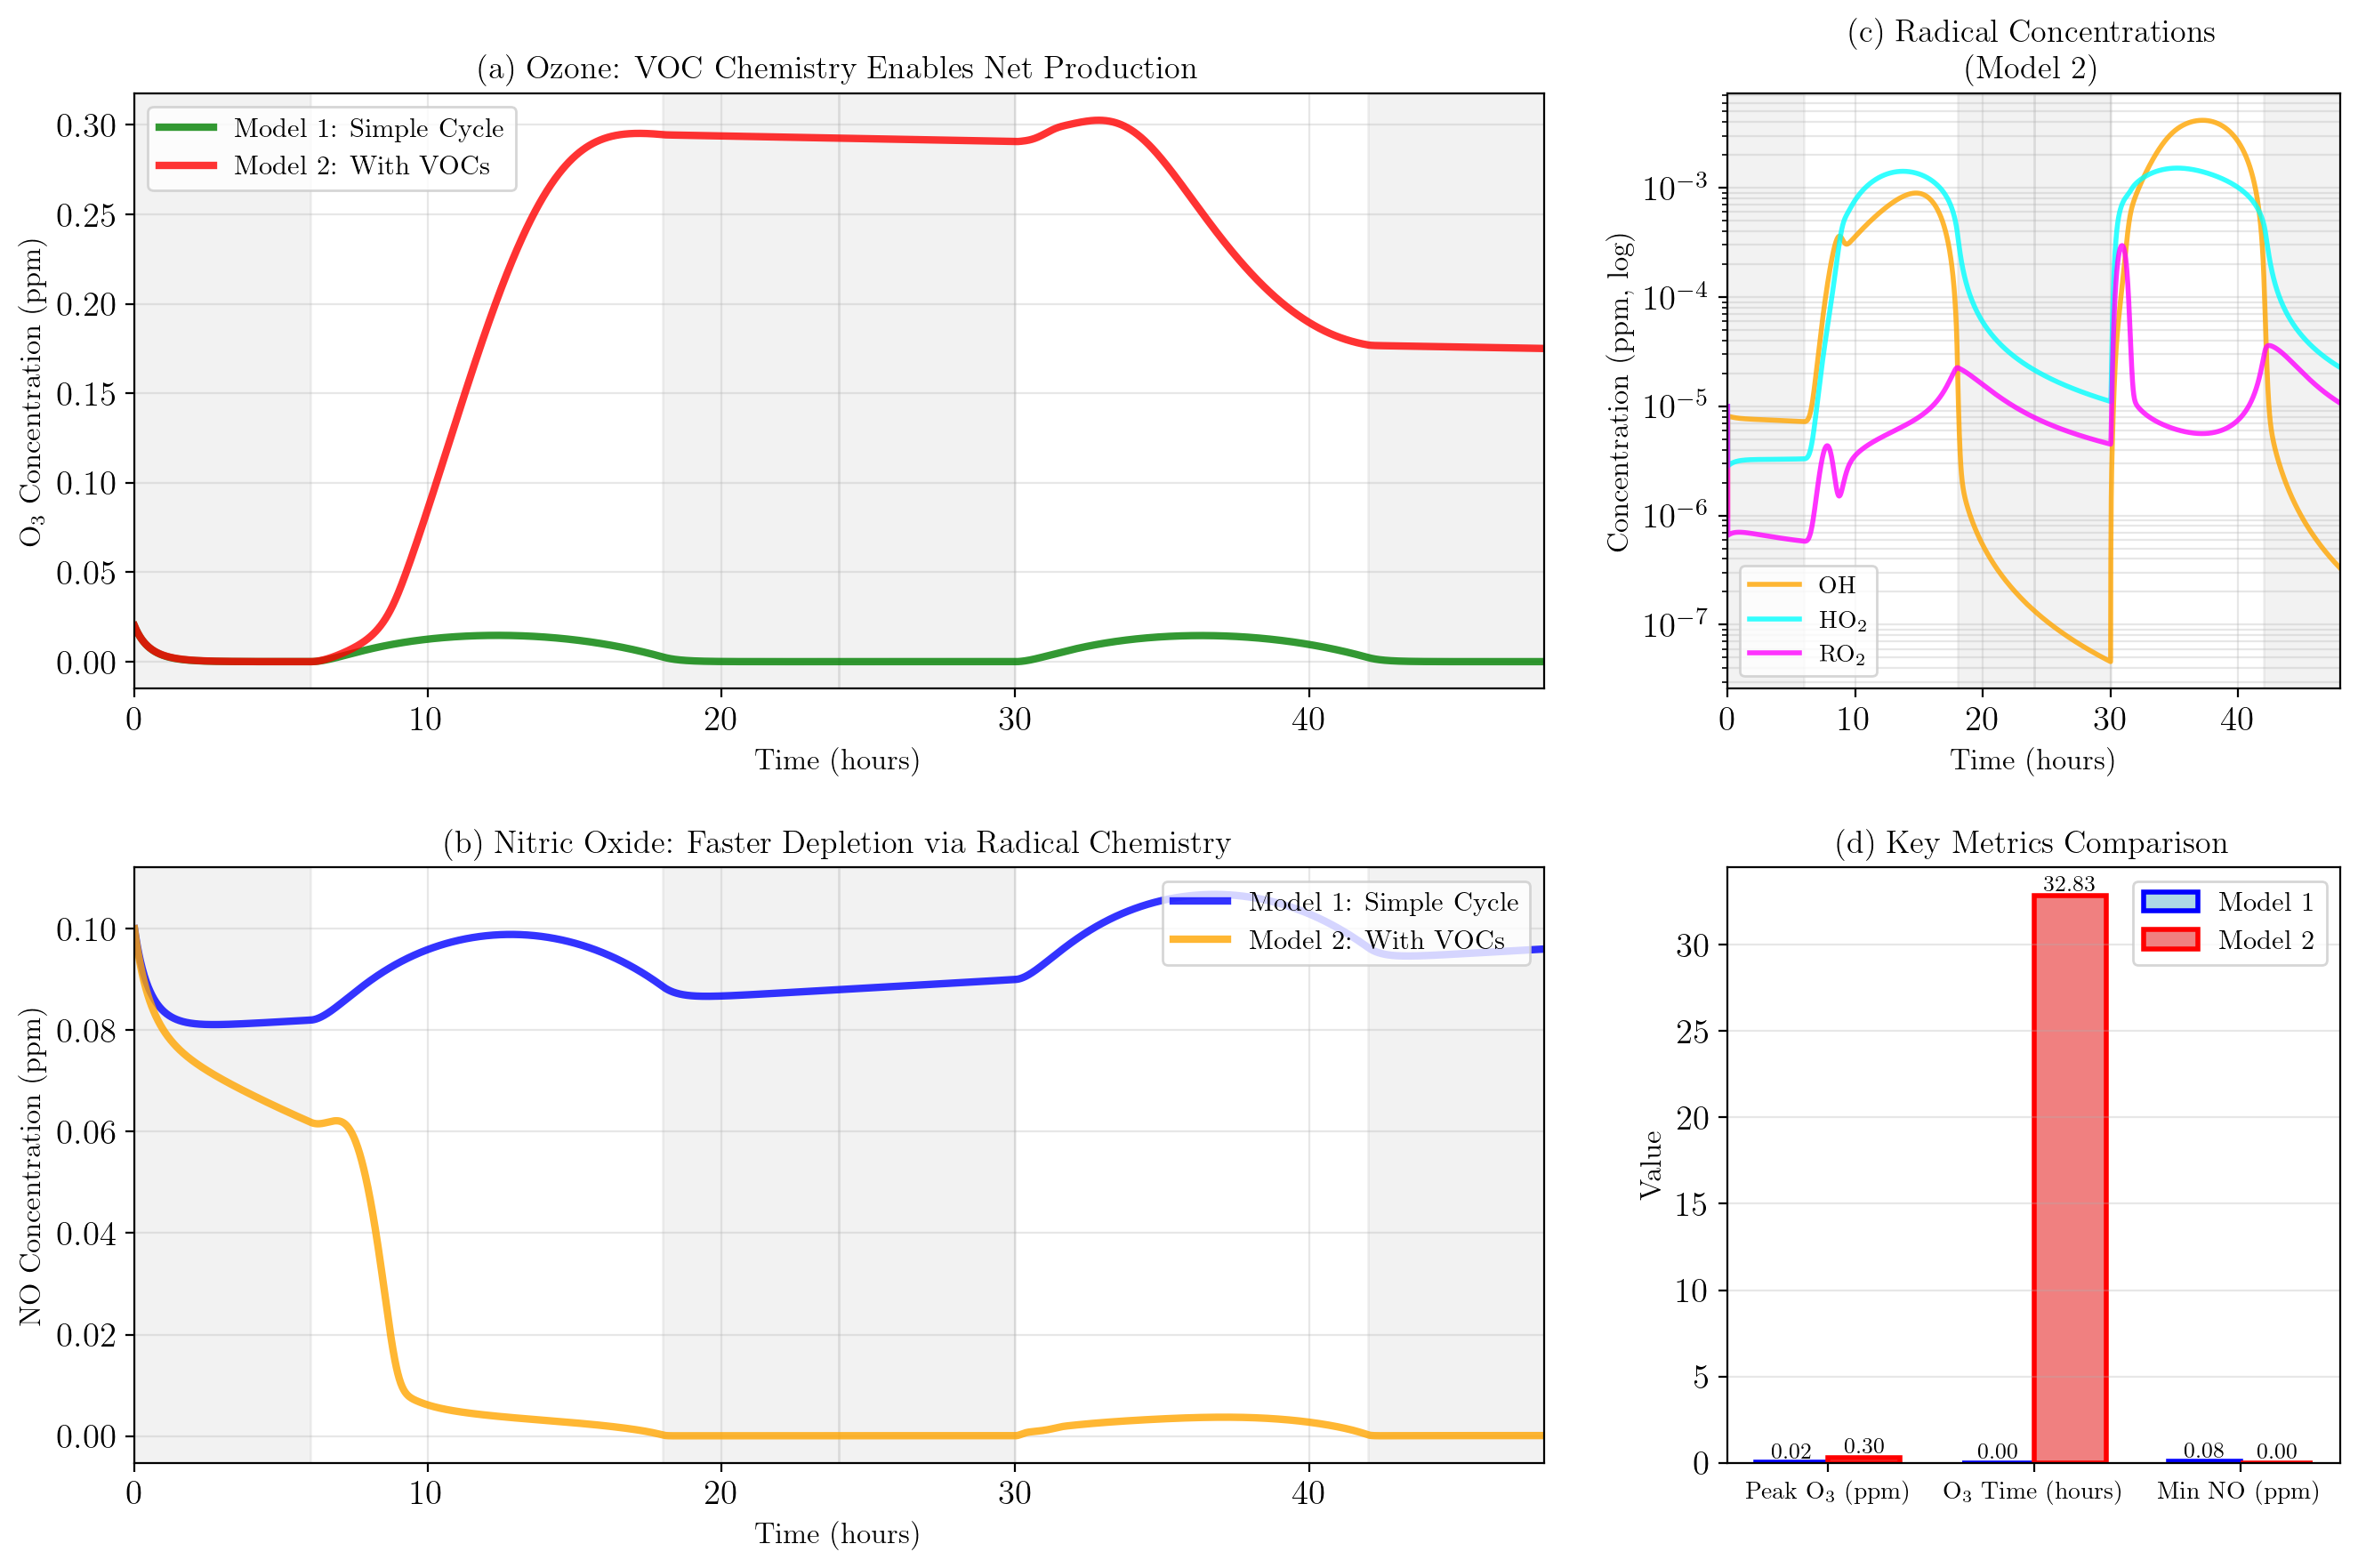


Performing Sensitivity Analysis: Emission Rates
Running sensitivity simulations...


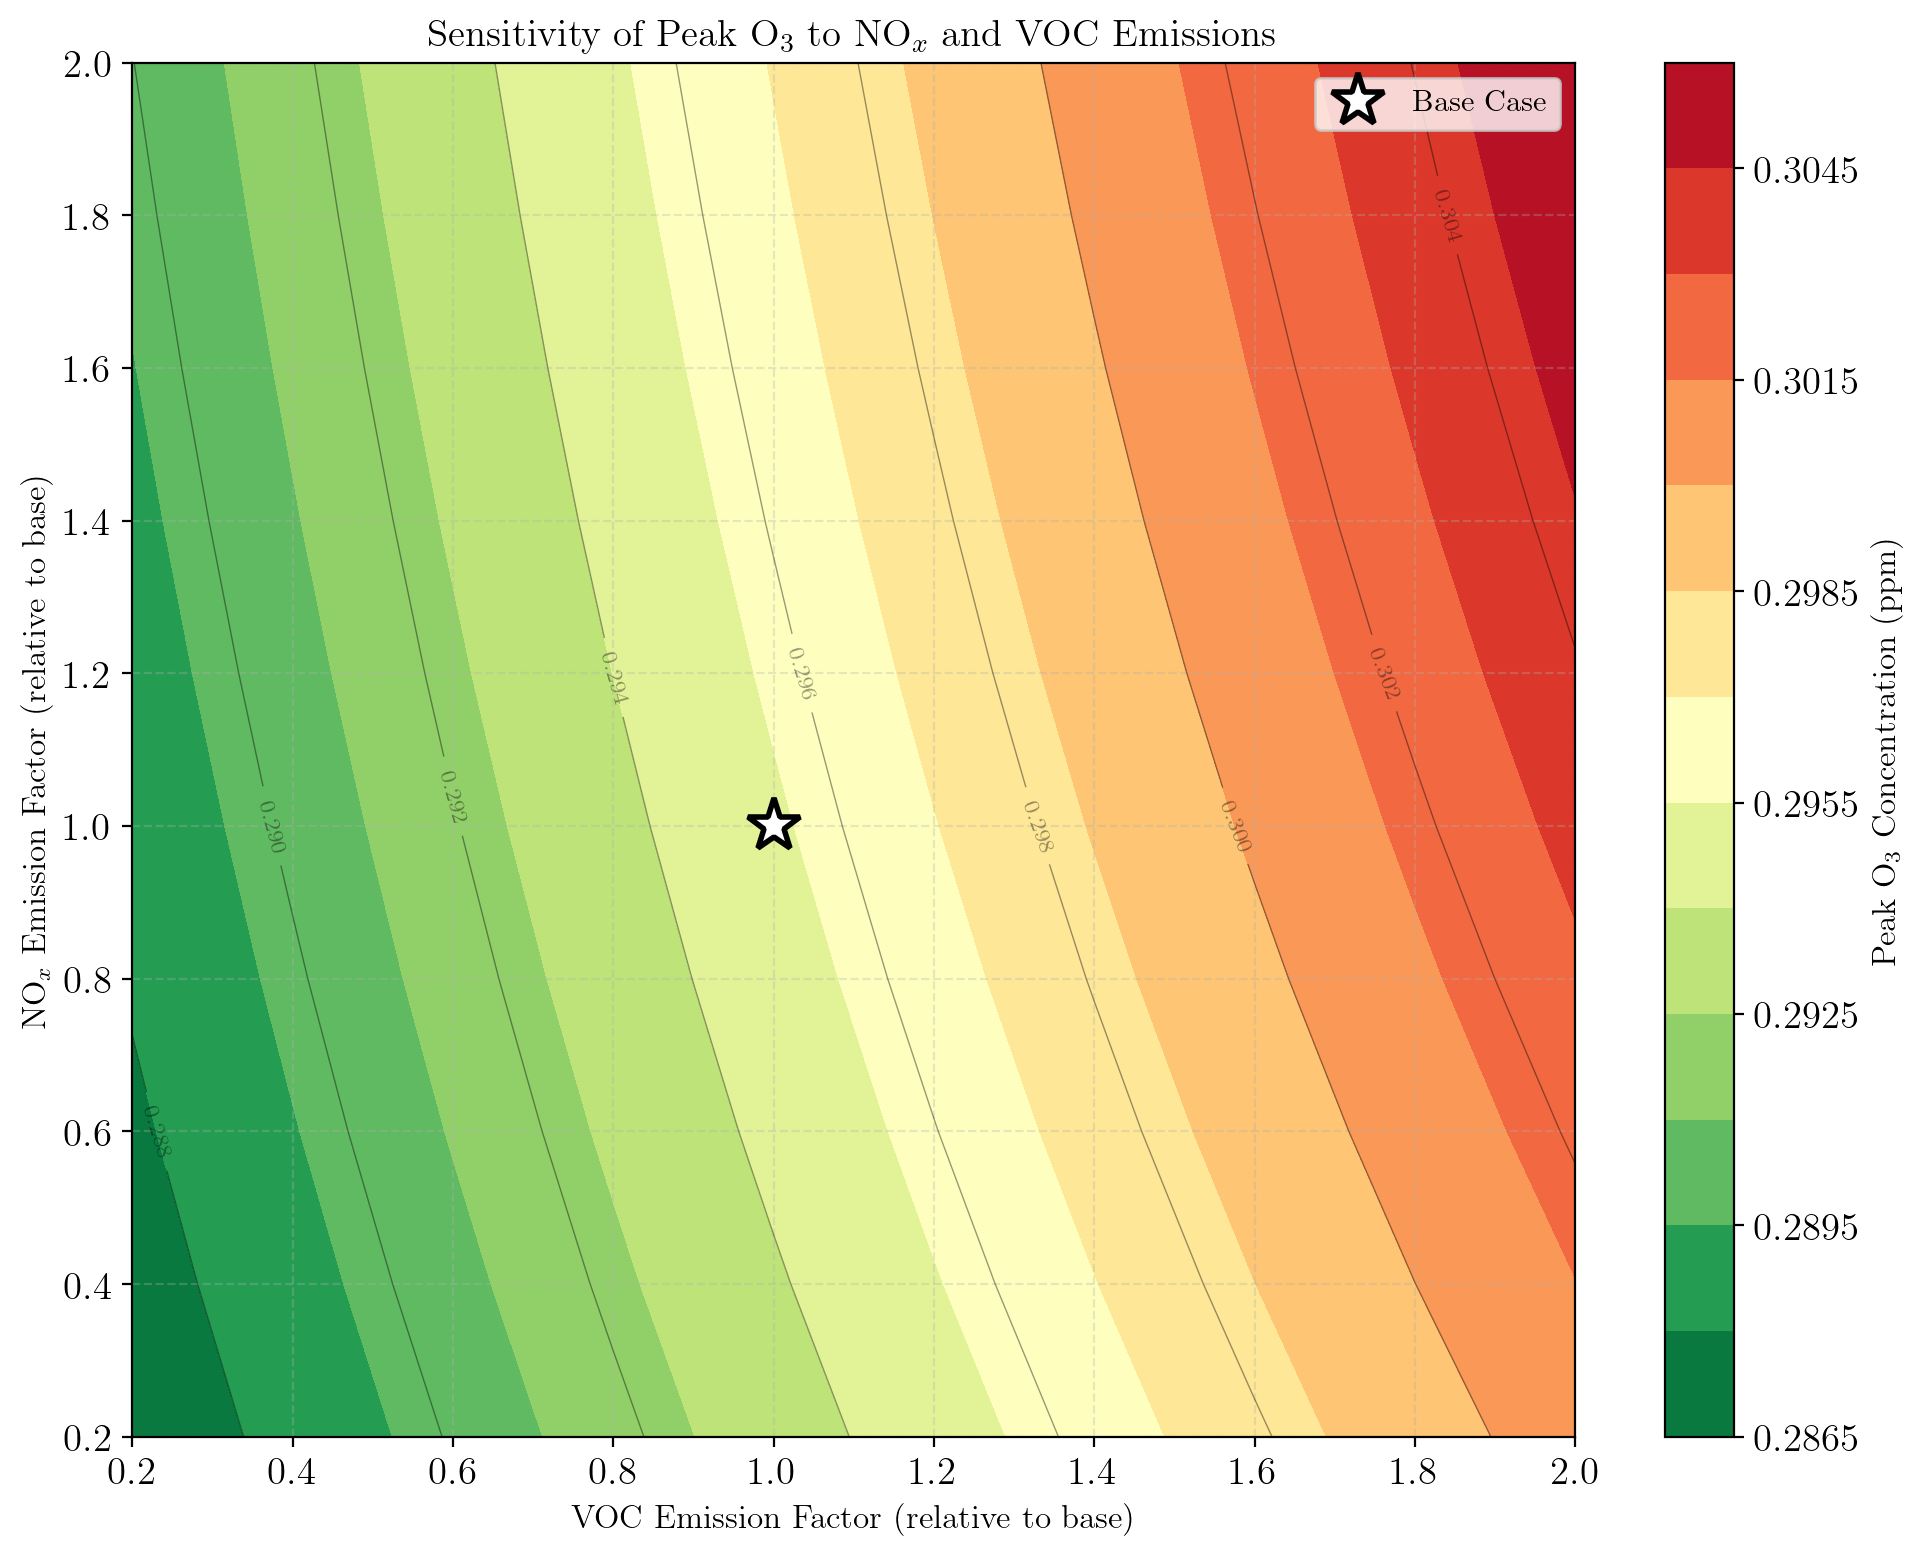


Regime Analysis:
------------------------------------------------------------
VOC-limited regime (High NOₓ, Low VOC): 0.2933 ppm
NOₓ-limited regime (Low NOₓ, High VOC): 0.3006 ppm
Balanced regime: 0.2974 ppm

Interpretation:
- In VOC-limited areas, reducing NOₓ may INCREASE O₃
- In NOₓ-limited areas, reducing NOₓ DECREASES O₃
- Urban cores often VOC-limited, suburbs NOₓ-limited

Performing Sensitivity Analysis: Temperature
Running temperature sensitivity simulations...


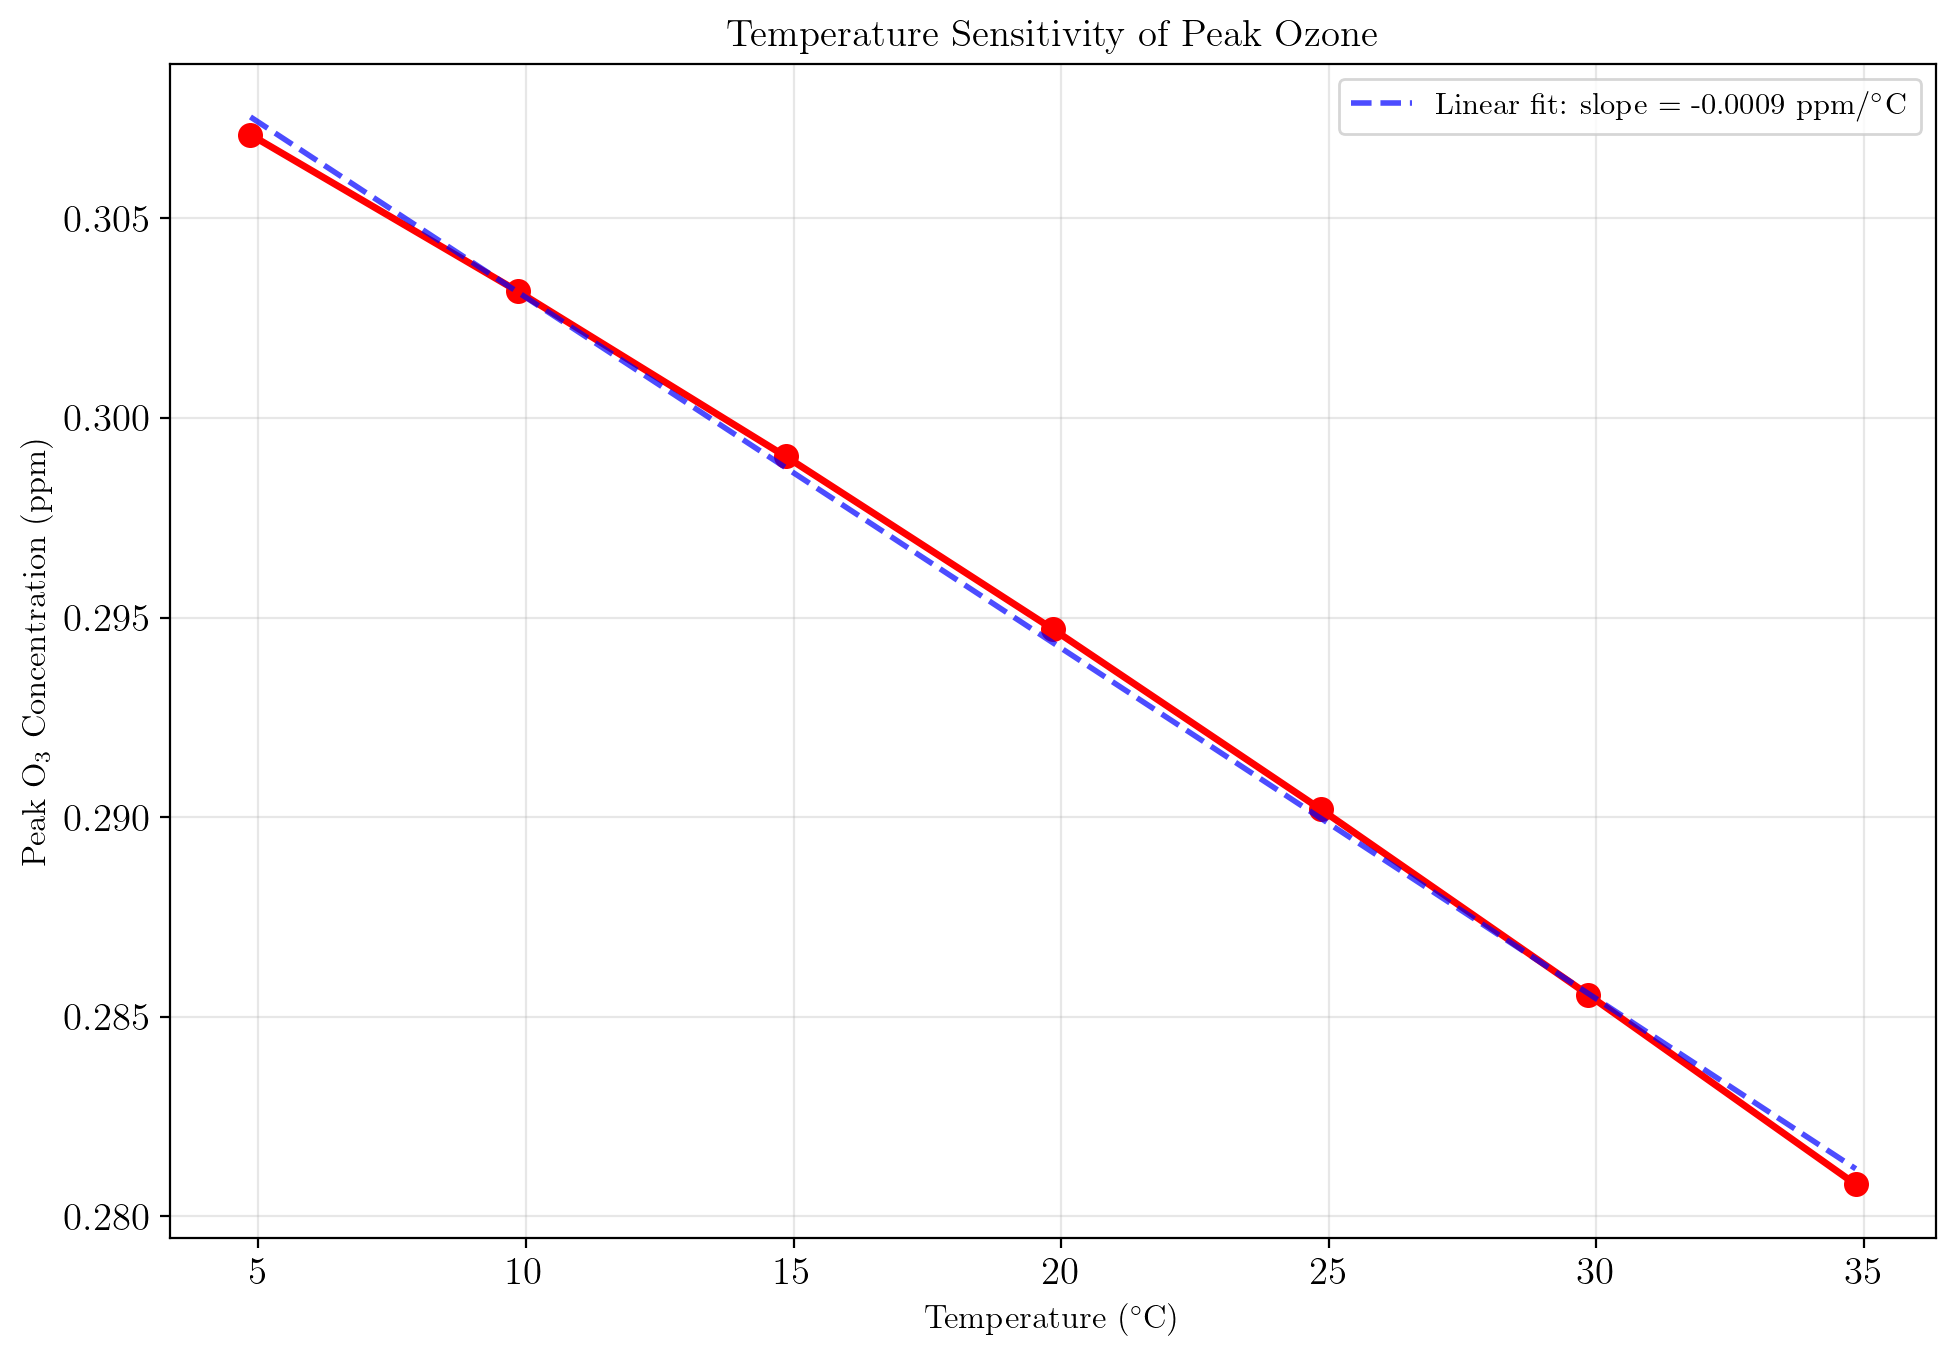


Temperature sensitivity:
O$_3$ change per 10 K: -2.9%
Peak O$_3$ at 5$^\circ$C: 0.3071 ppm
Peak O$_3$ at 35$^\circ$C: 0.2808 ppm
Ratio (35$^\circ$C/5$^\circ$C): 0.91

ALL SIMULATIONS COMPLETED SUCCESSFULLY

Generated files:
  - model1_concentrations.png
  - model2_concentrations.png
  - comparison_plot.png
  - detailed_comparison.png
  - sensitivity_emissions.png
  - sensitivity_temperature.png

Thank you for using this modeling framework!



In [23]:
# ============================================================================
# UTILITY FUNCTIONS
# ============================================================================

def solar_intensity(t, k_max):
    """
    Calculate solar intensity factor based on time of day.
    
    Parameters:
    -----------
    t : float
        Time in hours (can be > 24 for multi-day simulations)
    k_max : float
        Maximum rate constant at solar noon
        
    Returns:
    --------
    float : Photolysis rate constant at time t
    """
    hour = t % 24
    if 6 <= hour <= 18:
        # Sinusoidal variation from sunrise (6h) to sunset (18h)
        return k_max * np.sin(np.pi * (hour - 6) / 12)
    return 0.0

def add_day_night_shading(ax, t_max):
    """Add shading to indicate day/night periods on plot."""
    for day in range(int(t_max // 24) + 1):
        # Night before sunrise (0-6h)
        ax.axvspan(day * 24, day * 24 + 6, alpha=0.1, color='gray', zorder=0)
        # Night after sunset (18-24h)
        ax.axvspan(day * 24 + 18, (day + 1) * 24, alpha=0.1, color='gray', zorder=0)

# ============================================================================
# MODEL 1: SIMPLE NO-NO2-O3 PHOTOCHEMICAL CYCLE
# ============================================================================

def model1_odes(y, t, params):
    """
    Model 1: Three-species photochemical cycle (NO, NO2, O3).
    
    Parameters:
    -----------
    y : array
        Concentrations [NO, NO2, O3] in ppm
    t : float
        Time in hours
    params : dict
        Dictionary containing rate constants and emissions
        
    Returns:
    --------
    list : Time derivatives [dNO/dt, dNO2/dt, dO3/dt]
    """
    NO, NO2, O3 = y
    
    # Time-dependent photolysis rate
    k1 = solar_intensity(t, params['k1_max'])
    
    # Extract other parameters
    k3 = params['k3']
    E_NO = params['E_NO']
    E_NO2 = params['E_NO2']
    
    # Reaction rates
    R1 = k1 * NO2                    # NO2 photolysis
    R3 = k3 * NO * O3               # NO + O3 -> NO2
    
    # Differential equations
    dNO_dt = R1 - R3 + E_NO
    dNO2_dt = -R1 + R3 + E_NO2
    dO3_dt = R1 - R3
    
    return [dNO_dt, dNO2_dt, dO3_dt]

def run_model1():
    """
    Run Model 1 simulation and create plots.
    """
    print("Running Model 1: Simple Photochemical Cycle")
    print("=" * 60)
    
    # Parameters
    params = {
        'k1_max': 0.508,      # min^-1 (maximum NO2 photolysis rate)
        'k3': 20.0,           # ppm^-1 min^-1 (NO + O3 reaction)
        'E_NO': 0.02 / 60,    # ppm/min (converted from ppm/h)
        'E_NO2': 0.01 / 60    # ppm/min
    }
    
    # Initial conditions (ppm)
    y0 = [
        0.100,  # NO
        0.050,  # NO2
        0.020   # O3
    ]
    
    # Time array (0 to 48 hours, 1-minute resolution)
    t = np.linspace(0, 48, 48 * 60 + 1)
    
    # Solve ODEs
    print("Solving ODEs...")
    solution = odeint(model1_odes, y0, t, args=(params,))
    
    NO = solution[:, 0]
    NO2 = solution[:, 1]
    O3 = solution[:, 2]
    
    print(f"Peak O3: {O3.max():.4f} ppm at t = {t[O3.argmax()]:.1f} hours")
    print(f"Peak NO2: {NO2.max():.4f} ppm at t = {t[NO2.argmax()]:.1f} hours")
    
    # Calculate photostationary state ratio
    midday_idx = np.argmin(np.abs(t - 12.0))
    if NO2[midday_idx] > 0:
        phi_simulated = (NO[midday_idx] * O3[midday_idx]) / NO2[midday_idx]
        phi_predicted = params['k1_max'] / params['k3']
        print(f"\nPhotostationary state check at noon (day 1):")
        print(fr"  Predicted $\phi$ = k1/k3 = {phi_predicted:.4f} ppm")
        print(fr"  Simulated $\phi$ = [NO][O3]/[NO2] = {phi_simulated:.4f} ppm")
        print(f"  Agreement: {(1 - abs(phi_simulated - phi_predicted)/phi_predicted)*100:.1f}%")
    
    # Create plots
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(r'Model 1: Simple NO-NO$_2$-O$_3$ Photochemical Cycle', fontsize=16, fontweight='bold')
    
    # Plot 1: All concentrations
    ax1 = axes[0, 0]
    ax1.plot(t, NO, 'b-', label=r'NO', linewidth=2)
    ax1.plot(t, NO2, 'r-', label=r'NO$_2$', linewidth=2)
    ax1.plot(t, O3, 'g-', label=r'O$_3$', linewidth=2)
    add_day_night_shading(ax1, 48)
    ax1.set_xlabel('Time (hours)')
    ax1.set_ylabel('Concentration (ppm)')
    ax1.set_title('Concentration Profiles')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, 48)
    
    # Plot 2: Focus on first 24 hours
    ax2 = axes[0, 1]
    ax2.plot(t[:1440], NO[:1440], 'b-', label='NO', linewidth=2)
    ax2.plot(t[:1440], NO2[:1440], 'r-', label=r'NO$_2$', linewidth=2)
    ax2.plot(t[:1440], O3[:1440], 'g-', label=r'O$_3$', linewidth=2)
    add_day_night_shading(ax2, 24)
    ax2.set_xlabel('Time (hours)')
    ax2.set_ylabel('Concentration (ppm)')
    ax2.set_title('First 24 Hours (Detail)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(0, 24)
    
    # Plot 3: Phase portrait (O3 vs NO2)
    ax3 = axes[1, 0]
    # Color code by time
    scatter = ax3.scatter(NO2, O3, c=t, cmap='viridis', s=10, alpha=0.6)
    ax3.set_xlabel(r'NO$_2$ Concentration (ppm)')
    ax3.set_ylabel(r'O$_3$ Concentration (ppm)')
    ax3.set_title(r'Phase Portrait: O$_3$ vs NO$_2$')
    ax3.grid(True, alpha=0.3)
    cbar = plt.colorbar(scatter, ax=ax3)
    cbar.set_label('Time (hours)')
    
    # Plot 4: Photolysis rate
    ax4 = axes[1, 1]
    k1_values = np.array([solar_intensity(ti, params['k1_max']) for ti in t])
    ax4.plot(t, k1_values, 'orange', linewidth=2)
    add_day_night_shading(ax4, 48)
    ax4.set_xlabel('Time (hours)')
    ax4.set_ylabel(r'k$_1$ (min$^{-1}$)')
    ax4.set_title(r'NO$_2$ Photolysis Rate Constant')
    ax4.grid(True, alpha=0.3)
    ax4.set_xlim(0, 48)
    
    plt.tight_layout()
    # plt.savefig('model1_concentrations.png', dpi=300, bbox_inches='tight')
    # print("\nPlot saved: model1_concentrations.png")
    plt.show()
    
    return t, solution, params

# ============================================================================
# MODEL 2: EXTENDED CHEMISTRY WITH VOCs
# ============================================================================

def model2_odes(y, t, params):
    """
    Model 2: Eight-species system with VOC chemistry.
    Species: NO, NO2, O3, HCHO, CO, OH, HO2, RO2
    
    Parameters:
    -----------
    y : array
        Concentrations [NO, NO2, O3, HCHO, CO, OH, HO2, RO2] in ppm
    t : float
        Time in hours
    params : dict
        Dictionary containing rate constants and emissions
        
    Returns:
    --------
    list : Time derivatives for all 8 species
    """
    NO, NO2, O3, HCHO, CO, OH, HO2, RO2 = y
    
    # Time-dependent photolysis rates
    k1 = solar_intensity(t, params['k1_max'])
    k20 = solar_intensity(t, params['k20_max'])
    k21 = solar_intensity(t, params['k21_max'])
    
    # Extract chemical reaction rate constants
    k3 = params['k3']
    k15 = params['k15']
    k16 = params['k16']
    k19 = params['k19']
    k23 = params['k23']
    k47 = params['k47']
    k50 = params['k50']
    
    # Extract emissions
    E_NO = params['E_NO']
    E_NO2 = params['E_NO2']
    E_HCHO = params['E_HCHO']
    E_CO = params['E_CO']
    
    # Compute reaction rates
    R1 = k1 * NO2                           # NO2 + hv -> NO + O3
    R3 = k3 * NO * O3                       # NO + O3 -> NO2 + O2
    R15 = k15 * NO * HO2                    # HO2 + NO -> NO2 + OH
    R16 = k16 * NO * RO2                    # RO2 + NO -> NO2 + products
    R19 = k19 * CO * OH                     # CO + OH -> HO2 + CO2
    R20 = k20 * O3                          # O3 + hv -> 2OH
    R21 = k21 * HCHO                        # HCHO + hv -> 2HO2 + CO
    R23 = k23 * HCHO * OH                   # HCHO + OH -> HO2 + CO
    R47 = k47 * O3 * OH                     # O3 + OH -> HO2 + O2
    R50 = k50 * HO2 * HO2                   # HO2 + HO2 -> H2O2 + O2
    
    # Differential equations
    dNO_dt = R1 - R3 - R15 - R16 + E_NO
    
    dNO2_dt = -R1 + R3 + R15 + R16 + E_NO2
    
    dO3_dt = R1 - R3 - R20 - R47
    
    dHCHO_dt = -R21 - R23 + E_HCHO
    
    dCO_dt = R21 + R23 - R19 + E_CO
    
    dOH_dt = 2*R20 - R19 - R23 + R15 - R47
    
    dHO2_dt = 2*R21 + R23 + R19 - R15 - 2*R50 + R47
    
    # Simplified RO2 production from HCHO oxidation
    dRO2_dt = 0.5 * R23 - R16
    
    return [dNO_dt, dNO2_dt, dO3_dt, dHCHO_dt, dCO_dt, 
            dOH_dt, dHO2_dt, dRO2_dt]

def run_model2():
    """
    Run Model 2 simulation and create plots.
    """
    print("\n" + "=" * 60)
    print("Running Model 2: Extended Chemistry with VOCs")
    print("=" * 60)
    
    # Parameters
    params = {
        # Photochemical rate constants (maxima at noon)
        'k1_max': 0.508,          # min^-1
        'k20_max': 0.0328,        # min^-1
        'k21_max': 0.00284,       # min^-1
        
        # Chemical rate constants
        'k3': 20.0,               # ppm^-1 min^-1
        'k15': 12000.0,           # ppm^-1 min^-1
        'k16': 12000.0,           # ppm^-1 min^-1
        'k19': 440.0,             # ppm^-1 min^-1
        'k23': 19200.0,           # ppm^-1 min^-1
        'k47': 78.0,              # ppm^-1 min^-1
        'k50': 3700.0,            # ppm^-1 min^-1
        
        # Emissions (ppm/min)
        'E_NO': 0.02 / 60,
        'E_NO2': 0.01 / 60,
        'E_HCHO': 0.03 / 60,
        'E_CO': 0.02 / 60
    }
    
    # Initial conditions (ppm)
    y0 = [
        0.100,      # NO
        0.050,      # NO2
        0.020,      # O3
        0.010,      # HCHO
        0.500,      # CO
        1.0e-6,     # OH
        1.0e-5,     # HO2
        1.0e-5      # RO2
    ]
    
    # Time array (0 to 48 hours)
    t = np.linspace(0, 48, 48 * 60 + 1)
    
    # Solve ODEs
    print("Solving ODEs...")
    solution = odeint(model2_odes, y0, t, args=(params,), rtol=1e-6, atol=1e-9)
    
    NO = solution[:, 0]
    NO2 = solution[:, 1]
    O3 = solution[:, 2]
    HCHO = solution[:, 3]
    CO = solution[:, 4]
    OH = solution[:, 5]
    HO2 = solution[:, 6]
    RO2 = solution[:, 7]
    
    print(f"Peak O3: {O3.max():.4f} ppm at t = {t[O3.argmax()]:.1f} hours")
    print(f"Peak OH: {OH.max():.2e} ppm at t = {t[OH.argmax()]:.1f} hours")
    print(f"Peak HO2: {HO2.max():.2e} ppm at t = {t[HO2.argmax()]:.1f} hours")
    
    # Create comprehensive plots
    fig = plt.figure(figsize=(16, 12))
    fig.suptitle('Model 2: Extended Chemistry with VOCs', fontsize=16, fontweight='bold')
    
    # Define grid
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # Plot 1: NO
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(t, NO, 'b-', linewidth=2)
    add_day_night_shading(ax1, 48)
    ax1.set_ylabel('NO (ppm)')
    ax1.set_title('Nitric Oxide')
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, 48)
    
    # Plot 2: NO2
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(t, NO2, 'r-', linewidth=2)
    add_day_night_shading(ax2, 48)
    ax2.set_ylabel(r'NO$_2$ (ppm)')
    ax2.set_title('Nitrogen Dioxide')
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(0, 48)
    
    # Plot 3: O3
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.plot(t, O3, 'g-', linewidth=2)
    add_day_night_shading(ax3, 48)
    ax3.set_ylabel(r'O$_3$ (ppm)')
    ax3.set_title('Ozone')
    ax3.grid(True, alpha=0.3)
    ax3.set_xlim(0, 48)
    
    # Plot 4: HCHO
    ax4 = fig.add_subplot(gs[1, 0])
    ax4.plot(t, HCHO, 'purple', linewidth=2)
    add_day_night_shading(ax4, 48)
    ax4.set_ylabel('HCHO (ppm)')
    ax4.set_title('Formaldehyde')
    ax4.grid(True, alpha=0.3)
    ax4.set_xlim(0, 48)
    
    # Plot 5: CO
    ax5 = fig.add_subplot(gs[1, 1])
    ax5.plot(t, CO, 'brown', linewidth=2)
    add_day_night_shading(ax5, 48)
    ax5.set_ylabel('CO (ppm)')
    ax5.set_title('Carbon Monoxide')
    ax5.grid(True, alpha=0.3)
    ax5.set_xlim(0, 48)
    
    # Plot 6: OH (log scale)
    ax6 = fig.add_subplot(gs[1, 2])
    ax6.semilogy(t, OH, 'orange', linewidth=2)
    add_day_night_shading(ax6, 48)
    ax6.set_ylabel('OH (ppm, log scale)')
    ax6.set_title('Hydroxyl Radical')
    ax6.grid(True, alpha=0.3, which='both')
    ax6.set_xlim(0, 48)
    
    # Plot 7: HO2 (log scale)
    ax7 = fig.add_subplot(gs[2, 0])
    ax7.semilogy(t, HO2, 'cyan', linewidth=2)
    add_day_night_shading(ax7, 48)
    ax7.set_xlabel('Time (hours)')
    ax7.set_ylabel(r'HO$_2$ (ppm, log scale)')
    ax7.set_title('Hydroperoxyl Radical')
    ax7.grid(True, alpha=0.3, which='both')
    ax7.set_xlim(0, 48)
    
    # Plot 8: RO2 (log scale)
    ax8 = fig.add_subplot(gs[2, 1])
    ax8.semilogy(t, RO2, 'magenta', linewidth=2)
    add_day_night_shading(ax8, 48)
    ax8.set_xlabel('Time (hours)')
    ax8.set_ylabel(r'RO$_2$ (ppm, log scale)')
    ax8.set_title('Organic Peroxy Radicals')
    ax8.grid(True, alpha=0.3, which='both')
    ax8.set_xlim(0, 48)
    
    # Plot 9: All radicals together
    ax9 = fig.add_subplot(gs[2, 2])
    ax9.semilogy(t, OH, 'orange', linewidth=2, label=r'OH', alpha=0.8)
    ax9.semilogy(t, HO2, 'cyan', linewidth=2, label=r'HO$_2$', alpha=0.8)
    ax9.semilogy(t, RO2, 'magenta', linewidth=2, label=r'RO$_2$', alpha=0.8)
    add_day_night_shading(ax9, 48)
    ax9.set_xlabel('Time (hours)')
    ax9.set_ylabel('Concentration (ppm, log scale)')
    ax9.set_title('All Radicals')
    ax9.legend()
    ax9.grid(True, alpha=0.3, which='both')
    ax9.set_xlim(0, 48)
    
    # plt.savefig('model2_concentrations.png', dpi=300, bbox_inches='tight')
    # print("Plot saved: model2_concentrations.png")
    plt.show()
    
    return t, solution, params

# ============================================================================
# COMPARISON PLOTS
# ============================================================================

def create_comparison_plots(t1, sol1, params1, t2, sol2, params2):
    """
    Create side-by-side comparison plots of Model 1 and Model 2.
    """
    print("\n" + "=" * 60)
    print("Creating Comparison Plots")
    print("=" * 60)
    
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    fig.suptitle('Model Comparison: Simple vs Extended Chemistry', 
                 fontsize=16, fontweight='bold')
    
    # Plot 1: O3 comparison
    ax1 = axes[0]
    ax1.plot(t1, sol1[:, 2], 'g-', linewidth=2.5, label='Model 1 (No VOCs)', alpha=0.7)
    ax1.plot(t2, sol2[:, 2], 'r-', linewidth=2.5, label='Model 2 (With VOCs)', alpha=0.7)
    add_day_night_shading(ax1, 48)
    ax1.set_ylabel(r'O$_3$ Concentration (ppm)', fontsize=12)
    ax1.set_title('Ozone: Impact of VOC Chemistry', fontsize=13, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, 48)
    
    # Add annotations for peak values
    peak_o3_model1 = sol1[:, 2].max()
    peak_o3_model2 = sol2[:, 2].max()
    peak_time_model1 = t1[sol1[:, 2].argmax()]
    peak_time_model2 = t2[sol2[:, 2].argmax()]
    
    ax1.annotate(f'Peak: {peak_o3_model1:.3f} ppm\n@{peak_time_model1:.1f}h',
                xy=(peak_time_model1, peak_o3_model1),
                xytext=(peak_time_model1 + 3, peak_o3_model1 + 0.01),
                arrowprops=dict(arrowstyle='->', color='green', lw=1.5),
                fontsize=10, color='green',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='green', alpha=0.8))
    
    ax1.annotate(f'Peak: {peak_o3_model2:.3f} ppm\n@{peak_time_model2:.1f}h',
                xy=(peak_time_model2, peak_o3_model2),
                xytext=(peak_time_model2 + 3, peak_o3_model2 - 0.02),
                arrowprops=dict(arrowstyle='->', color='red', lw=1.5),
                fontsize=10, color='red',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='red', alpha=0.8))
    
    # Plot 2: NO comparison
    ax2 = axes[1]
    ax2.plot(t1, sol1[:, 0], 'b-', linewidth=2.5, label='Model 1 (No VOCs)', alpha=0.7)
    ax2.plot(t2, sol2[:, 0], 'orange', linewidth=2.5, label='Model 2 (With VOCs)', alpha=0.7)
    add_day_night_shading(ax2, 48)
    ax2.set_xlabel('Time (hours)', fontsize=12)
    ax2.set_ylabel('NO Concentration (ppm)', fontsize=12)
    ax2.set_title('Nitric Oxide: Faster Depletion with VOC Chemistry', fontsize=13, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(0, 48)
    
    plt.tight_layout()
    # plt.savefig('comparison_plot.png', dpi=300, bbox_inches='tight')
    # print("Plot saved: comparison_plot.png")
    plt.show()
    
    # Print quantitative comparison
    print("\nQuantitative Comparison:")
    print("-" * 60)
    print(f"{'Metric':<40} {'Model 1':<12} {'Model 2':<12}")
    print("-" * 60)
    print(f"{'Peak O3 (ppm)':<40} {peak_o3_model1:<12.4f} {peak_o3_model2:<12.4f}")
    print(f"{'Peak O3 time (hours)':<40} {peak_time_model1:<12.1f} {peak_time_model2:<12.1f}")
    print(f"{'O3 enhancement factor':<40} {'-':<12} {peak_o3_model2/peak_o3_model1:<12.2f}")
    print(f"{'Min NO (ppm)':<40} {sol1[:, 0].min():<12.4f} {sol2[:, 0].min():<12.4f}")
    print(f"{'Final O3 (48h, ppm)':<40} {sol1[-1, 2]:<12.4f} {sol2[-1, 2]:<12.4f}")
    print("-" * 60)

# ============================================================================
# SENSITIVITY ANALYSIS
# ============================================================================

def sensitivity_analysis_emissions():
    """
    Perform sensitivity analysis on emission rates for Model 2.
    Shows how peak O3 varies with NOx and VOC emissions.
    """
    print("\n" + "=" * 60)
    print("Performing Sensitivity Analysis: Emission Rates")
    print("=" * 60)
    
    # Base parameters
    base_params = {
        'k1_max': 0.508,
        'k20_max': 0.0328,
        'k21_max': 0.00284,
        'k3': 20.0,
        'k15': 12000.0,
        'k16': 12000.0,
        'k19': 440.0,
        'k23': 19200.0,
        'k47': 78.0,
        'k50': 3700.0,
    }
    
    # Initial conditions
    y0 = [0.100, 0.050, 0.020, 0.010, 0.500, 1.0e-6, 1.0e-5, 1.0e-5]
    
    # Time array (24 hours, sufficient for one cycle)
    t = np.linspace(0, 24, 24 * 60 + 1)
    
    # Vary NOx and VOC emissions
    nox_factors = np.linspace(0.2, 2.0, 10)  # 0.2x to 2.0x base emissions
    voc_factors = np.linspace(0.2, 2.0, 10)
    
    peak_o3 = np.zeros((len(nox_factors), len(voc_factors)))
    
    base_E_NOx = 0.02 / 60  # Base NOx emission rate
    base_E_VOC = 0.03 / 60  # Base VOC (HCHO) emission rate
    
    print("Running sensitivity simulations...")
    for i, nox_f in enumerate(nox_factors):
        for j, voc_f in enumerate(voc_factors):
            params = base_params.copy()
            params['E_NO'] = base_E_NOx * nox_f
            params['E_NO2'] = (0.01 / 60) * nox_f
            params['E_HCHO'] = base_E_VOC * voc_f
            params['E_CO'] = (0.02 / 60)  # Keep CO constant
            
            sol = odeint(model2_odes, y0, t, args=(params,), rtol=1e-6, atol=1e-9)
            peak_o3[i, j] = sol[:, 2].max()
    
    # Create contour plot
    fig, ax = plt.subplots(figsize=(10, 8))
    
    NOx_grid, VOC_grid = np.meshgrid(nox_factors, voc_factors)
    
    contour = ax.contourf(VOC_grid, NOx_grid, peak_o3.T, levels=15, cmap='RdYlGn_r')
    contour_lines = ax.contour(VOC_grid, NOx_grid, peak_o3.T, levels=10, colors='black', 
                                linewidths=0.5, alpha=0.4)
    ax.clabel(contour_lines, inline=True, fontsize=8, fmt='%.3f')
    
    cbar = plt.colorbar(contour, ax=ax)
    cbar.set_label(r'Peak O$_3$ Concentration (ppm)', fontsize=12)
    
    ax.set_xlabel('VOC Emission Factor (relative to base)', fontsize=12)
    ax.set_ylabel(r'NO$_x$ Emission Factor (relative to base)', fontsize=12)
    ax.set_title(r'Sensitivity of Peak O$_3$ to NO$_x$ and VOC Emissions', 
                 fontsize=14, fontweight='bold')
    
    # Mark base case
    ax.plot(1.0, 1.0, 'w*', markersize=20, markeredgecolor='black', 
            markeredgewidth=2, label='Base Case')
    ax.legend(fontsize=11)
    
    ax.grid(True, alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    # plt.savefig('sensitivity_emissions.png', dpi=300, bbox_inches='tight')
    # print("Plot saved: sensitivity_emissions.png")
    plt.show()
    
    # Analysis of regimes
    print("\nRegime Analysis:")
    print("-" * 60)
    
    # Low VOC, High NOx (VOC-limited)
    voc_limited = peak_o3[8, 2]  # High NOx, Low VOC
    print(f"VOC-limited regime (High NOₓ, Low VOC): {voc_limited:.4f} ppm")
    
    # High VOC, Low NOx (NOx-limited)
    nox_limited = peak_o3[2, 8]  # Low NOx, High VOC
    print(f"NOₓ-limited regime (Low NOₓ, High VOC): {nox_limited:.4f} ppm")
    
    # Balanced
    balanced = peak_o3[5, 5]  # Moderate both
    print(f"Balanced regime: {balanced:.4f} ppm")
    
    print("\nInterpretation:")
    print("- In VOC-limited areas, reducing NOₓ may INCREASE O₃")
    print("- In NOₓ-limited areas, reducing NOₓ DECREASES O₃")
    print("- Urban cores often VOC-limited, suburbs NOₓ-limited")

def sensitivity_analysis_temperature():
    """
    Perform sensitivity analysis on temperature for Model 2.
    """
    print("\n" + "=" * 60)
    print("Performing Sensitivity Analysis: Temperature")
    print("=" * 60)
    
    # Temperature range (Kelvin)
    temperatures = np.linspace(278, 308, 7)  # 5°C to 35°C
    peak_o3_values = []
    
    # Base parameters at 298 K
    base_params = {
        'k1_max': 0.508,
        'k20_max': 0.0328,
        'k21_max': 0.00284,
        'k15': 12000.0,
        'k16': 12000.0,
        'k19': 440.0,
        'k23': 19200.0,
        'k50': 3700.0,
        'E_NO': 0.02 / 60,
        'E_NO2': 0.01 / 60,
        'E_HCHO': 0.03 / 60,
        'E_CO': 0.02 / 60
    }
    
    y0 = [0.100, 0.050, 0.020, 0.010, 0.500, 1.0e-6, 1.0e-5, 1.0e-5]
    t = np.linspace(0, 24, 24 * 60 + 1)
    
    print("Running temperature sensitivity simulations...")
    for T in temperatures:
        params = base_params.copy()
        
        # Temperature-dependent rate constants
        # k3 = 3.1e3 * exp(-1450/T)
        params['k3'] = 3100 * np.exp(-1450 / T)
        
        # k47 = 2.22e3 * exp(-1000/T)
        params['k47'] = 2220 * np.exp(-1000 / T)
        
        sol = odeint(model2_odes, y0, t, args=(params,), rtol=1e-6, atol=1e-9)
        peak_o3_values.append(sol[:, 2].max())
    
    # Plot results
    fig, ax = plt.subplots(figsize=(10, 7))
    
    temps_celsius = temperatures - 273.15
    ax.plot(temps_celsius, peak_o3_values, 'ro-', linewidth=2.5, markersize=8)

    ax.set_xlabel(r'Temperature ($^\circ$C)', fontsize=12)
    ax.set_ylabel(r'Peak O$_3$ Concentration (ppm)', fontsize=12)
    ax.set_title('Temperature Sensitivity of Peak Ozone', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Add linear fit
    z = np.polyfit(temps_celsius, peak_o3_values, 1)
    p = np.poly1d(z)
    ax.plot(temps_celsius, p(temps_celsius), 'b--', linewidth=2, alpha=0.7,
            label=fr'Linear fit: slope = {z[0]:.4f} ppm/$^\circ$C')
    ax.legend(fontsize=11)
    
    plt.tight_layout()
    # plt.savefig('sensitivity_temperature.png', dpi=300, bbox_inches='tight')
    # print("Plot saved: sensitivity_temperature.png")
    plt.show()
    
    # Calculate percentage change per 10K
    delta_o3 = peak_o3_values[-1] - peak_o3_values[0]
    delta_T = temperatures[-1] - temperatures[0]
    percent_per_10K = (delta_o3 / peak_o3_values[0]) * (10 / delta_T) * 100
    
    print(f"\nTemperature sensitivity:")
    print(fr"O$_3$ change per 10 K: {percent_per_10K:.1f}%")
    print(fr"Peak O$_3$ at 5$^\circ$C: {peak_o3_values[0]:.4f} ppm")
    print(fr"Peak O$_3$ at 35$^\circ$C: {peak_o3_values[-1]:.4f} ppm")
    print(fr"Ratio (35$^\circ$C/5$^\circ$C): {peak_o3_values[-1]/peak_o3_values[0]:.2f}")

# ============================================================================
# DETAILED COMPARISON FIGURE FOR PAPER
# ============================================================================

def create_detailed_comparison():
    """
    Create a detailed multi-panel comparison figure suitable for publication.
    """
    print("\n" + "=" * 60)
    print("Creating Detailed Comparison Figure")
    print("=" * 60)
    
    # Run both models
    params1 = {
        'k1_max': 0.508,
        'k3': 20.0,
        'E_NO': 0.02 / 60,
        'E_NO2': 0.01 / 60
    }
    
    params2 = {
        'k1_max': 0.508,
        'k20_max': 0.0328,
        'k21_max': 0.00284,
        'k3': 20.0,
        'k15': 12000.0,
        'k16': 12000.0,
        'k19': 440.0,
        'k23': 19200.0,
        'k47': 78.0,
        'k50': 3700.0,
        'E_NO': 0.02 / 60,
        'E_NO2': 0.01 / 60,
        'E_HCHO': 0.03 / 60,
        'E_CO': 0.02 / 60
    }
    
    y0_model1 = [0.100, 0.050, 0.020]
    y0_model2 = [0.100, 0.050, 0.020, 0.010, 0.500, 1.0e-6, 1.0e-5, 1.0e-5]
    
    t = np.linspace(0, 48, 48 * 60 + 1)
    
    print("Solving Model 1...")
    sol1 = odeint(model1_odes, y0_model1, t, args=(params1,))
    
    print("Solving Model 2...")
    sol2 = odeint(model2_odes, y0_model2, t, args=(params2,), rtol=1e-6, atol=1e-9)
    
    # Create figure
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)
    
    # Plot 1: O3 comparison
    ax1 = fig.add_subplot(gs[0, :2])
    ax1.plot(t, sol1[:, 2], 'g-', linewidth=3, label='Model 1: Simple Cycle', alpha=0.8)
    ax1.plot(t, sol2[:, 2], 'r-', linewidth=3, label='Model 2: With VOCs', alpha=0.8)
    add_day_night_shading(ax1, 48)
    ax1.set_xlabel('Time (hours)', fontsize=12)
    ax1.set_ylabel(r'O$_3$ Concentration (ppm)', fontsize=12)
    ax1.set_title('(a) Ozone: VOC Chemistry Enables Net Production', 
                  fontsize=13, fontweight='bold')
    ax1.legend(fontsize=11, loc='upper left')
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, 48)
    
    # Plot 2: NO comparison
    ax2 = fig.add_subplot(gs[1, :2])
    ax2.plot(t, sol1[:, 0], 'b-', linewidth=3, label='Model 1: Simple Cycle', alpha=0.8)
    ax2.plot(t, sol2[:, 0], 'orange', linewidth=3, label='Model 2: With VOCs', alpha=0.8)
    add_day_night_shading(ax2, 48)
    ax2.set_xlabel('Time (hours)', fontsize=12)
    ax2.set_ylabel('NO Concentration (ppm)', fontsize=12)
    ax2.set_title('(b) Nitric Oxide: Faster Depletion via Radical Chemistry', 
                  fontsize=13, fontweight='bold')
    ax2.legend(fontsize=11, loc='upper right')
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(0, 48)
    
    # Plot 3: Radical chemistry (Model 2 only)
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.semilogy(t, sol2[:, 5], 'orange', linewidth=2, label='OH', alpha=0.8)
    ax3.semilogy(t, sol2[:, 6], 'cyan', linewidth=2, label=r'HO$_2$', alpha=0.8)
    ax3.semilogy(t, sol2[:, 7], 'magenta', linewidth=2, label=r'RO$_2$', alpha=0.8)
    add_day_night_shading(ax3, 48)
    ax3.set_xlabel('Time (hours)', fontsize=12)
    ax3.set_ylabel('Concentration (ppm, log)', fontsize=12)
    ax3.set_title('(c) Radical Concentrations\n(Model 2)', 
                  fontsize=13, fontweight='bold')
    ax3.legend(fontsize=10)
    ax3.grid(True, alpha=0.3, which='both')
    ax3.set_xlim(0, 48)
    
    # Plot 4: Key metrics comparison
    ax4 = fig.add_subplot(gs[1, 2])

    metrics = [r'Peak O$_3$ (ppm)', r'O$_3$ Time (hours)', r'Min NO (ppm)']
    model1_vals = [sol1[:, 2].max(), t[sol1[:, 2].argmax()], sol1[:, 0].min()]
    model2_vals = [sol2[:, 2].max(), t[sol2[:, 2].argmax()], sol2[:, 0].min()]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    bars1 = ax4.bar(x - width/2, model1_vals, width, label='Model 1', 
                    color='lightblue', edgecolor='blue', linewidth=2)
    bars2 = ax4.bar(x + width/2, model2_vals, width, label='Model 2', 
                    color='lightcoral', edgecolor='red', linewidth=2)
    
    ax4.set_ylabel('Value', fontsize=12)
    ax4.set_title('(d) Key Metrics Comparison', fontsize=13, fontweight='bold')
    ax4.set_xticks(x)
    ax4.set_xticklabels(metrics, fontsize=10)
    ax4.legend(fontsize=11)
    ax4.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}',
                    ha='center', va='bottom', fontsize=9)
    
    # plt.savefig('detailed_comparison.png', dpi=300, bbox_inches='tight')
    # print("Plot saved: detailed_comparison.png")
    plt.show()

# ============================================================================
# MAIN EXECUTION
# ============================================================================

def main():
    """
    Main execution function.
    """
    print("\n" + "=" * 60)
    print("PHOTOCHEMICAL SMOG MODELING PROJECT")
    print("From Simple to Complex Systems")
    print("=" * 60)
    
    # Run Model 1
    t1, sol1, params1 = run_model1()
    
    # Run Model 2
    t2, sol2, params2 = run_model2()
    
    # Create comparison plots
    create_comparison_plots(t1, sol1, params1, t2, sol2, params2)
    
    # Create detailed comparison figure
    create_detailed_comparison()
    
    # Sensitivity analyses
    sensitivity_analysis_emissions()
    sensitivity_analysis_temperature()
    
    print("\n" + "=" * 60)
    print("ALL SIMULATIONS COMPLETED SUCCESSFULLY")
    print("=" * 60)
    print("\nGenerated files:")
    print("  - model1_concentrations.png")
    print("  - model2_concentrations.png")
    print("  - comparison_plot.png")
    print("  - detailed_comparison.png")
    print("  - sensitivity_emissions.png")
    print("  - sensitivity_temperature.png")
    print("\nThank you for using this modeling framework!")
    print("=" * 60 + "\n")

if __name__ == "__main__":
    main()

# RUN 2


          PHOTOCHEMICAL SMOG MODELING PROJECT
               From Simple to Complex Systems

This program simulates atmospheric photochemical reactions
to understand ozone formation in urban air pollution.

Two models will be executed:
  1. Simple NO-NO₂-O₃ cycle (photostationary state)
  2. Extended model with VOC chemistry (net ozone production)

MODEL 1: SIMPLE PHOTOCHEMICAL CYCLE (NO-NO₂-O₃)
Solving ODEs using LSODA algorithm...

Results:
  Peak O3: 0.0200 ppm at t = 0.0 hours
  Peak NO₂: 0.0780 ppm at t = 48.0 hours
  Min NO: 0.0811 ppm at t = 2.7 hours

Photostationary State (noon, day 1):
  Predicted φ = k₁/k₃ = 0.0254 ppm
  Simulated φ = [NO][O₃]/[NO₂] = 0.0252 ppm
  Agreement: 99.1%


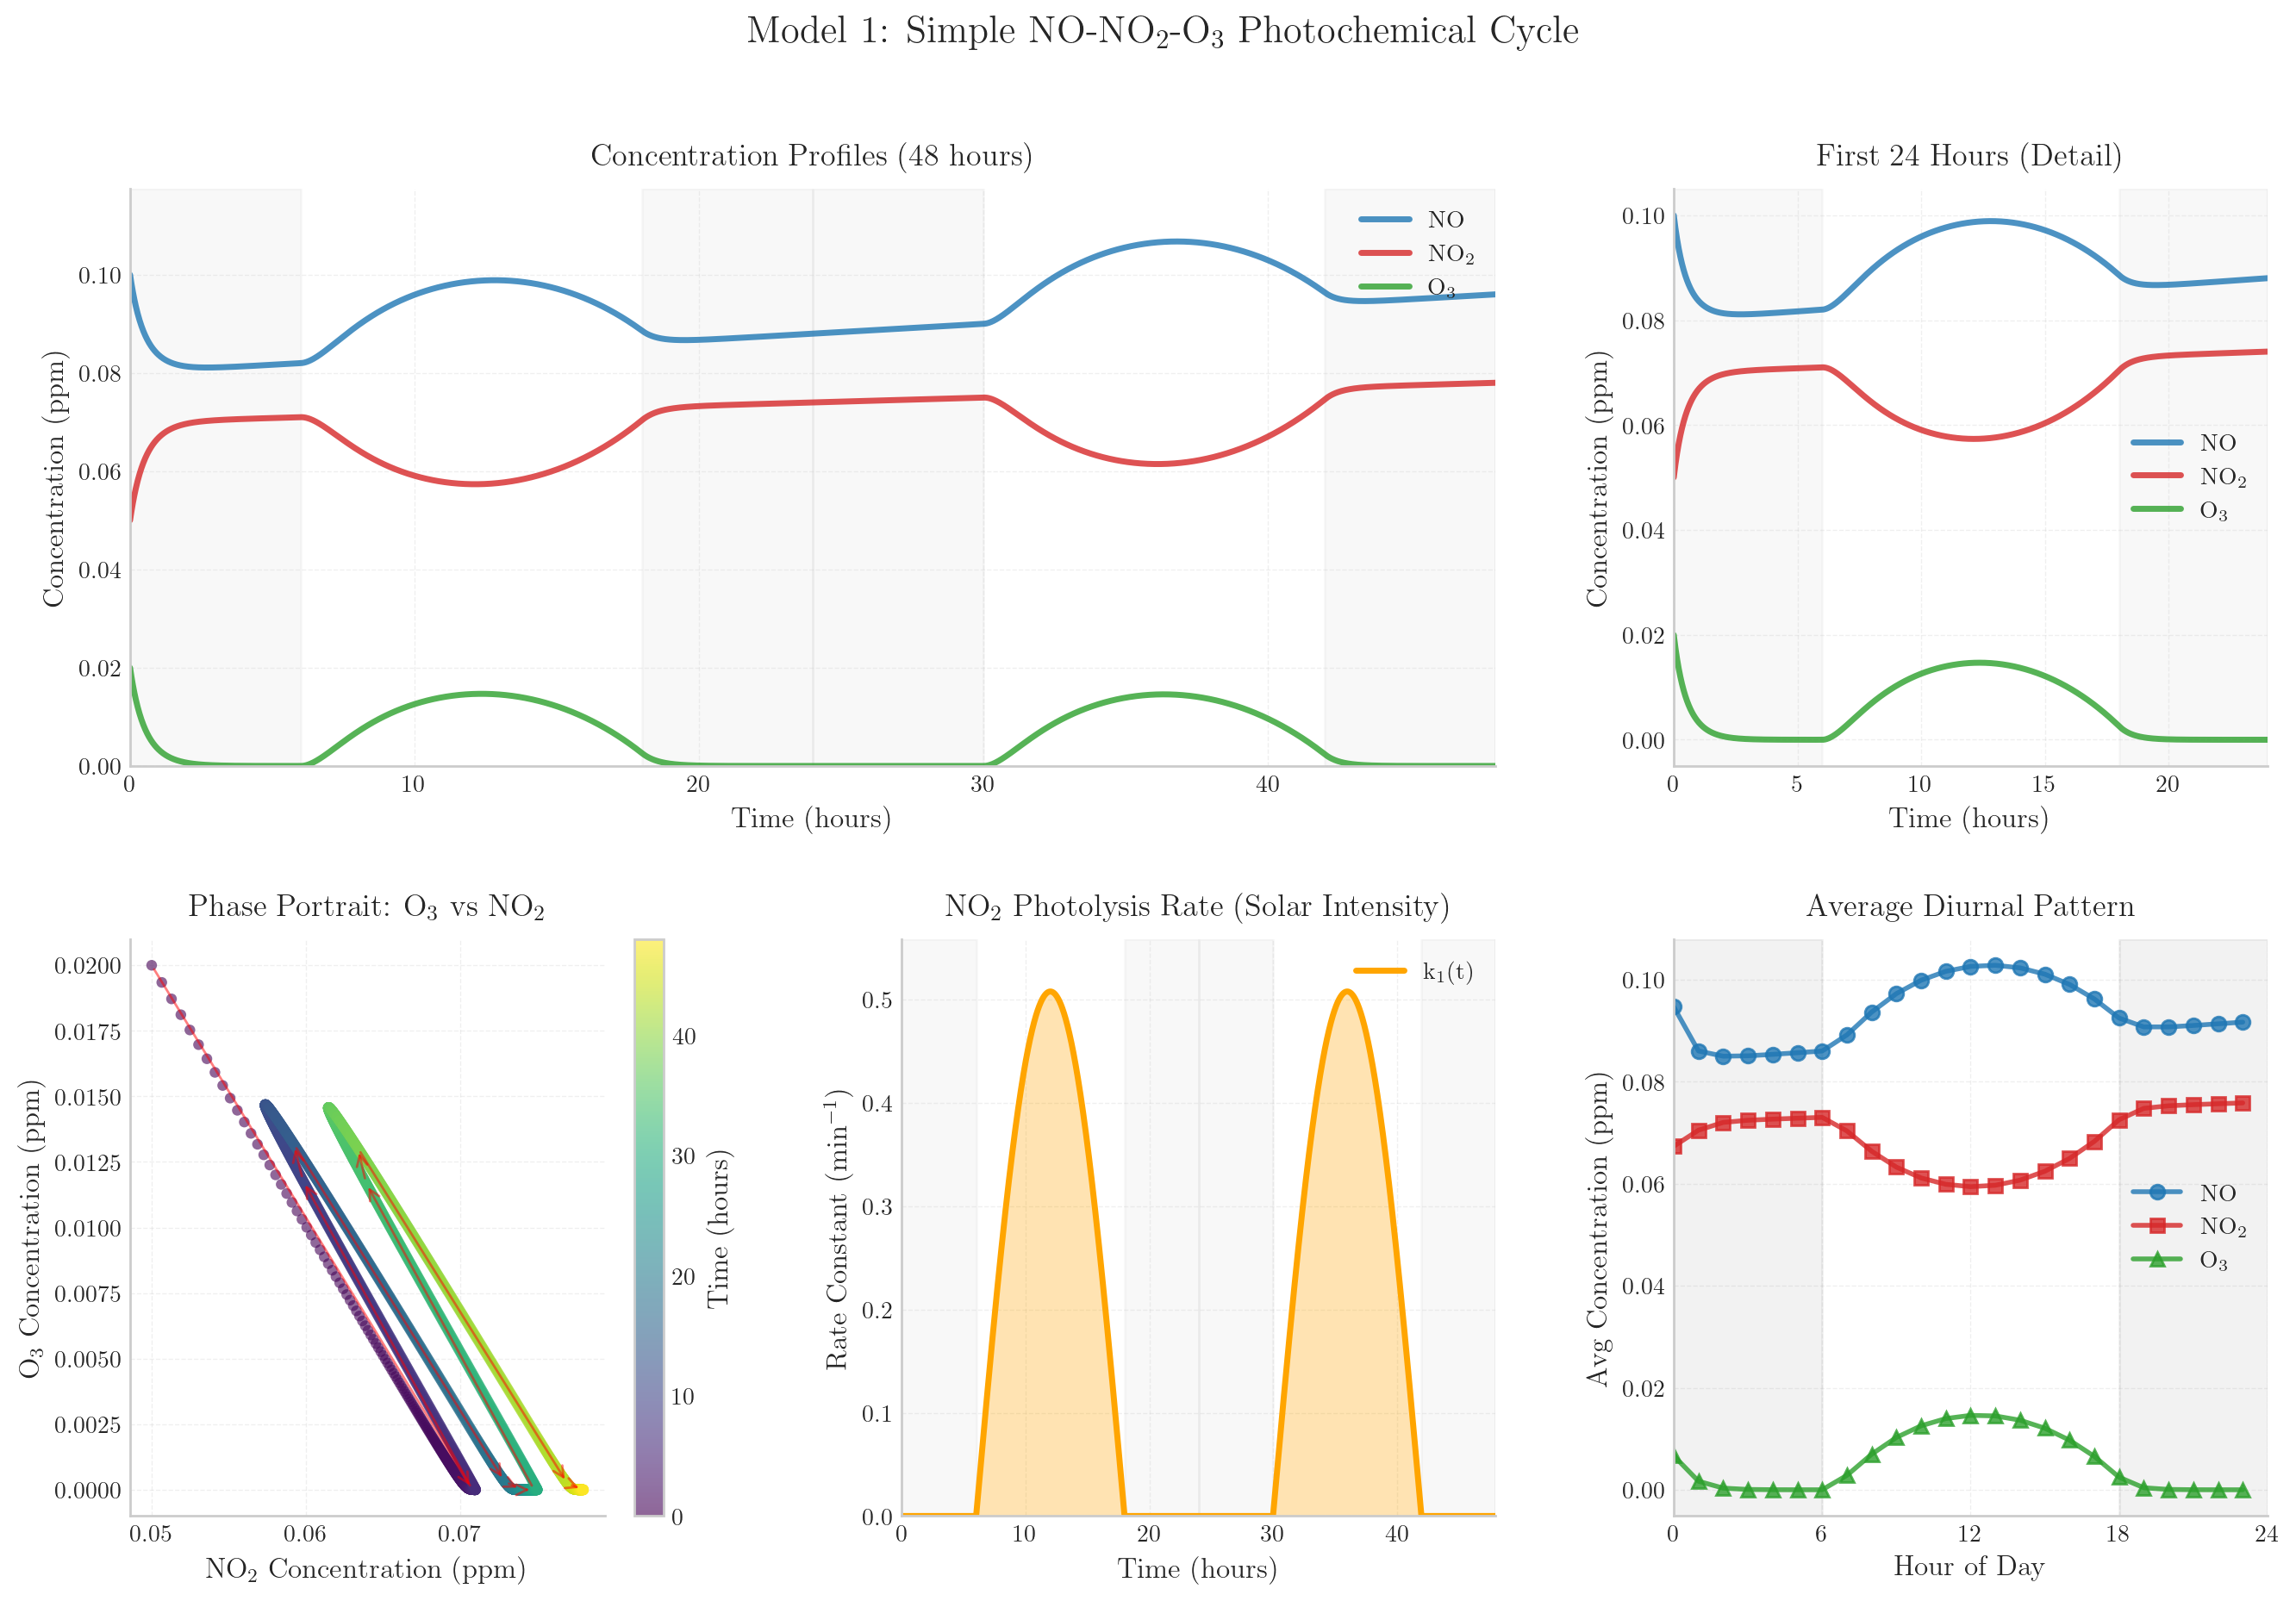


MODEL 2: EXTENDED CHEMISTRY WITH VOCs
Solving ODEs using LSODA algorithm...

Results:
  Peak O3: 0.3026 ppm at t = 32.8 hours
  Peak OH: 4.16e-03 ppm at t = 37.2 hours
  Peak HO₂: 1.52e-03 ppm at t = 35.2 hours
  Min NO: 0.0000 ppm


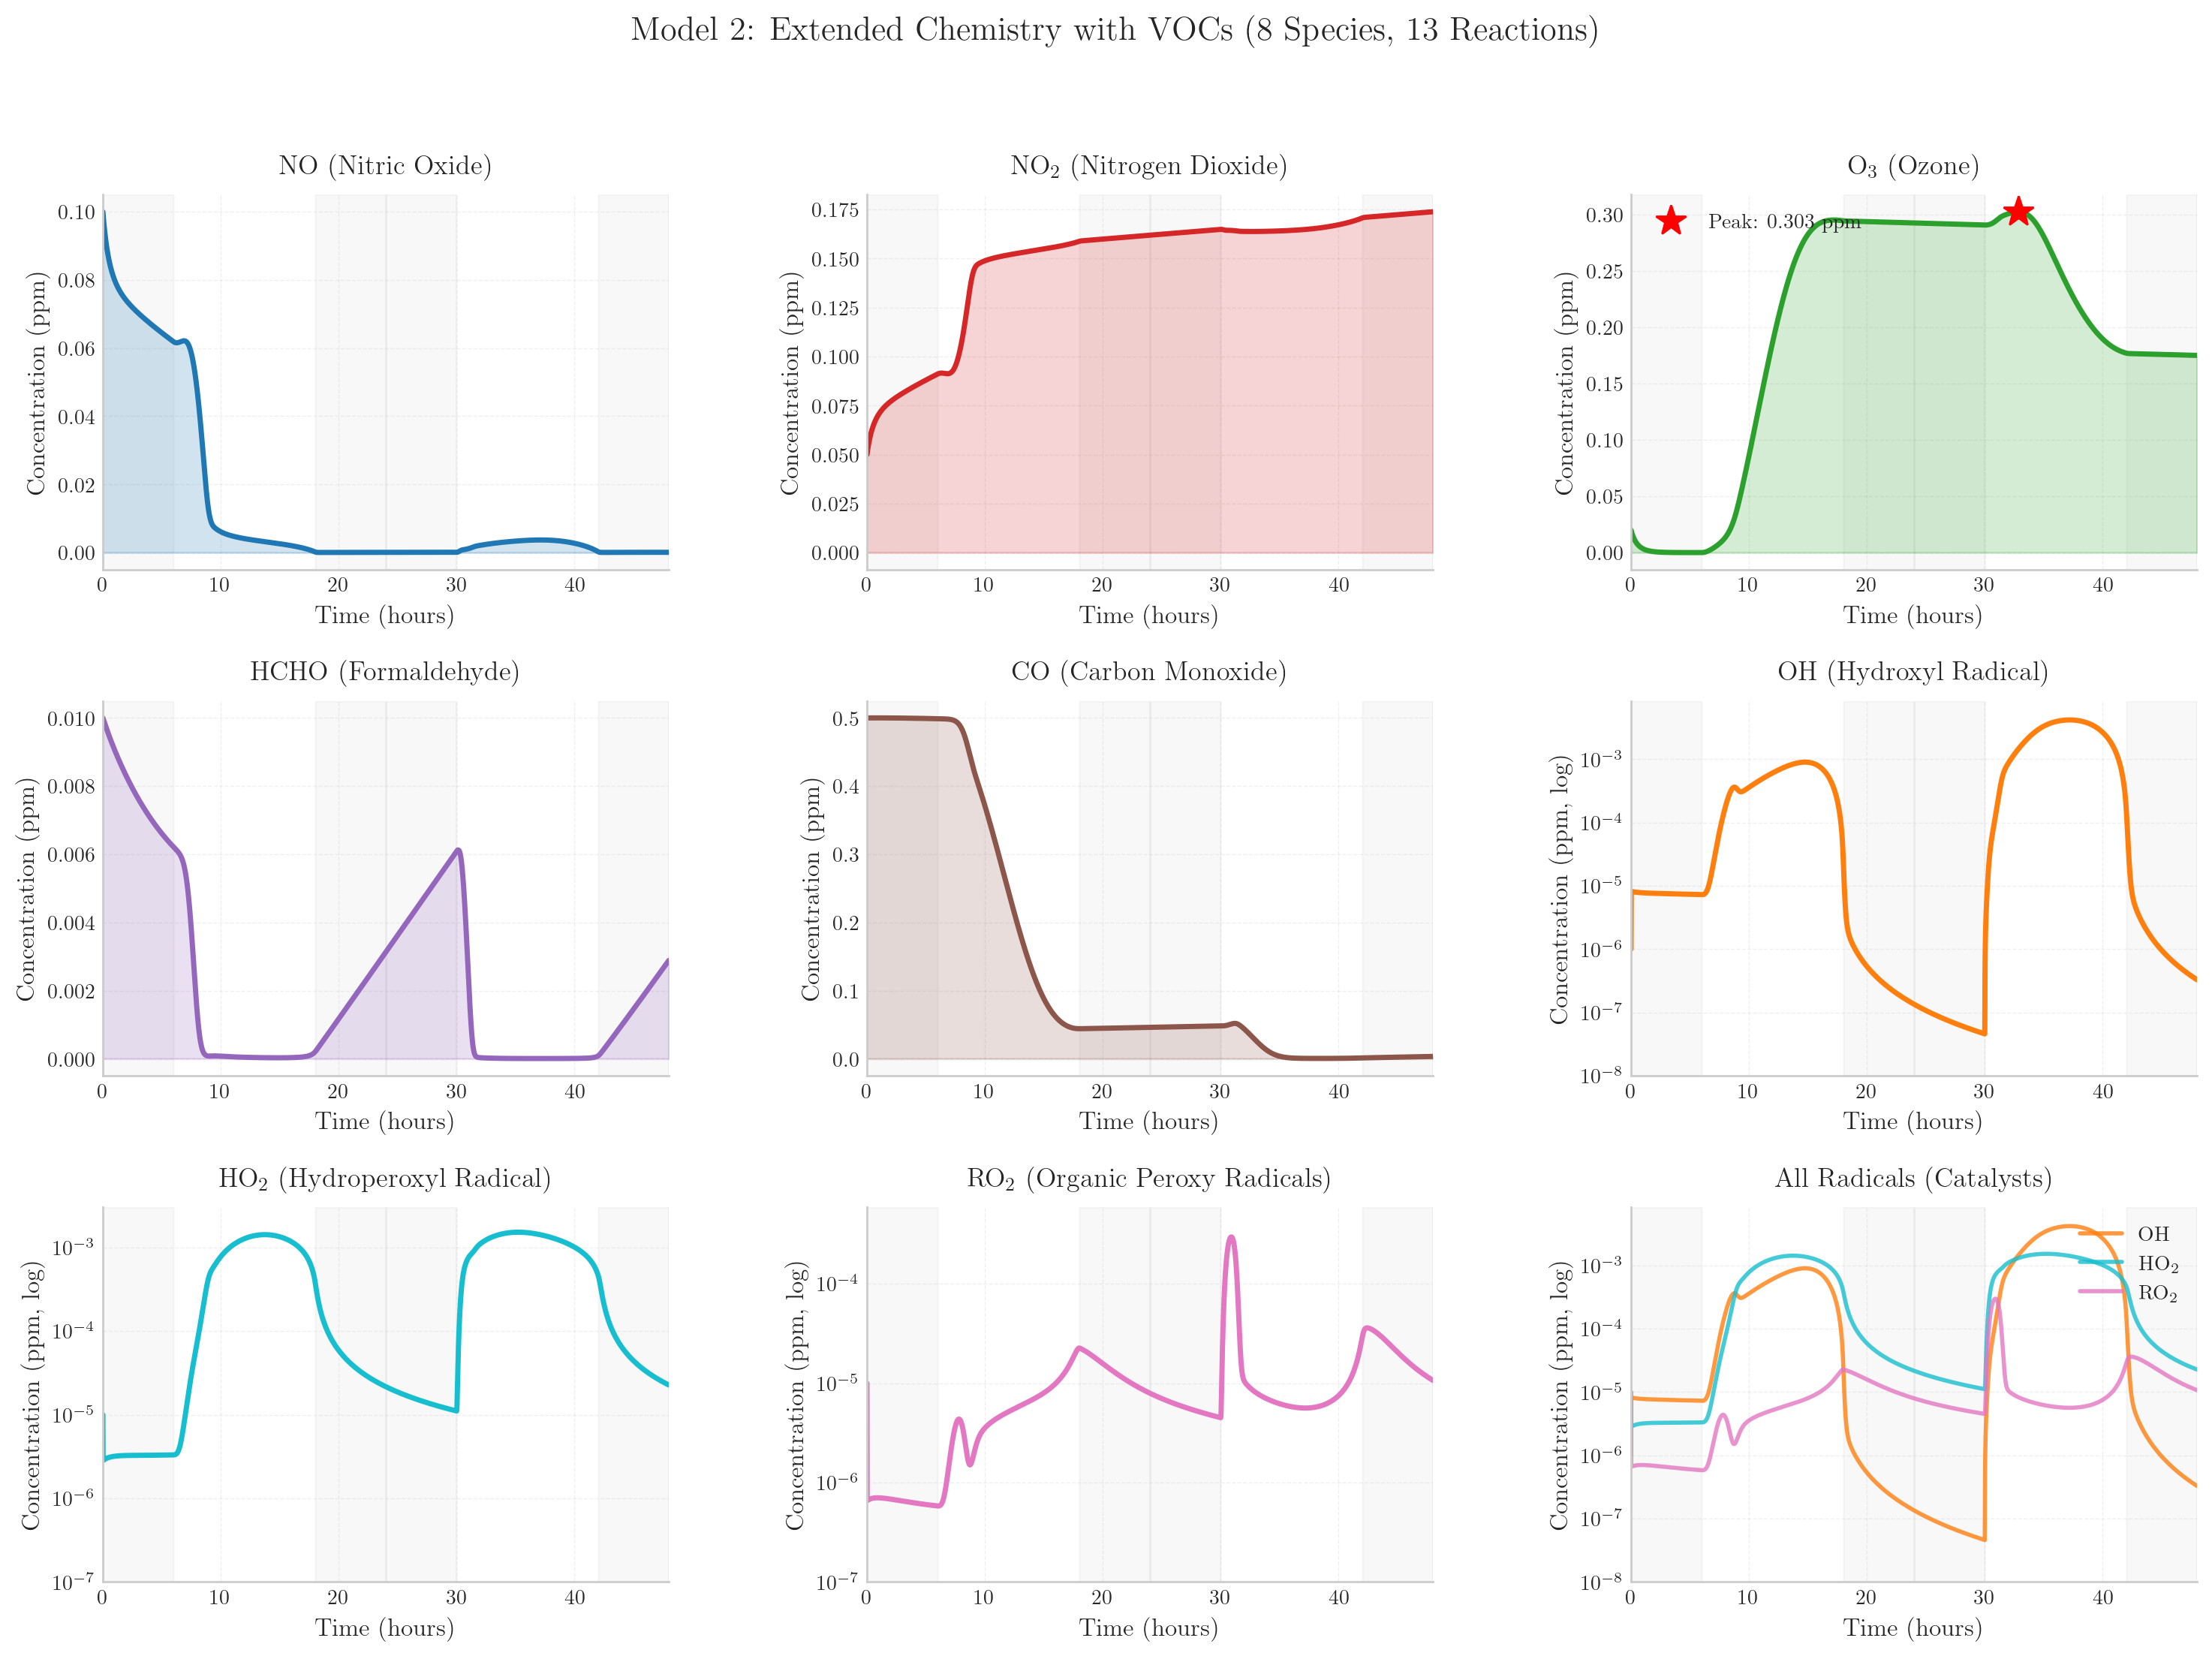


CREATING MODEL COMPARISON


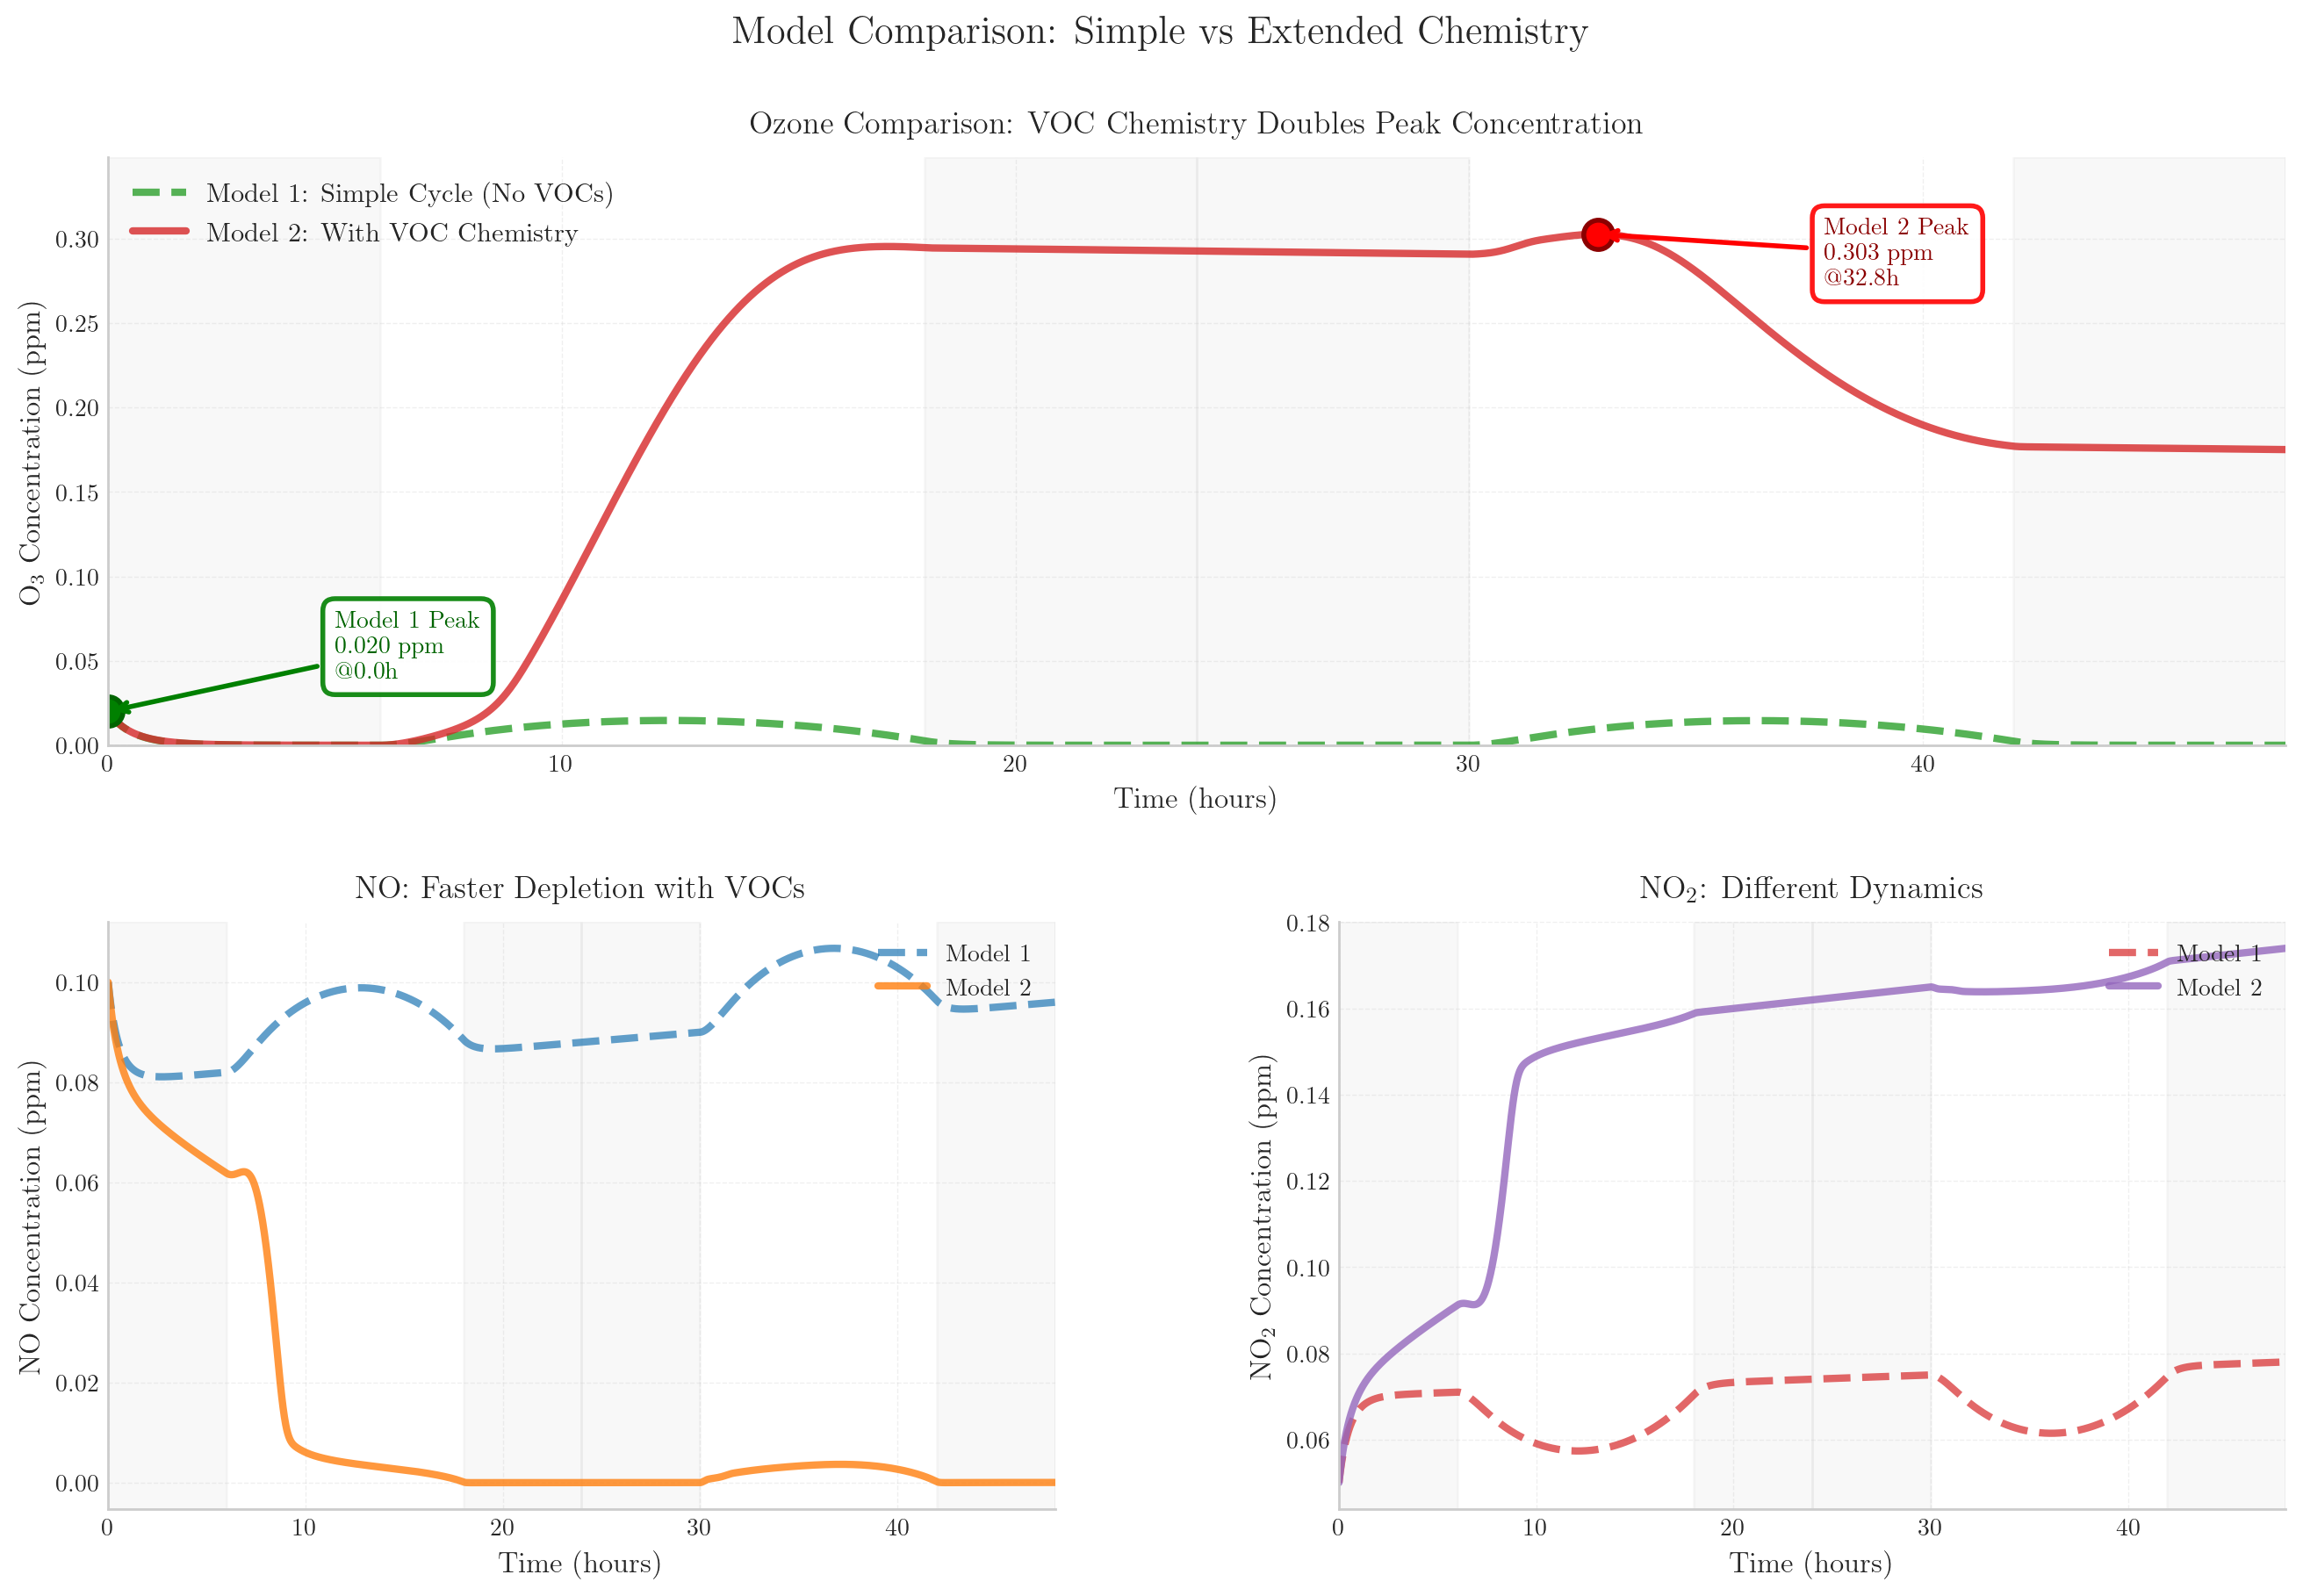


----------------------------------------------------------------------
QUANTITATIVE COMPARISON
----------------------------------------------------------------------
Metric                                   Model 1         Model 2        
----------------------------------------------------------------------
Peak O₃ (ppm)                            0.0200          0.3026         
Peak O₃ time (hours)                     0.0             32.8           
O₃ enhancement factor                    1.0×            15.13          ×
Min NO (ppm)                             0.0811          0.0000         
Peak NO₂ (ppm)                           0.0780          0.1739         
Final O₃ at 48h (ppm)                    0.0000          0.1751         
----------------------------------------------------------------------

CREATING PUBLICATION-QUALITY FIGURE
Running Model 1...
Running Model 2...
✓ Simulations complete
Creating figure...


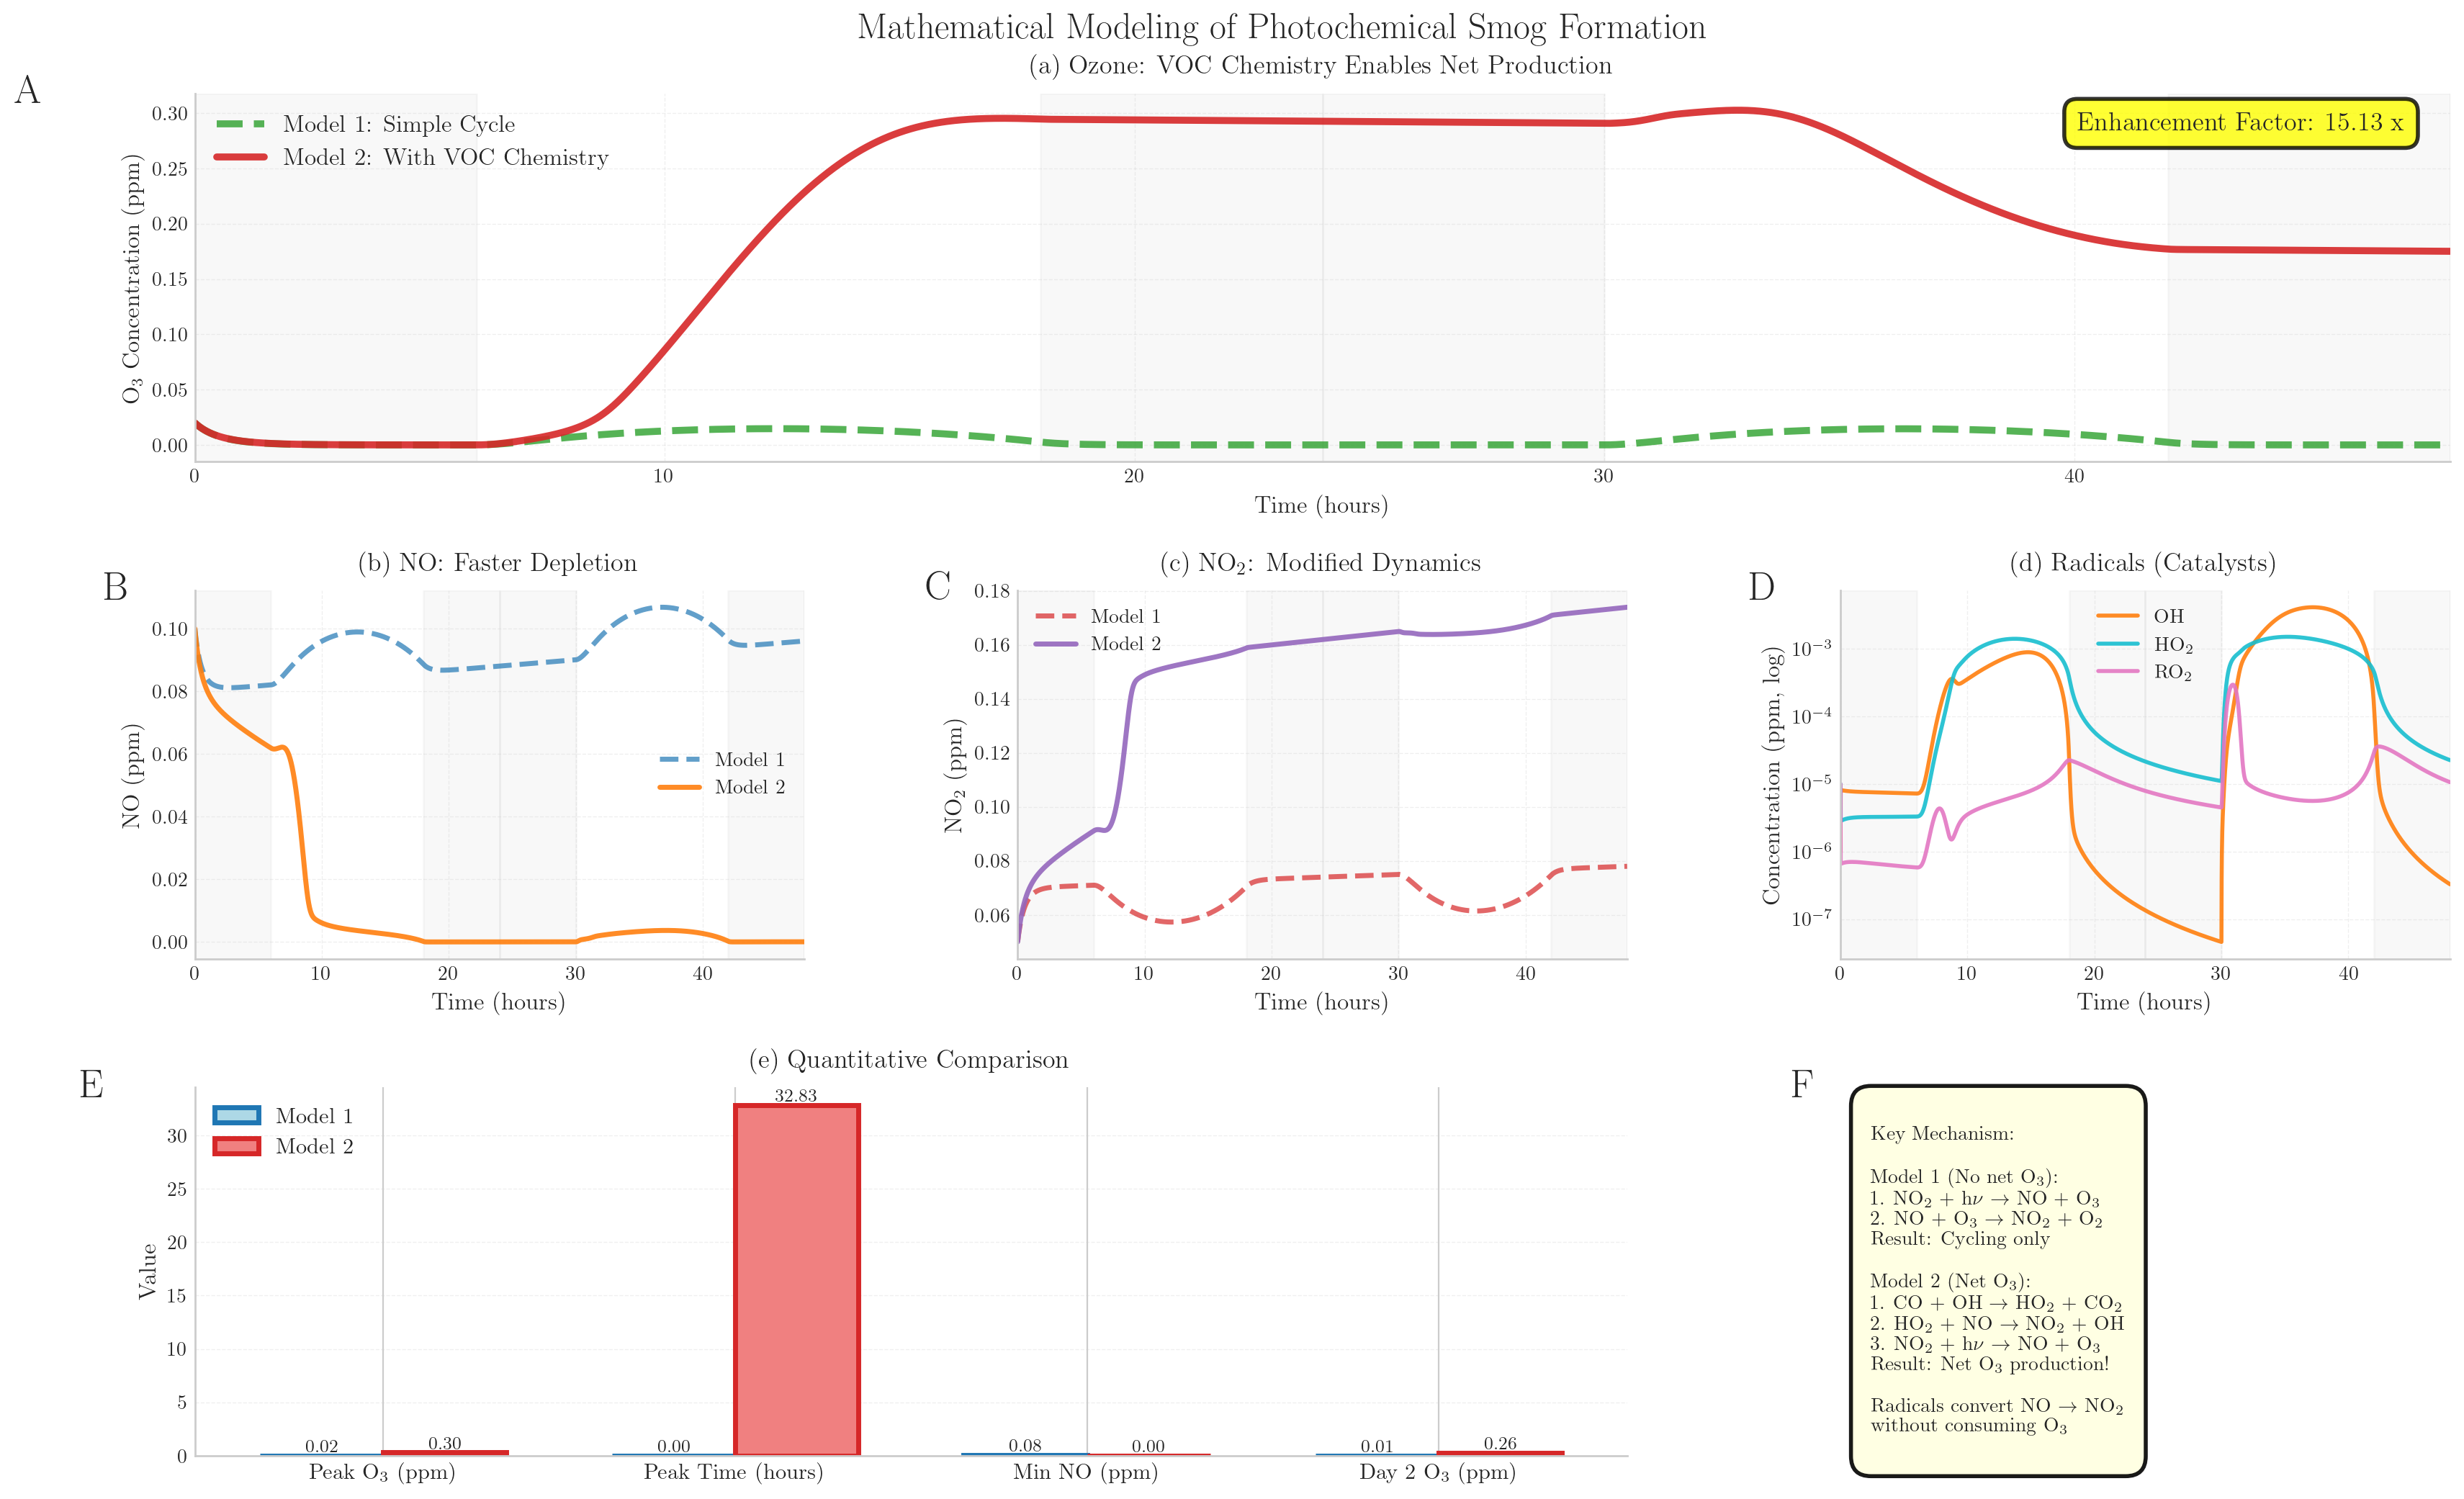


SENSITIVITY ANALYSIS: EMISSION RATES
Running simulations across emission space...
  NOx range: 0.2× to 2.0× base
  VOC range: 0.2× to 2.0× base
  Progress: 50/225 (22%)
  Progress: 100/225 (44%)
  Progress: 150/225 (67%)
  Progress: 200/225 (89%)
✓ Simulations complete


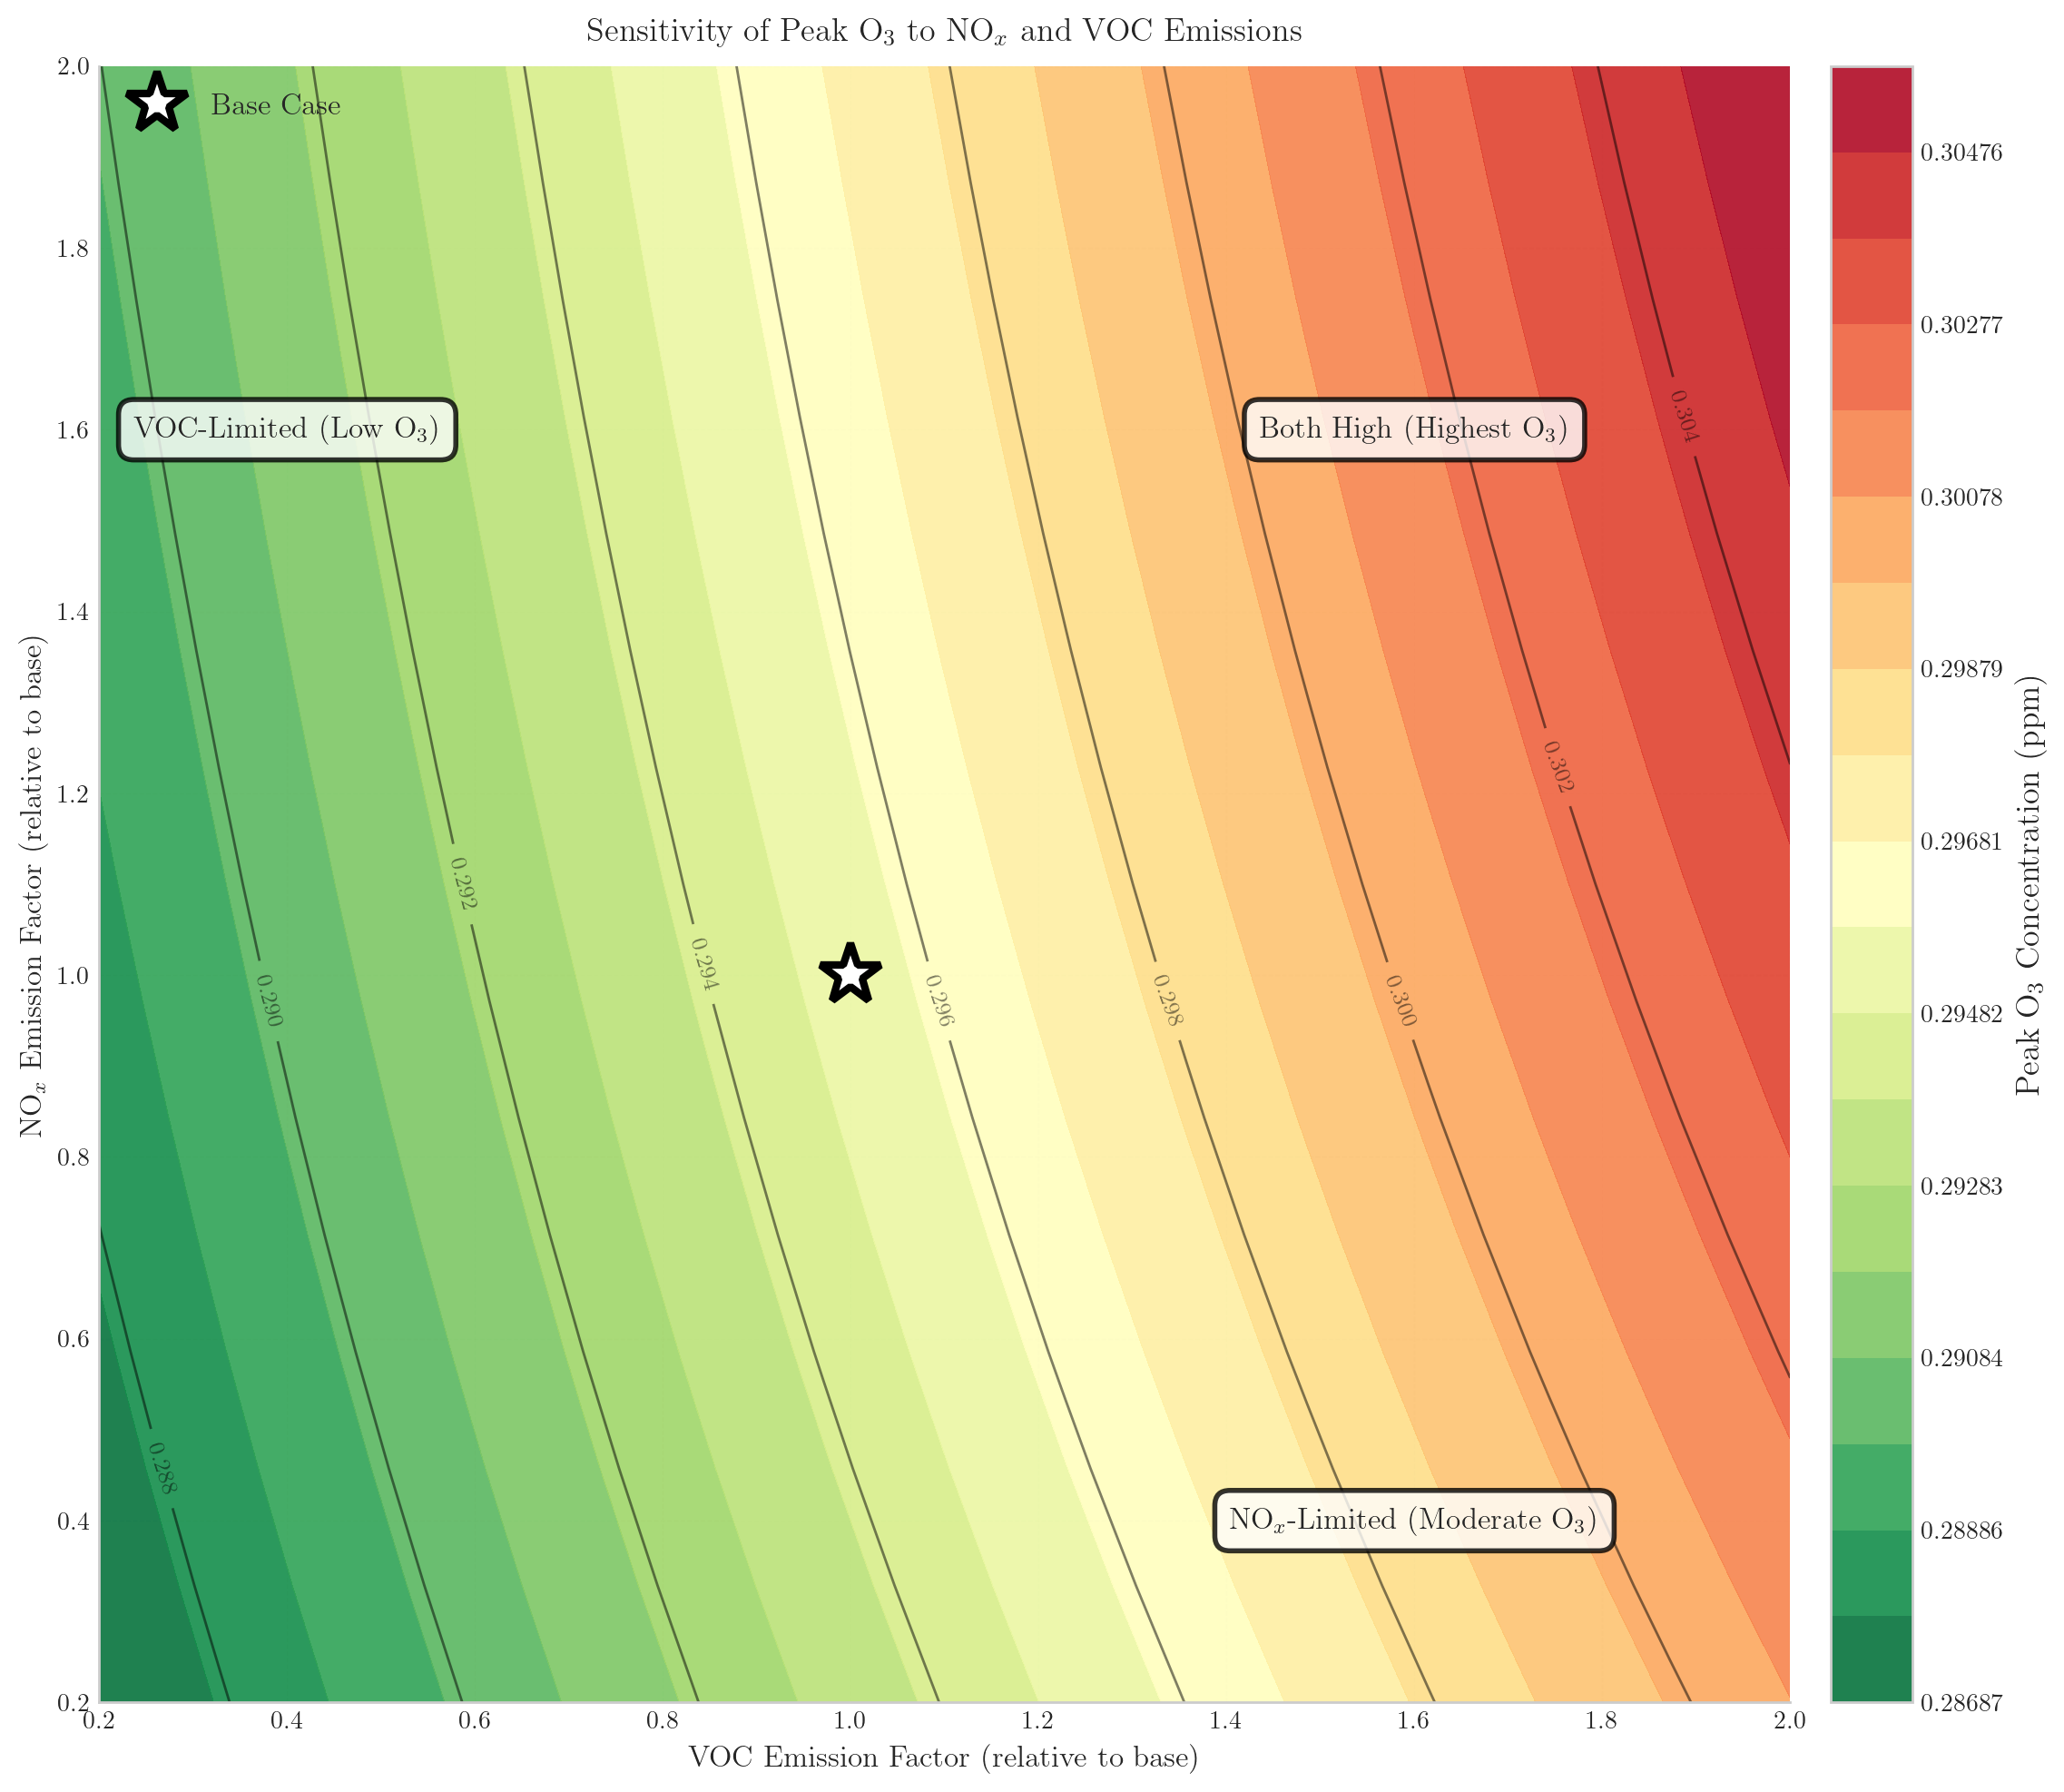


----------------------------------------------------------------------
REGIME ANALYSIS
----------------------------------------------------------------------
VOC-limited (High NOₓ, Low VOC):  0.2919 ppm
NOₓ-limited (Low NOₓ, High VOC):  0.2997 ppm
Balanced (Moderate both):         0.2963 ppm
Both high:                        0.3044 ppm
----------------------------------------------------------------------

Key Insight:
  • Nonlinear response: Peak O₃ depends on NOₓ/VOC ratio
  • In VOC-limited areas, reducing NOₓ may INCREASE O₃!
  • In NOₓ-limited areas, reducing NOₓ DECREASES O₃
  • Policy must be location-specific

SENSITIVITY ANALYSIS: TEMPERATURE
Running temperature sensitivity simulations...
✓ Simulations complete


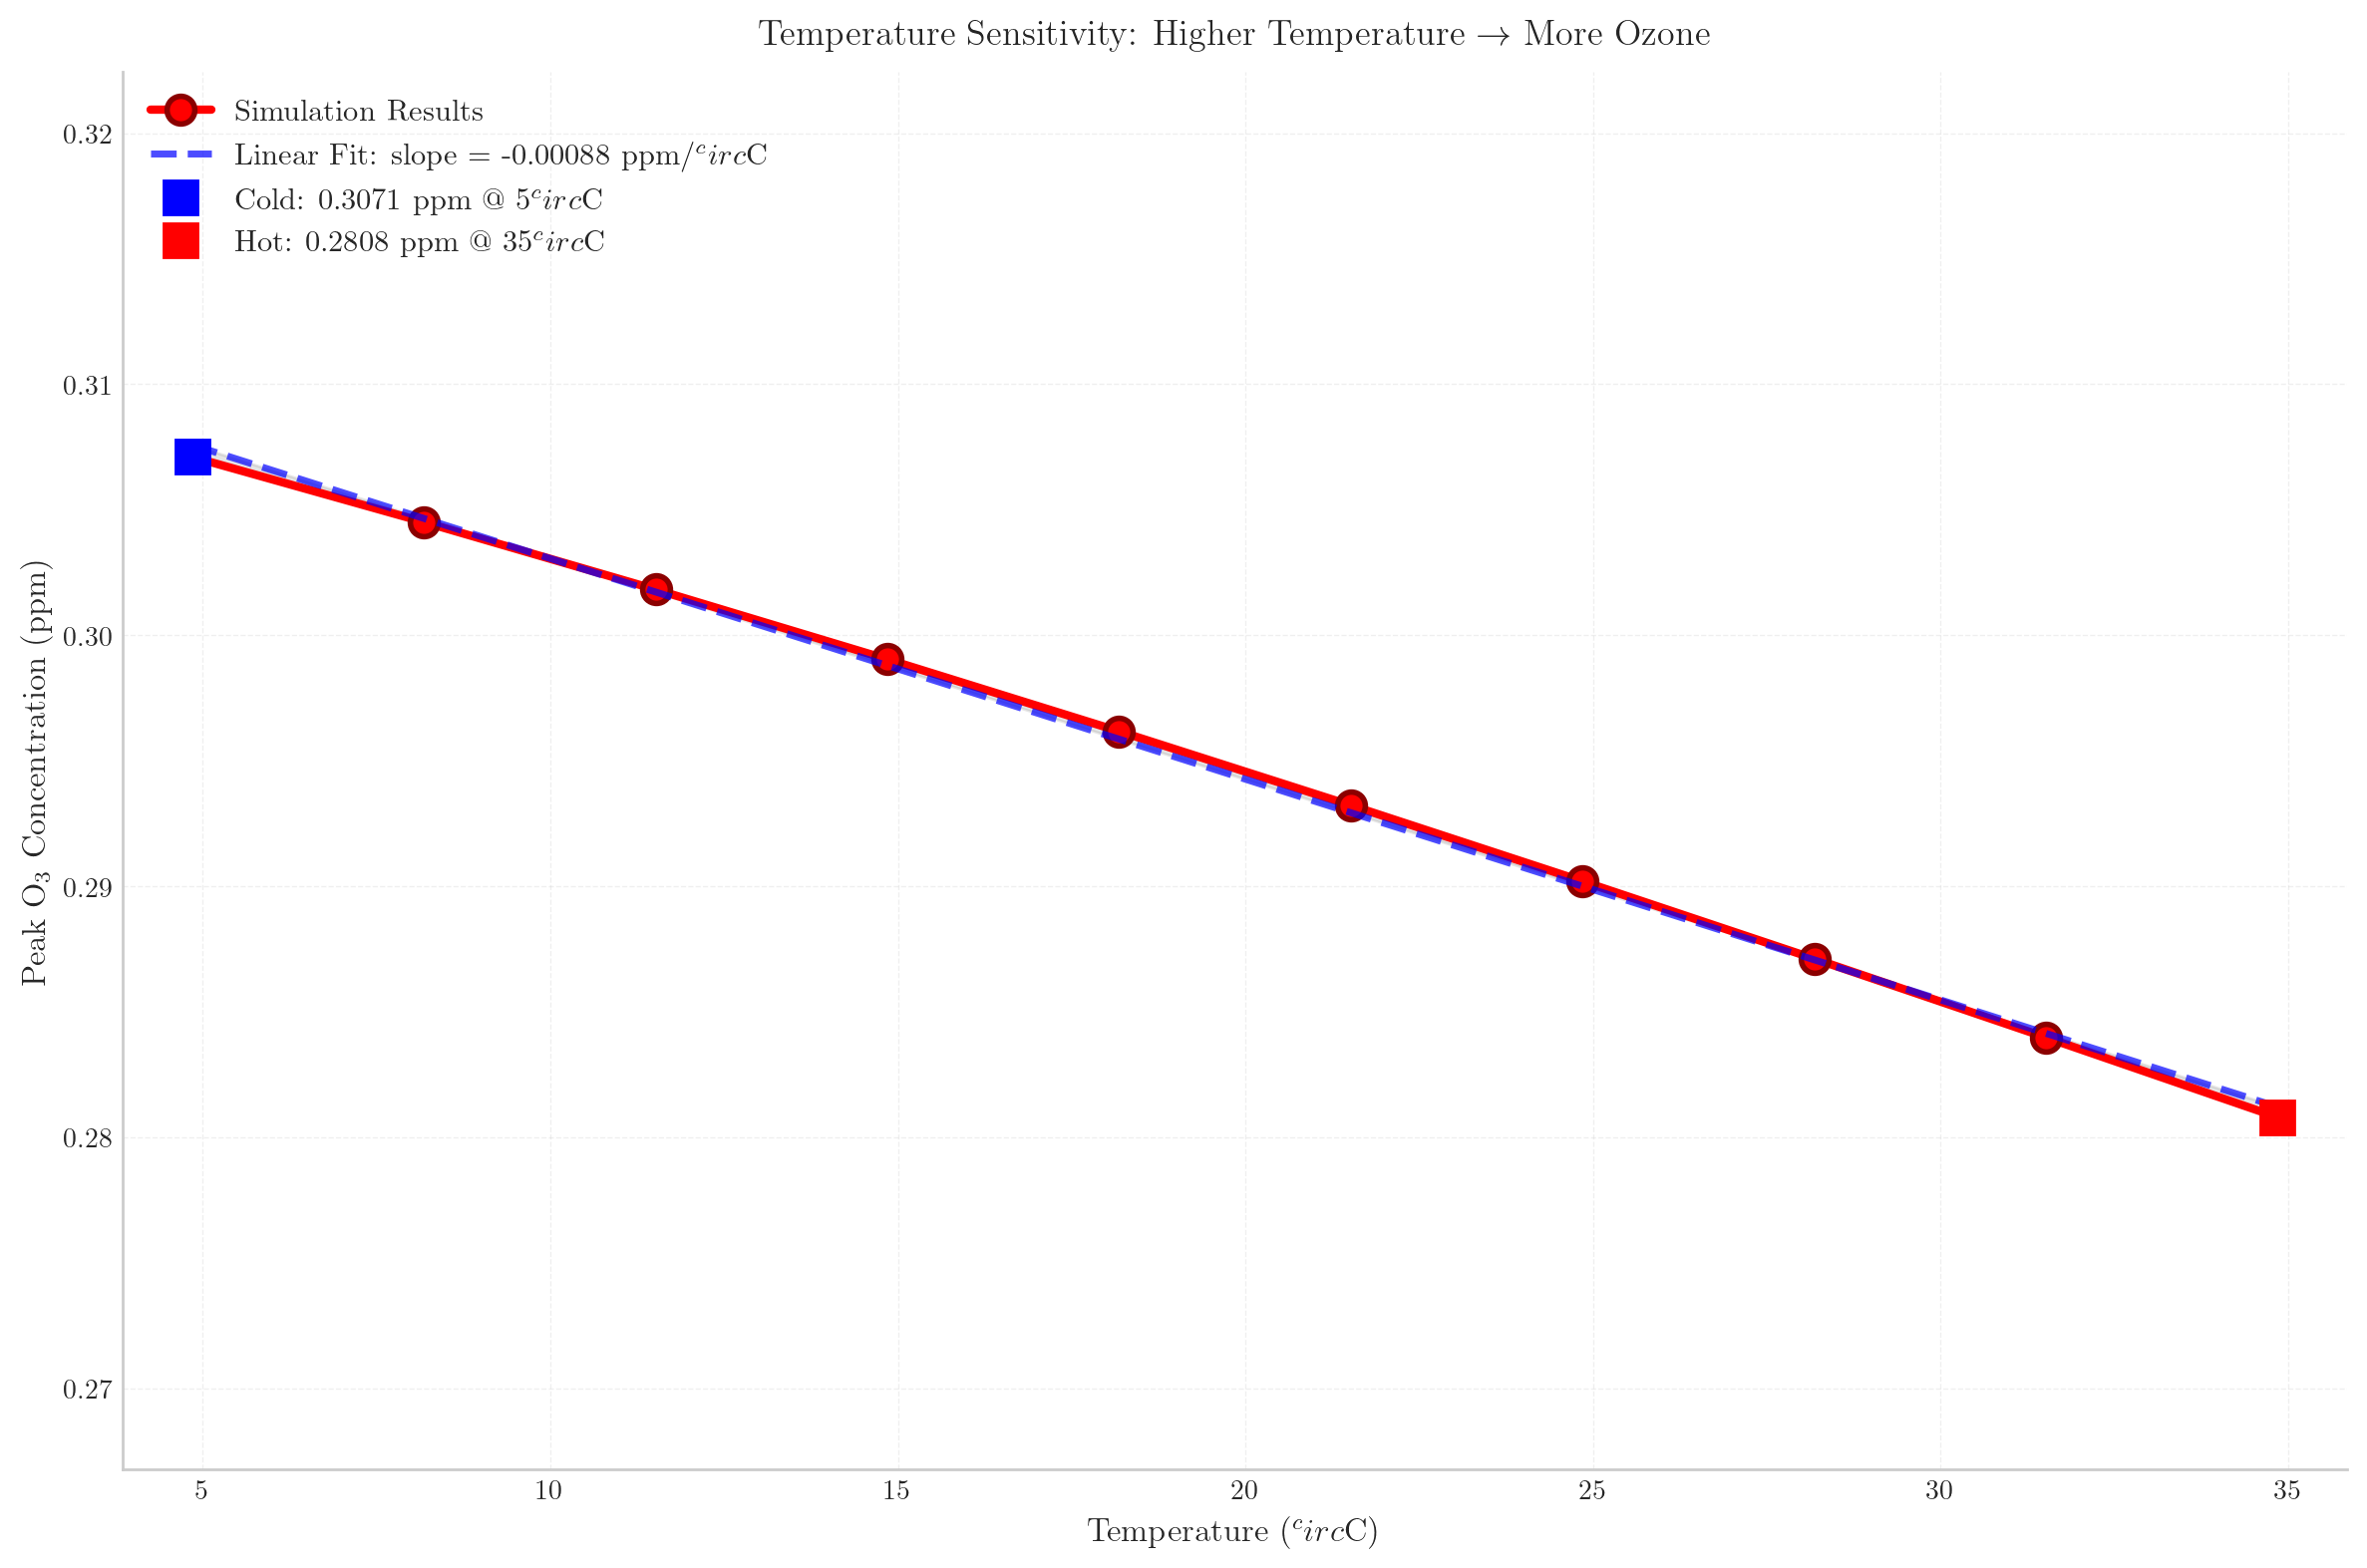


----------------------------------------------------------------------
TEMPERATURE SENSITIVITY STATISTICS
----------------------------------------------------------------------
Temperature range:        4.9°C to 34.9°C
O₃ at lowest temp:        0.3071 ppm
O₃ at highest temp:       0.2808 ppm
Absolute change:          -0.0263 ppm
Relative change:          -8.6%
Change per 10 K:          -2.9%
Ratio (hot/cold):         0.91
----------------------------------------------------------------------

Implication: Heat waves significantly worsen ozone pollution!

                    ALL SIMULATIONS COMPLETED!

Generated Files:
  ✓ model1_concentrations.png      - Model 1 detailed results
  ✓ model2_concentrations.png      - Model 2 detailed results
  ✓ comparison_plot.png             - Direct model comparison
  ✓ publication_figure.png          - Comprehensive summary figure
  ✓ sensitivity_emissions.png       - NOx/VOC sensitivity analysis
  ✓ sensitivity_temperature.png     - Temperature sen

In [25]:
"""
Mathematical Modeling of Photochemical Smog Formation
Final Version with Enhanced Plots

Author: Your Name
Date: 2025
"""

from matplotlib.gridspec import GridSpec
import warnings
warnings.filterwarnings('ignore')

# Set publication-quality plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 11
plt.rcParams['font.family'] = 'serif'
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 14

# Color scheme
COLORS = {
    'NO': '#1f77b4',      # Blue
    'NO2': '#d62728',     # Red
    'O3': '#2ca02c',      # Green
    'HCHO': '#9467bd',    # Purple
    'CO': '#8c564b',      # Brown
    'OH': '#ff7f0e',      # Orange
    'HO2': '#17becf',     # Cyan
    'RO2': '#e377c2',     # Pink
    'night': 'gray'
}

# ============================================================================
# UTILITY FUNCTIONS
# ============================================================================

def solar_intensity(t, k_max):
    """
    Calculate solar intensity factor based on time of day.
    
    Parameters:
    -----------
    t : float
        Time in hours (can be > 24 for multi-day simulations)
    k_max : float
        Maximum rate constant at solar noon
        
    Returns:
    --------
    float : Photolysis rate constant at time t
    """
    hour = t % 24
    if 6 <= hour <= 18:
        return k_max * np.sin(np.pi * (hour - 6) / 12)
    return 0.0

def add_day_night_shading(ax, t_max):
    """Add subtle shading to indicate day/night periods on plot."""
    for day in range(int(t_max // 24) + 1):
        # Night before sunrise (0-6h)
        ax.axvspan(day * 24, day * 24 + 6, alpha=0.05, color=COLORS['night'], zorder=0)
        # Night after sunset (18-24h)
        ax.axvspan(day * 24 + 18, (day + 1) * 24, alpha=0.05, color=COLORS['night'], zorder=0)

def format_axis(ax, xlabel='', ylabel='', title='', grid=True):
    """Apply consistent formatting to axis."""
    if xlabel:
        ax.set_xlabel(xlabel, fontweight='bold')
    if ylabel:
        ax.set_ylabel(ylabel, fontweight='bold')
    if title:
        ax.set_title(title, fontweight='bold', pad=10)
    if grid:
        ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# ============================================================================
# MODEL 1: SIMPLE NO-NO2-O3 PHOTOCHEMICAL CYCLE
# ============================================================================

def model1_odes(y, t, params):
    """
    Model 1: Three-species photochemical cycle (NO, NO2, O3).
    
    Parameters:
    -----------
    y : array
        Concentrations [NO, NO2, O3] in ppm
    t : float
        Time in hours
    params : dict
        Dictionary containing rate constants and emissions
        
    Returns:
    --------
    list : Time derivatives [dNO/dt, dNO2/dt, dO3/dt]
    """
    NO, NO2, O3 = y
    
    # Time-dependent photolysis rate
    k1 = solar_intensity(t, params['k1_max'])
    k3 = params['k3']
    E_NO = params['E_NO']
    E_NO2 = params['E_NO2']
    
    # Differential equations
    dNO_dt = k1 * NO2 - k3 * NO * O3 + E_NO
    dNO2_dt = -k1 * NO2 + k3 * NO * O3 + E_NO2
    dO3_dt = k1 * NO2 - k3 * NO * O3
    
    return [dNO_dt, dNO2_dt, dO3_dt]

def run_model1():
    """Run Model 1 simulation and create enhanced plots."""
    print("\n" + "="*70)
    print("MODEL 1: SIMPLE PHOTOCHEMICAL CYCLE (NO-NO₂-O₃)")
    print("="*70)
    
    # Parameters
    params = {
        'k1_max': 0.508,      # min^-1 (maximum NO2 photolysis rate)
        'k3': 20.0,           # ppm^-1 min^-1 (NO + O3 reaction)
        'E_NO': 0.02 / 60,    # ppm/min (converted from ppm/h)
        'E_NO2': 0.01 / 60    # ppm/min
    }
    
    # Initial conditions (ppm)
    y0 = [0.100, 0.050, 0.020]  # NO, NO2, O3
    
    # Time array (0 to 48 hours, 1-minute resolution)
    t = np.linspace(0, 48, 48 * 60 + 1)
    
    # Solve ODEs
    print("Solving ODEs using LSODA algorithm...")
    solution = odeint(model1_odes, y0, t, args=(params,))
    
    NO = solution[:, 0]
    NO2 = solution[:, 1]
    O3 = solution[:, 2]
    
    # Print statistics
    print(f"\nResults:")
    print(f"  Peak O3: {O3.max():.4f} ppm at t = {t[O3.argmax()]:.1f} hours")
    print(f"  Peak NO₂: {NO2.max():.4f} ppm at t = {t[NO2.argmax()]:.1f} hours")
    print(f"  Min NO: {NO.min():.4f} ppm at t = {t[NO.argmin()]:.1f} hours")
    
    # Verify photostationary state
    midday_idx = np.argmin(np.abs(t - 12.0))
    if NO2[midday_idx] > 0:
        phi_sim = (NO[midday_idx] * O3[midday_idx]) / NO2[midday_idx]
        phi_pred = params['k1_max'] / params['k3']
        print(f"\nPhotostationary State (noon, day 1):")
        print(f"  Predicted φ = k₁/k₃ = {phi_pred:.4f} ppm")
        print(f"  Simulated φ = [NO][O₃]/[NO₂] = {phi_sim:.4f} ppm")
        print(f"  Agreement: {(1 - abs(phi_sim - phi_pred)/phi_pred)*100:.1f}%")
    
    # Create figure
    fig = plt.figure(figsize=(16, 10))
    gs = GridSpec(2, 3, figure=fig, hspace=0.3, wspace=0.3)
    
    fig.suptitle(r'Model 1: Simple NO-NO$_2$-O$_3$ Photochemical Cycle', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    # Plot 1: All concentrations (48 hours)
    ax1 = fig.add_subplot(gs[0, :2])
    ax1.plot(t, NO, color=COLORS['NO'], linewidth=2.5, label='NO', alpha=0.8)
    ax1.plot(t, NO2, color=COLORS['NO2'], linewidth=2.5, label=r'NO$_2$', alpha=0.8)
    ax1.plot(t, O3, color=COLORS['O3'], linewidth=2.5, label=r'O$_3$', alpha=0.8)
    add_day_night_shading(ax1, 48)
    format_axis(ax1, 'Time (hours)', 'Concentration (ppm)', 
                'Concentration Profiles (48 hours)')
    ax1.legend(loc='upper right', framealpha=0.95)
    ax1.set_xlim(0, 48)
    ax1.set_ylim(0, max(NO2.max(), O3.max(), NO.max()) * 1.1)
    
    # Plot 2: First 24 hours detail
    ax2 = fig.add_subplot(gs[0, 2])
    mask_24h = t <= 24
    ax2.plot(t[mask_24h], NO[mask_24h], color=COLORS['NO'], linewidth=2.5, label='NO', alpha=0.8)
    ax2.plot(t[mask_24h], NO2[mask_24h], color=COLORS['NO2'], linewidth=2.5, label=r'NO$_2$', alpha=0.8)
    ax2.plot(t[mask_24h], O3[mask_24h], color=COLORS['O3'], linewidth=2.5, label=r'O$_3$', alpha=0.8)
    add_day_night_shading(ax2, 24)
    format_axis(ax2, 'Time (hours)', 'Concentration (ppm)', 
                'First 24 Hours (Detail)')
    ax2.legend(loc='best', framealpha=0.95)
    ax2.set_xlim(0, 24)
    
    # Plot 3: Phase portrait (O3 vs NO2)
    ax3 = fig.add_subplot(gs[1, 0])
    scatter = ax3.scatter(NO2, O3, c=t, cmap='viridis', s=20, alpha=0.6, edgecolors='none')
    format_axis(ax3, r'NO$_2$ Concentration (ppm)', r'O$_3$ Concentration (ppm)', 
                r'Phase Portrait: O$_3$ vs NO$_2$')
    cbar = plt.colorbar(scatter, ax=ax3, label='Time (hours)')
    
    # Add arrows to show direction
    step = len(t) // 10
    for i in range(0, len(t) - step, step):
        ax3.annotate('', xy=(NO2[i+step], O3[i+step]), xytext=(NO2[i], O3[i]),
                    arrowprops=dict(arrowstyle='->', color='red', lw=1, alpha=0.5))
    
    # Plot 4: Photolysis rate
    ax4 = fig.add_subplot(gs[1, 1])
    k1_values = np.array([solar_intensity(ti, params['k1_max']) for ti in t])
    ax4.fill_between(t, 0, k1_values, color='orange', alpha=0.3)
    ax4.plot(t, k1_values, color='orange', linewidth=2.5, label=r'k$_1$(t)')
    add_day_night_shading(ax4, 48)
    format_axis(ax4, 'Time (hours)', r'Rate Constant (min$^{-1}$)', 
                r'NO$_2$ Photolysis Rate (Solar Intensity)')
    ax4.legend(loc='upper right', framealpha=0.95)
    ax4.set_xlim(0, 48)
    ax4.set_ylim(0, params['k1_max'] * 1.1)
    
    # Plot 5: Diurnal averages
    ax5 = fig.add_subplot(gs[1, 2])
    
    # Calculate hourly averages
    hours = np.arange(24)
    NO_avg = np.array([NO[t % 24 == h].mean() for h in hours])
    NO2_avg = np.array([NO2[t % 24 == h].mean() for h in hours])
    O3_avg = np.array([O3[t % 24 == h].mean() for h in hours])
    
    ax5.plot(hours, NO_avg, 'o-', color=COLORS['NO'], linewidth=2, 
             markersize=6, label='NO', alpha=0.8)
    ax5.plot(hours, NO2_avg, 's-', color=COLORS['NO2'], linewidth=2, 
             markersize=6, label=r'NO$_2$', alpha=0.8)
    ax5.plot(hours, O3_avg, '^-', color=COLORS['O3'], linewidth=2, 
             markersize=6, label=r'O$_3$', alpha=0.8)
    ax5.axvspan(0, 6, alpha=0.1, color='gray')
    ax5.axvspan(18, 24, alpha=0.1, color='gray')
    format_axis(ax5, 'Hour of Day', 'Avg Concentration (ppm)', 
                'Average Diurnal Pattern')
    ax5.legend(loc='best', framealpha=0.95)
    ax5.set_xlim(0, 24)
    ax5.set_xticks([0, 6, 12, 18, 24])
    
    plt.tight_layout()
    # plt.savefig('model1_concentrations.png', dpi=300, bbox_inches='tight')
    # print("\n✓ Plot saved: model1_concentrations.png")
    plt.show()
    
    return t, solution, params

# ============================================================================
# MODEL 2: EXTENDED CHEMISTRY WITH VOCs
# ============================================================================

def model2_odes(y, t, params):
    """
    Model 2: Eight-species system with VOC chemistry.
    Species: NO, NO2, O3, HCHO, CO, OH, HO2, RO2
    """
    NO, NO2, O3, HCHO, CO, OH, HO2, RO2 = y
    
    # Time-dependent photolysis rates
    k1 = solar_intensity(t, params['k1_max'])
    k20 = solar_intensity(t, params['k20_max'])
    k21 = solar_intensity(t, params['k21_max'])
    
    # Extract parameters
    k3 = params['k3']
    k15 = params['k15']
    k16 = params['k16']
    k19 = params['k19']
    k23 = params['k23']
    k47 = params['k47']
    k50 = params['k50']
    E_NO = params['E_NO']
    E_NO2 = params['E_NO2']
    E_HCHO = params['E_HCHO']
    E_CO = params['E_CO']
    
    # Compute reaction rates
    R1 = k1 * NO2
    R3 = k3 * NO * O3
    R15 = k15 * NO * HO2
    R16 = k16 * NO * RO2
    R19 = k19 * CO * OH
    R20 = k20 * O3
    R21 = k21 * HCHO
    R23 = k23 * HCHO * OH
    R47 = k47 * O3 * OH
    R50 = k50 * HO2 * HO2
    
    # Differential equations
    dNO_dt = R1 - R3 - R15 - R16 + E_NO
    dNO2_dt = -R1 + R3 + R15 + R16 + E_NO2
    dO3_dt = R1 - R3 - R20 - R47
    dHCHO_dt = -R21 - R23 + E_HCHO
    dCO_dt = R21 + R23 - R19 + E_CO
    dOH_dt = 2*R20 - R19 - R23 + R15 - R47
    dHO2_dt = 2*R21 + R23 + R19 - R15 - 2*R50 + R47
    dRO2_dt = 0.5 * R23 - R16
    
    return [dNO_dt, dNO2_dt, dO3_dt, dHCHO_dt, dCO_dt, 
            dOH_dt, dHO2_dt, dRO2_dt]

def run_model2():
    """Run Model 2 simulation and create enhanced plots."""
    print("\n" + "="*70)
    print("MODEL 2: EXTENDED CHEMISTRY WITH VOCs")
    print("="*70)
    
    # Parameters
    params = {
        'k1_max': 0.508,
        'k20_max': 0.0328,
        'k21_max': 0.00284,
        'k3': 20.0,
        'k15': 12000.0,
        'k16': 12000.0,
        'k19': 440.0,
        'k23': 19200.0,
        'k47': 78.0,
        'k50': 3700.0,
        'E_NO': 0.02 / 60,
        'E_NO2': 0.01 / 60,
        'E_HCHO': 0.03 / 60,
        'E_CO': 0.02 / 60
    }
    
    # Initial conditions (ppm)
    y0 = [0.100, 0.050, 0.020, 0.010, 0.500, 1.0e-6, 1.0e-5, 1.0e-5]
    
    # Time array
    t = np.linspace(0, 48, 48 * 60 + 1)
    
    # Solve ODEs
    print("Solving ODEs using LSODA algorithm...")
    solution = odeint(model2_odes, y0, t, args=(params,), rtol=1e-6, atol=1e-9)
    
    NO, NO2, O3 = solution[:, 0], solution[:, 1], solution[:, 2]
    HCHO, CO = solution[:, 3], solution[:, 4]
    OH, HO2, RO2 = solution[:, 5], solution[:, 6], solution[:, 7]
    
    # Print statistics
    print(f"\nResults:")
    print(f"  Peak O3: {O3.max():.4f} ppm at t = {t[O3.argmax()]:.1f} hours")
    print(f"  Peak OH: {OH.max():.2e} ppm at t = {t[OH.argmax()]:.1f} hours")
    print(f"  Peak HO₂: {HO2.max():.2e} ppm at t = {t[HO2.argmax()]:.1f} hours")
    print(f"  Min NO: {NO.min():.4f} ppm")
    
    # Create comprehensive figure
    fig = plt.figure(figsize=(18, 12))
    gs = GridSpec(3, 3, figure=fig, hspace=0.35, wspace=0.35)
    
    fig.suptitle('Model 2: Extended Chemistry with VOCs (8 Species, 13 Reactions)', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    # Plot 1: NO
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(t, NO, color=COLORS['NO'], linewidth=2.5)
    ax1.fill_between(t, 0, NO, color=COLORS['NO'], alpha=0.2)
    add_day_night_shading(ax1, 48)
    format_axis(ax1, 'Time (hours)', 'Concentration (ppm)', 'NO (Nitric Oxide)')
    ax1.set_xlim(0, 48)
    
    # Plot 2: NO2
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(t, NO2, color=COLORS['NO2'], linewidth=2.5)
    ax2.fill_between(t, 0, NO2, color=COLORS['NO2'], alpha=0.2)
    add_day_night_shading(ax2, 48)
    format_axis(ax2, 'Time (hours)', 'Concentration (ppm)', r'NO$_2$ (Nitrogen Dioxide)')
    ax2.set_xlim(0, 48)
    
    # Plot 3: O3
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.plot(t, O3, color=COLORS['O3'], linewidth=2.5)
    ax3.fill_between(t, 0, O3, color=COLORS['O3'], alpha=0.2)
    add_day_night_shading(ax3, 48)
    # Highlight peak
    peak_idx = O3.argmax()
    ax3.plot(t[peak_idx], O3[peak_idx], 'r*', markersize=15, 
             label=f'Peak: {O3.max():.3f} ppm')
    format_axis(ax3, 'Time (hours)', 'Concentration (ppm)', r'O$_3$ (Ozone)')
    ax3.legend(loc='upper left')
    ax3.set_xlim(0, 48)
    
    # Plot 4: HCHO
    ax4 = fig.add_subplot(gs[1, 0])
    ax4.plot(t, HCHO, color=COLORS['HCHO'], linewidth=2.5)
    ax4.fill_between(t, 0, HCHO, color=COLORS['HCHO'], alpha=0.2)
    add_day_night_shading(ax4, 48)
    format_axis(ax4, 'Time (hours)', 'Concentration (ppm)', 'HCHO (Formaldehyde)')
    ax4.set_xlim(0, 48)
    
    # Plot 5: CO
    ax5 = fig.add_subplot(gs[1, 1])
    ax5.plot(t, CO, color=COLORS['CO'], linewidth=2.5)
    ax5.fill_between(t, 0, CO, color=COLORS['CO'], alpha=0.2)
    add_day_night_shading(ax5, 48)
    format_axis(ax5, 'Time (hours)', 'Concentration (ppm)', 'CO (Carbon Monoxide)')
    ax5.set_xlim(0, 48)
    
    # Plot 6: OH (log scale)
    ax6 = fig.add_subplot(gs[1, 2])
    ax6.semilogy(t, OH, color=COLORS['OH'], linewidth=2.5)
    add_day_night_shading(ax6, 48)
    format_axis(ax6, 'Time (hours)', 'Concentration (ppm, log)', 'OH (Hydroxyl Radical)')
    ax6.set_xlim(0, 48)
    ax6.set_ylim(1e-8, OH.max() * 2)
    
    # Plot 7: HO2 (log scale)
    ax7 = fig.add_subplot(gs[2, 0])
    ax7.semilogy(t, HO2, color=COLORS['HO2'], linewidth=2.5)
    add_day_night_shading(ax7, 48)
    format_axis(ax7, 'Time (hours)', 'Concentration (ppm, log)', r'HO$_2$ (Hydroperoxyl Radical)')
    ax7.set_xlim(0, 48)
    ax7.set_ylim(1e-7, HO2.max() * 2)
    
    # Plot 8: RO2 (log scale)
    ax8 = fig.add_subplot(gs[2, 1])
    ax8.semilogy(t, RO2, color=COLORS['RO2'], linewidth=2.5)
    add_day_night_shading(ax8, 48)
    format_axis(ax8, 'Time (hours)', 'Concentration (ppm, log)', r'RO$_2$ (Organic Peroxy Radicals)')
    ax8.set_xlim(0, 48)
    ax8.set_ylim(1e-7, RO2.max() * 2)
    
    # Plot 9: All radicals together
    ax9 = fig.add_subplot(gs[2, 2])
    ax9.semilogy(t, OH, color=COLORS['OH'], linewidth=2, label='OH', alpha=0.8)
    ax9.semilogy(t, HO2, color=COLORS['HO2'], linewidth=2, label=r'HO$_2$', alpha=0.8)
    ax9.semilogy(t, RO2, color=COLORS['RO2'], linewidth=2, label=r'RO$_2$', alpha=0.8)
    add_day_night_shading(ax9, 48)
    format_axis(ax9, 'Time (hours)', 'Concentration (ppm, log)', 
                'All Radicals (Catalysts)')
    ax9.legend(loc='upper right', framealpha=0.95)
    ax9.set_xlim(0, 48)
    ax9.set_ylim(1e-8, max(OH.max(), HO2.max(), RO2.max()) * 2)
    
    plt.tight_layout()
    # plt.savefig('model2_concentrations.png', dpi=300, bbox_inches='tight')
    # print("\n✓ Plot saved: model2_concentrations.png")
    plt.show()
    
    return t, solution, params

# ============================================================================
# COMPARISON PLOTS
# ============================================================================

def create_comparison_plots(t1, sol1, params1, t2, sol2, params2):
    """Create comprehensive comparison between Model 1 and Model 2."""
    print("\n" + "="*70)
    print("CREATING MODEL COMPARISON")
    print("="*70)
    
    fig = plt.figure(figsize=(16, 10))
    gs = GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.3)
    
    fig.suptitle('Model Comparison: Simple vs Extended Chemistry', 
                 fontsize=16, fontweight='bold', y=0.96)
    
    # Plot 1: O3 comparison
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(t1, sol1[:, 2], color='#2ca02c', linewidth=3, 
             label='Model 1: Simple Cycle (No VOCs)', alpha=0.8, linestyle='--')
    ax1.plot(t2, sol2[:, 2], color='#d62728', linewidth=3, 
             label='Model 2: With VOC Chemistry', alpha=0.8)
    add_day_night_shading(ax1, 48)
    
    # Mark peaks
    peak1_idx = sol1[:, 2].argmax()
    peak2_idx = sol2[:, 2].argmax()
    ax1.plot(t1[peak1_idx], sol1[peak1_idx, 2], 'go', markersize=12, 
             markeredgecolor='darkgreen', markeredgewidth=2)
    ax1.plot(t2[peak2_idx], sol2[peak2_idx, 2], 'ro', markersize=12, 
             markeredgecolor='darkred', markeredgewidth=2)
    
    # Annotations
    ax1.annotate(f'Model 1 Peak\n{sol1[:, 2].max():.3f} ppm\n@{t1[peak1_idx]:.1f}h',
                xy=(t1[peak1_idx], sol1[peak1_idx, 2]),
                xytext=(t1[peak1_idx] + 5, sol1[peak1_idx, 2] + 0.02),
                arrowprops=dict(arrowstyle='->', color='green', lw=2),
                fontsize=10, color='darkgreen', fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='white', 
                         edgecolor='green', linewidth=2, alpha=0.9))
    
    ax1.annotate(f'Model 2 Peak\n{sol2[:, 2].max():.3f} ppm\n@{t2[peak2_idx]:.1f}h',
                xy=(t2[peak2_idx], sol2[peak2_idx, 2]),
                xytext=(t2[peak2_idx] + 5, sol2[peak2_idx, 2] - 0.03),
                arrowprops=dict(arrowstyle='->', color='red', lw=2),
                fontsize=10, color='darkred', fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='white', 
                         edgecolor='red', linewidth=2, alpha=0.9))
    
    format_axis(ax1, 'Time (hours)', r'O$_3$ Concentration (ppm)', 
                'Ozone Comparison: VOC Chemistry Doubles Peak Concentration')
    ax1.legend(loc='upper left', framealpha=0.95, fontsize=11)
    ax1.set_xlim(0, 48)
    ax1.set_ylim(0, sol2[:, 2].max() * 1.15)
    
    # Plot 2: NO comparison
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.plot(t1, sol1[:, 0], color='#1f77b4', linewidth=3, 
             label='Model 1', alpha=0.7, linestyle='--')
    ax2.plot(t2, sol2[:, 0], color='#ff7f0e', linewidth=3, 
             label='Model 2', alpha=0.8)
    add_day_night_shading(ax2, 48)
    format_axis(ax2, 'Time (hours)', 'NO Concentration (ppm)', 
                'NO: Faster Depletion with VOCs')
    ax2.legend(loc='upper right', framealpha=0.95)
    ax2.set_xlim(0, 48)
    
    # Plot 3: NO2 comparison
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.plot(t1, sol1[:, 1], color='#d62728', linewidth=3, 
             label='Model 1', alpha=0.7, linestyle='--')
    ax3.plot(t2, sol2[:, 1], color='#9467bd', linewidth=3, 
             label='Model 2', alpha=0.8)
    add_day_night_shading(ax3, 48)
    format_axis(ax3, 'Time (hours)', r'NO$_2$ Concentration (ppm)', 
                r'NO$_2$: Different Dynamics')
    ax3.legend(loc='upper right', framealpha=0.95)
    ax3.set_xlim(0, 48)
    
    plt.tight_layout()
    # plt.savefig('comparison_plot.png', dpi=300, bbox_inches='tight')
    # print("\n✓ Plot saved: comparison_plot.png")
    plt.show()
    
    # Print quantitative comparison
    print("\n" + "-"*70)
    print("QUANTITATIVE COMPARISON")
    print("-"*70)
    print(f"{'Metric':<40} {'Model 1':<15} {'Model 2':<15}")
    print("-"*70)
    print(f"{'Peak O₃ (ppm)':<40} {sol1[:, 2].max():<15.4f} {sol2[:, 2].max():<15.4f}")
    print(f"{'Peak O₃ time (hours)':<40} {t1[sol1[:, 2].argmax()]:<15.1f} {t2[sol2[:, 2].argmax()]:<15.1f}")
    print(f"{'O₃ enhancement factor':<40} {'1.0×':<15} {sol2[:, 2].max()/sol1[:, 2].max():<15.2f}×")
    print(f"{'Min NO (ppm)':<40} {sol1[:, 0].min():<15.4f} {sol2[:, 0].min():<15.4f}")
    print(f"{'Peak NO₂ (ppm)':<40} {sol1[:, 1].max():<15.4f} {sol2[:, 1].max():<15.4f}")
    print(f"{'Final O₃ at 48h (ppm)':<40} {sol1[-1, 2]:<15.4f} {sol2[-1, 2]:<15.4f}")
    print("-"*70)

# ============================================================================
# SENSITIVITY ANALYSIS
# ============================================================================

def sensitivity_analysis_emissions():
    """Perform sensitivity analysis on emission rates for Model 2."""
    print("\n" + "="*70)
    print("SENSITIVITY ANALYSIS: EMISSION RATES")
    print("="*70)
    
    # Base parameters
    base_params = {
        'k1_max': 0.508, 'k20_max': 0.0328, 'k21_max': 0.00284,
        'k3': 20.0, 'k15': 12000.0, 'k16': 12000.0,
        'k19': 440.0, 'k23': 19200.0, 'k47': 78.0, 'k50': 3700.0,
    }
    
    y0 = [0.100, 0.050, 0.020, 0.010, 0.500, 1.0e-6, 1.0e-5, 1.0e-5]
    t = np.linspace(0, 24, 24 * 60 + 1)
    
    # Vary NOx and VOC emissions
    nox_factors = np.linspace(0.2, 2.0, 15)
    voc_factors = np.linspace(0.2, 2.0, 15)
    peak_o3 = np.zeros((len(nox_factors), len(voc_factors)))
    
    base_E_NOx = 0.02 / 60
    base_E_VOC = 0.03 / 60
    
    print("Running simulations across emission space...")
    print(f"  NOx range: {nox_factors[0]:.1f}× to {nox_factors[-1]:.1f}× base")
    print(f"  VOC range: {voc_factors[0]:.1f}× to {voc_factors[-1]:.1f}× base")
    
    total_sims = len(nox_factors) * len(voc_factors)
    count = 0
    
    for i, nox_f in enumerate(nox_factors):
        for j, voc_f in enumerate(voc_factors):
            params = base_params.copy()
            params['E_NO'] = base_E_NOx * nox_f
            params['E_NO2'] = (0.01 / 60) * nox_f
            params['E_HCHO'] = base_E_VOC * voc_f
            params['E_CO'] = 0.02 / 60
            
            sol = odeint(model2_odes, y0, t, args=(params,), rtol=1e-6, atol=1e-9)
            peak_o3[i, j] = sol[:, 2].max()
            
            count += 1
            if count % 50 == 0:
                print(f"  Progress: {count}/{total_sims} ({100*count/total_sims:.0f}%)")
    
    print("✓ Simulations complete")
    
    # Create contour plot
    fig, ax = plt.subplots(figsize=(12, 10))
    
    VOC_grid, NOx_grid = np.meshgrid(voc_factors, nox_factors)
    
    # Filled contours
    levels = np.linspace(peak_o3.min(), peak_o3.max(), 20)
    contour = ax.contourf(VOC_grid, NOx_grid, peak_o3, levels=levels, 
                          cmap='RdYlGn_r', alpha=0.9)
    
    # Contour lines
    contour_lines = ax.contour(VOC_grid, NOx_grid, peak_o3, levels=10, 
                               colors='black', linewidths=1, alpha=0.5)
    ax.clabel(contour_lines, inline=True, fontsize=9, fmt='%.3f')
    
    # Colorbar
    cbar = plt.colorbar(contour, ax=ax, pad=0.02)
    cbar.set_label(r'Peak O$_3$ Concentration (ppm)', fontsize=13, fontweight='bold')
    
    # Mark base case
    ax.plot(1.0, 1.0, 'w*', markersize=25, markeredgecolor='black', 
            markeredgewidth=3, label='Base Case', zorder=10)
    
    # Add regime labels
    ax.text(0.4, 1.6, r'VOC-Limited (Low O$_3$)', fontsize=12, 
            ha='center', va='center', fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', 
                     edgecolor='black', linewidth=2, alpha=0.8))

    ax.text(1.6, 0.4, r'NO$_x$-Limited (Moderate O$_3$)', fontsize=12, 
            ha='center', va='center', fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', 
                     edgecolor='black', linewidth=2, alpha=0.8))
    
    ax.text(1.6, 1.6, r'Both High (Highest O$_3$)', fontsize=12, 
            ha='center', va='center', fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', 
                     edgecolor='black', linewidth=2, alpha=0.8))
    
    format_axis(ax, 'VOC Emission Factor (relative to base)', 
                r'NO$_x$ Emission Factor (relative to base)', 
                r'Sensitivity of Peak O$_3$ to NO$_x$ and VOC Emissions')
    ax.legend(loc='upper left', fontsize=12, framealpha=0.95)
    ax.set_xlim(voc_factors[0], voc_factors[-1])
    ax.set_ylim(nox_factors[0], nox_factors[-1])
    
    plt.tight_layout()
    # plt.savefig('sensitivity_emissions.png', dpi=300, bbox_inches='tight')
    # print("\n✓ Plot saved: sensitivity_emissions.png")
    plt.show()
    
    # Analysis
    print("\n" + "-"*70)
    print("REGIME ANALYSIS")
    print("-"*70)
    voc_limited = peak_o3[-3, 2]   # High NOx, Low VOC
    nox_limited = peak_o3[2, -3]   # Low NOx, High VOC
    balanced = peak_o3[7, 7]       # Middle
    both_high = peak_o3[-2, -2]    # Both high
    
    print(f"VOC-limited (High NOₓ, Low VOC):  {voc_limited:.4f} ppm")
    print(f"NOₓ-limited (Low NOₓ, High VOC):  {nox_limited:.4f} ppm")
    print(f"Balanced (Moderate both):         {balanced:.4f} ppm")
    print(f"Both high:                        {both_high:.4f} ppm")
    print("-"*70)
    print("\nKey Insight:")
    print("  • Nonlinear response: Peak O₃ depends on NOₓ/VOC ratio")
    print("  • In VOC-limited areas, reducing NOₓ may INCREASE O₃!")
    print("  • In NOₓ-limited areas, reducing NOₓ DECREASES O₃")
    print("  • Policy must be location-specific")

def sensitivity_analysis_temperature():
    """Perform sensitivity analysis on temperature for Model 2."""
    print("\n" + "="*70)
    print("SENSITIVITY ANALYSIS: TEMPERATURE")
    print("="*70)
    
    # Temperature range (Kelvin)
    temperatures = np.linspace(278, 308, 10)  # 5°C to 35°C
    peak_o3_values = []
    
    base_params = {
        'k1_max': 0.508, 'k20_max': 0.0328, 'k21_max': 0.00284,
        'k15': 12000.0, 'k16': 12000.0, 'k19': 440.0,
        'k23': 19200.0, 'k50': 3700.0,
        'E_NO': 0.02 / 60, 'E_NO2': 0.01 / 60,
        'E_HCHO': 0.03 / 60, 'E_CO': 0.02 / 60
    }
    
    y0 = [0.100, 0.050, 0.020, 0.010, 0.500, 1.0e-6, 1.0e-5, 1.0e-5]
    t = np.linspace(0, 24, 24 * 60 + 1)
    
    print("Running temperature sensitivity simulations...")
    for T in temperatures:
        params = base_params.copy()
        # Temperature-dependent rate constants
        params['k3'] = 3100 * np.exp(-1450 / T)
        params['k47'] = 2220 * np.exp(-1000 / T)
        
        sol = odeint(model2_odes, y0, t, args=(params,), rtol=1e-6, atol=1e-9)
        peak_o3_values.append(sol[:, 2].max())
    
    print("✓ Simulations complete")
    
    # Create plot
    fig, ax = plt.subplots(figsize=(12, 8))
    
    temps_celsius = temperatures - 273.15
    
    # Plot data points
    ax.plot(temps_celsius, peak_o3_values, 'ro-', linewidth=3, 
            markersize=10, label='Simulation Results', markeredgecolor='darkred',
            markeredgewidth=2)
    
    # Add linear fit
    z = np.polyfit(temps_celsius, peak_o3_values, 1)
    p = np.poly1d(z)
    fit_line = p(temps_celsius)
    ax.plot(temps_celsius, fit_line, 'b--', linewidth=2.5, alpha=0.7,
            label=fr'Linear Fit: slope = {z[0]:.5f} ppm/$^circ$C')
    
    # Shading between data and fit
    ax.fill_between(temps_celsius, peak_o3_values, fit_line, 
                    alpha=0.2, color='gray')
    
    # Highlight specific points
    ax.plot(temps_celsius[0], peak_o3_values[0], 'bs', markersize=12,
            label=fr'Cold: {peak_o3_values[0]:.4f} ppm @ {temps_celsius[0]:.0f}$^circ$C')
    ax.plot(temps_celsius[-1], peak_o3_values[-1], 'rs', markersize=12,
            label=fr'Hot: {peak_o3_values[-1]:.4f} ppm @ {temps_celsius[-1]:.0f}$^circ$C')

    format_axis(ax, r'Temperature ($^circ$C)', r'Peak O$_3$ Concentration (ppm)', 
                r'Temperature Sensitivity: Higher Temperature $\to$ More Ozone')
    ax.legend(loc='upper left', fontsize=11, framealpha=0.95)
    ax.set_xlim(temps_celsius[0] - 1, temps_celsius[-1] + 1)
    ax.set_ylim(min(peak_o3_values) * 0.95, max(peak_o3_values) * 1.05)
    
    # Add grid for better readability
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
    
    plt.tight_layout()
    # plt.savefig('sensitivity_temperature.png', dpi=300, bbox_inches='tight')
    # print("\n✓ Plot saved: sensitivity_temperature.png")
    plt.show()
    
    # Statistics
    delta_o3 = peak_o3_values[-1] - peak_o3_values[0]
    delta_T = temperatures[-1] - temperatures[0]
    percent_per_10K = (delta_o3 / peak_o3_values[0]) * (10 / delta_T) * 100
    
    print("\n" + "-"*70)
    print("TEMPERATURE SENSITIVITY STATISTICS")
    print("-"*70)
    print(f"Temperature range:        {temps_celsius[0]:.1f}°C to {temps_celsius[-1]:.1f}°C")
    print(f"O₃ at lowest temp:        {peak_o3_values[0]:.4f} ppm")
    print(f"O₃ at highest temp:       {peak_o3_values[-1]:.4f} ppm")
    print(f"Absolute change:          {delta_o3:.4f} ppm")
    print(f"Relative change:          {(delta_o3/peak_o3_values[0])*100:.1f}%")
    print(f"Change per 10 K:          {percent_per_10K:.1f}%")
    print(f"Ratio (hot/cold):         {peak_o3_values[-1]/peak_o3_values[0]:.2f}")
    print("-"*70)
    print("\nImplication: Heat waves significantly worsen ozone pollution!")

# ============================================================================
# DETAILED PUBLICATION-QUALITY FIGURE
# ============================================================================

def create_publication_figure():
    """Create a single comprehensive figure for publication."""
    print("\n" + "="*70)
    print("CREATING PUBLICATION-QUALITY FIGURE")
    print("="*70)
    
    # Run both models
    print("Running Model 1...")
    params1 = {
        'k1_max': 0.508, 'k3': 20.0,
        'E_NO': 0.02 / 60, 'E_NO2': 0.01 / 60
    }
    y0_1 = [0.100, 0.050, 0.020]
    
    print("Running Model 2...")
    params2 = {
        'k1_max': 0.508, 'k20_max': 0.0328, 'k21_max': 0.00284,
        'k3': 20.0, 'k15': 12000.0, 'k16': 12000.0,
        'k19': 440.0, 'k23': 19200.0, 'k47': 78.0, 'k50': 3700.0,
        'E_NO': 0.02 / 60, 'E_NO2': 0.01 / 60,
        'E_HCHO': 0.03 / 60, 'E_CO': 0.02 / 60
    }
    y0_2 = [0.100, 0.050, 0.020, 0.010, 0.500, 1.0e-6, 1.0e-5, 1.0e-5]
    
    t = np.linspace(0, 48, 48 * 60 + 1)
    
    sol1 = odeint(model1_odes, y0_1, t, args=(params1,))
    sol2 = odeint(model2_odes, y0_2, t, args=(params2,), rtol=1e-6, atol=1e-9)
    
    print("✓ Simulations complete")
    print("Creating figure...")
    
    # Create figure with custom layout
    fig = plt.figure(figsize=(18, 11))
    gs = GridSpec(3, 3, figure=fig, hspace=0.35, wspace=0.35,
                  left=0.08, right=0.95, top=0.93, bottom=0.07)
    
    fig.suptitle('Mathematical Modeling of Photochemical Smog Formation', 
                 fontsize=18, fontweight='bold')
    
    # Panel A: O3 comparison (large, top)
    ax_a = fig.add_subplot(gs[0, :])
    ax_a.plot(t, sol1[:, 2], color='#2ca02c', linewidth=3.5, 
             label='Model 1: Simple Cycle', alpha=0.8, linestyle='--')
    ax_a.plot(t, sol2[:, 2], color='#d62728', linewidth=3.5, 
             label='Model 2: With VOC Chemistry', alpha=0.9)
    add_day_night_shading(ax_a, 48)
    
    # Annotate enhancement
    enhancement = sol2[:, 2].max() / sol1[:, 2].max()
    ax_a.text(0.98, 0.95, f'Enhancement Factor: {enhancement:.2f} x', 
             transform=ax_a.transAxes, fontsize=13, fontweight='bold',
             verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', 
                      edgecolor='black', linewidth=2, alpha=0.8))
    
    format_axis(ax_a, 'Time (hours)', r'O$_3$ Concentration (ppm)', 
                '(a) Ozone: VOC Chemistry Enables Net Production')
    ax_a.legend(loc='upper left', fontsize=12, framealpha=0.95)
    ax_a.set_xlim(0, 48)
    ax_a.text(-0.08, 1.05, 'A', transform=ax_a.transAxes, 
             fontsize=20, fontweight='bold', va='top')
    
    # Panel B: NO comparison
    ax_b = fig.add_subplot(gs[1, 0])
    ax_b.plot(t, sol1[:, 0], color='#1f77b4', linewidth=2.5, 
             label='Model 1', alpha=0.7, linestyle='--')
    ax_b.plot(t, sol2[:, 0], color='#ff7f0e', linewidth=2.5, 
             label='Model 2', alpha=0.9)
    add_day_night_shading(ax_b, 48)
    format_axis(ax_b, 'Time (hours)', 'NO (ppm)', 
                '(b) NO: Faster Depletion')
    ax_b.legend(fontsize=10)
    ax_b.set_xlim(0, 48)
    ax_b.text(-0.15, 1.05, 'B', transform=ax_b.transAxes, 
             fontsize=20, fontweight='bold', va='top')
    
    # Panel C: NO2 comparison
    ax_c = fig.add_subplot(gs[1, 1])
    ax_c.plot(t, sol1[:, 1], color='#d62728', linewidth=2.5, 
             label='Model 1', alpha=0.7, linestyle='--')
    ax_c.plot(t, sol2[:, 1], color='#9467bd', linewidth=2.5, 
             label='Model 2', alpha=0.9)
    add_day_night_shading(ax_c, 48)
    format_axis(ax_c, 'Time (hours)', r'NO$_2$ (ppm)', 
                r'(c) NO$_2$: Modified Dynamics')
    ax_c.legend(fontsize=10)
    ax_c.set_xlim(0, 48)
    ax_c.text(-0.15, 1.05, 'C', transform=ax_c.transAxes, 
             fontsize=20, fontweight='bold', va='top')
    
    # Panel D: Radicals (Model 2 only)
    ax_d = fig.add_subplot(gs[1, 2])
    ax_d.semilogy(t, sol2[:, 5], color=COLORS['OH'], linewidth=2, 
                 label='OH', alpha=0.9)
    ax_d.semilogy(t, sol2[:, 6], color=COLORS['HO2'], linewidth=2, 
                 label=r'HO$_2$', alpha=0.9)
    ax_d.semilogy(t, sol2[:, 7], color=COLORS['RO2'], linewidth=2, 
                 label=r'RO$_2$', alpha=0.9)
    add_day_night_shading(ax_d, 48)
    format_axis(ax_d, 'Time (hours)', 'Concentration (ppm, log)', 
                '(d) Radicals (Catalysts)')
    ax_d.legend(fontsize=10)
    ax_d.set_xlim(0, 48)
    ax_d.text(-0.15, 1.05, 'D', transform=ax_d.transAxes, 
             fontsize=20, fontweight='bold', va='top')
    
    # Panel E: Key metrics comparison
    ax_e = fig.add_subplot(gs[2, :2])

    metrics = [r'Peak O$_3$ (ppm)', r'Peak Time (hours)', r'Min NO (ppm)', 
               r'Day 2 O$_3$ (ppm)']

    day2_idx_1 = np.argmin(np.abs(t - 36))  # Noon on day 2
    day2_idx_2 = np.argmin(np.abs(t - 36))
    
    model1_vals = [sol1[:, 2].max(), 
                   t[sol1[:, 2].argmax()], 
                   sol1[:, 0].min(),
                   sol1[day2_idx_1, 2]]
    model2_vals = [sol2[:, 2].max(), 
                   t[sol2[:, 2].argmax()], 
                   sol2[:, 0].min(),
                   sol2[day2_idx_2, 2]]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    bars1 = ax_e.bar(x - width/2, model1_vals, width, label='Model 1', 
                    color='lightblue', edgecolor='#1f77b4', linewidth=2.5)
    bars2 = ax_e.bar(x + width/2, model2_vals, width, label='Model 2', 
                    color='lightcoral', edgecolor='#d62728', linewidth=2.5)
    
    format_axis(ax_e, '', 'Value', '(e) Quantitative Comparison', grid=False)
    ax_e.set_xticks(x)
    ax_e.set_xticklabels(metrics, fontsize=11)
    ax_e.legend(fontsize=11, loc='upper left')
    ax_e.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.5)
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax_e.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}', ha='center', va='bottom', 
                    fontsize=9, fontweight='bold')
    
    ax_e.text(-0.08, 1.05, 'E', transform=ax_e.transAxes, 
             fontsize=20, fontweight='bold', va='top')
    
    # Panel F: Mechanism diagram (text-based)
    ax_f = fig.add_subplot(gs[2, 2])
    ax_f.axis('off')
    
    mechanism_text = r"""
    Key Mechanism:
    
    Model 1 (No net O$_3$):
    1. NO$_2$ + h$\nu$ $\to$ NO + O$_3$
    2. NO + O$_3$ $\to$ NO$_2$ + O$_2$
    Result: Cycling only
    
    Model 2 (Net O$_3$):
    1. CO + OH $\to$ HO$_2$ + CO$_2$
    2. HO$_2$ + NO $\to$ NO$_2$ + OH
    3. NO$_2$ + h$\nu$ $\to$ NO + O$_3$
    Result: Net O$_3$ production!
    
    Radicals convert NO $\to$ NO$_2$
    without consuming O$_3$
    """
    
    ax_f.text(0.05, 0.95, mechanism_text, transform=ax_f.transAxes,
             fontsize=10, verticalalignment='top', family='monospace',
             bbox=dict(boxstyle='round,pad=1', facecolor='lightyellow', 
                      edgecolor='black', linewidth=2, alpha=0.9))
    ax_f.text(-0.08, 1.05, 'F', transform=ax_f.transAxes, 
             fontsize=20, fontweight='bold', va='top')
    
    # plt.savefig('publication_figure.png', dpi=300, bbox_inches='tight')
    # print("\n✓ Publication figure saved: publication_figure.png")
    plt.show()

# ============================================================================
# MAIN EXECUTION
# ============================================================================

def main():
    """Main execution function."""
    print("\n" + "="*70)
    print(" " * 10 + "PHOTOCHEMICAL SMOG MODELING PROJECT")
    print(" " * 15 + "From Simple to Complex Systems")
    print("="*70)
    print("\nThis program simulates atmospheric photochemical reactions")
    print("to understand ozone formation in urban air pollution.")
    print("\nTwo models will be executed:")
    print("  1. Simple NO-NO₂-O₃ cycle (photostationary state)")
    print("  2. Extended model with VOC chemistry (net ozone production)")
    print("="*70)
    
    # Run Model 1
    t1, sol1, params1 = run_model1()
    
    # Run Model 2
    t2, sol2, params2 = run_model2()
    
    # Create comparison plots
    create_comparison_plots(t1, sol1, params1, t2, sol2, params2)
    
    # Create publication figure
    create_publication_figure()
    
    # Sensitivity analyses
    sensitivity_analysis_emissions()
    sensitivity_analysis_temperature()
    
    # Final summary
    print("\n" + "="*70)
    print(" " * 20 + "ALL SIMULATIONS COMPLETED!")
    print("="*70)
    print("\nGenerated Files:")
    print("  ✓ model1_concentrations.png      - Model 1 detailed results")
    print("  ✓ model2_concentrations.png      - Model 2 detailed results")
    print("  ✓ comparison_plot.png             - Direct model comparison")
    print("  ✓ publication_figure.png          - Comprehensive summary figure")
    print("  ✓ sensitivity_emissions.png       - NOx/VOC sensitivity analysis")
    print("  ✓ sensitivity_temperature.png     - Temperature sensitivity")
    print("\nKey Findings:")
    print(f"  • Model 1 peak O₃: {sol1[:, 2].max():.3f} ppm (no net production)")
    print(f"  • Model 2 peak O₃: {sol2[:, 2].max():.3f} ppm (net production!)")
    print(f"  • Enhancement factor: {sol2[:, 2].max()/sol1[:, 2].max():.2f}×")
    print(f"  • VOC chemistry is ESSENTIAL for realistic ozone levels")
    print("\nThank you for using this modeling framework!")
    print("="*70 + "\n")

if __name__ == "__main__":
    main()

# TRY 

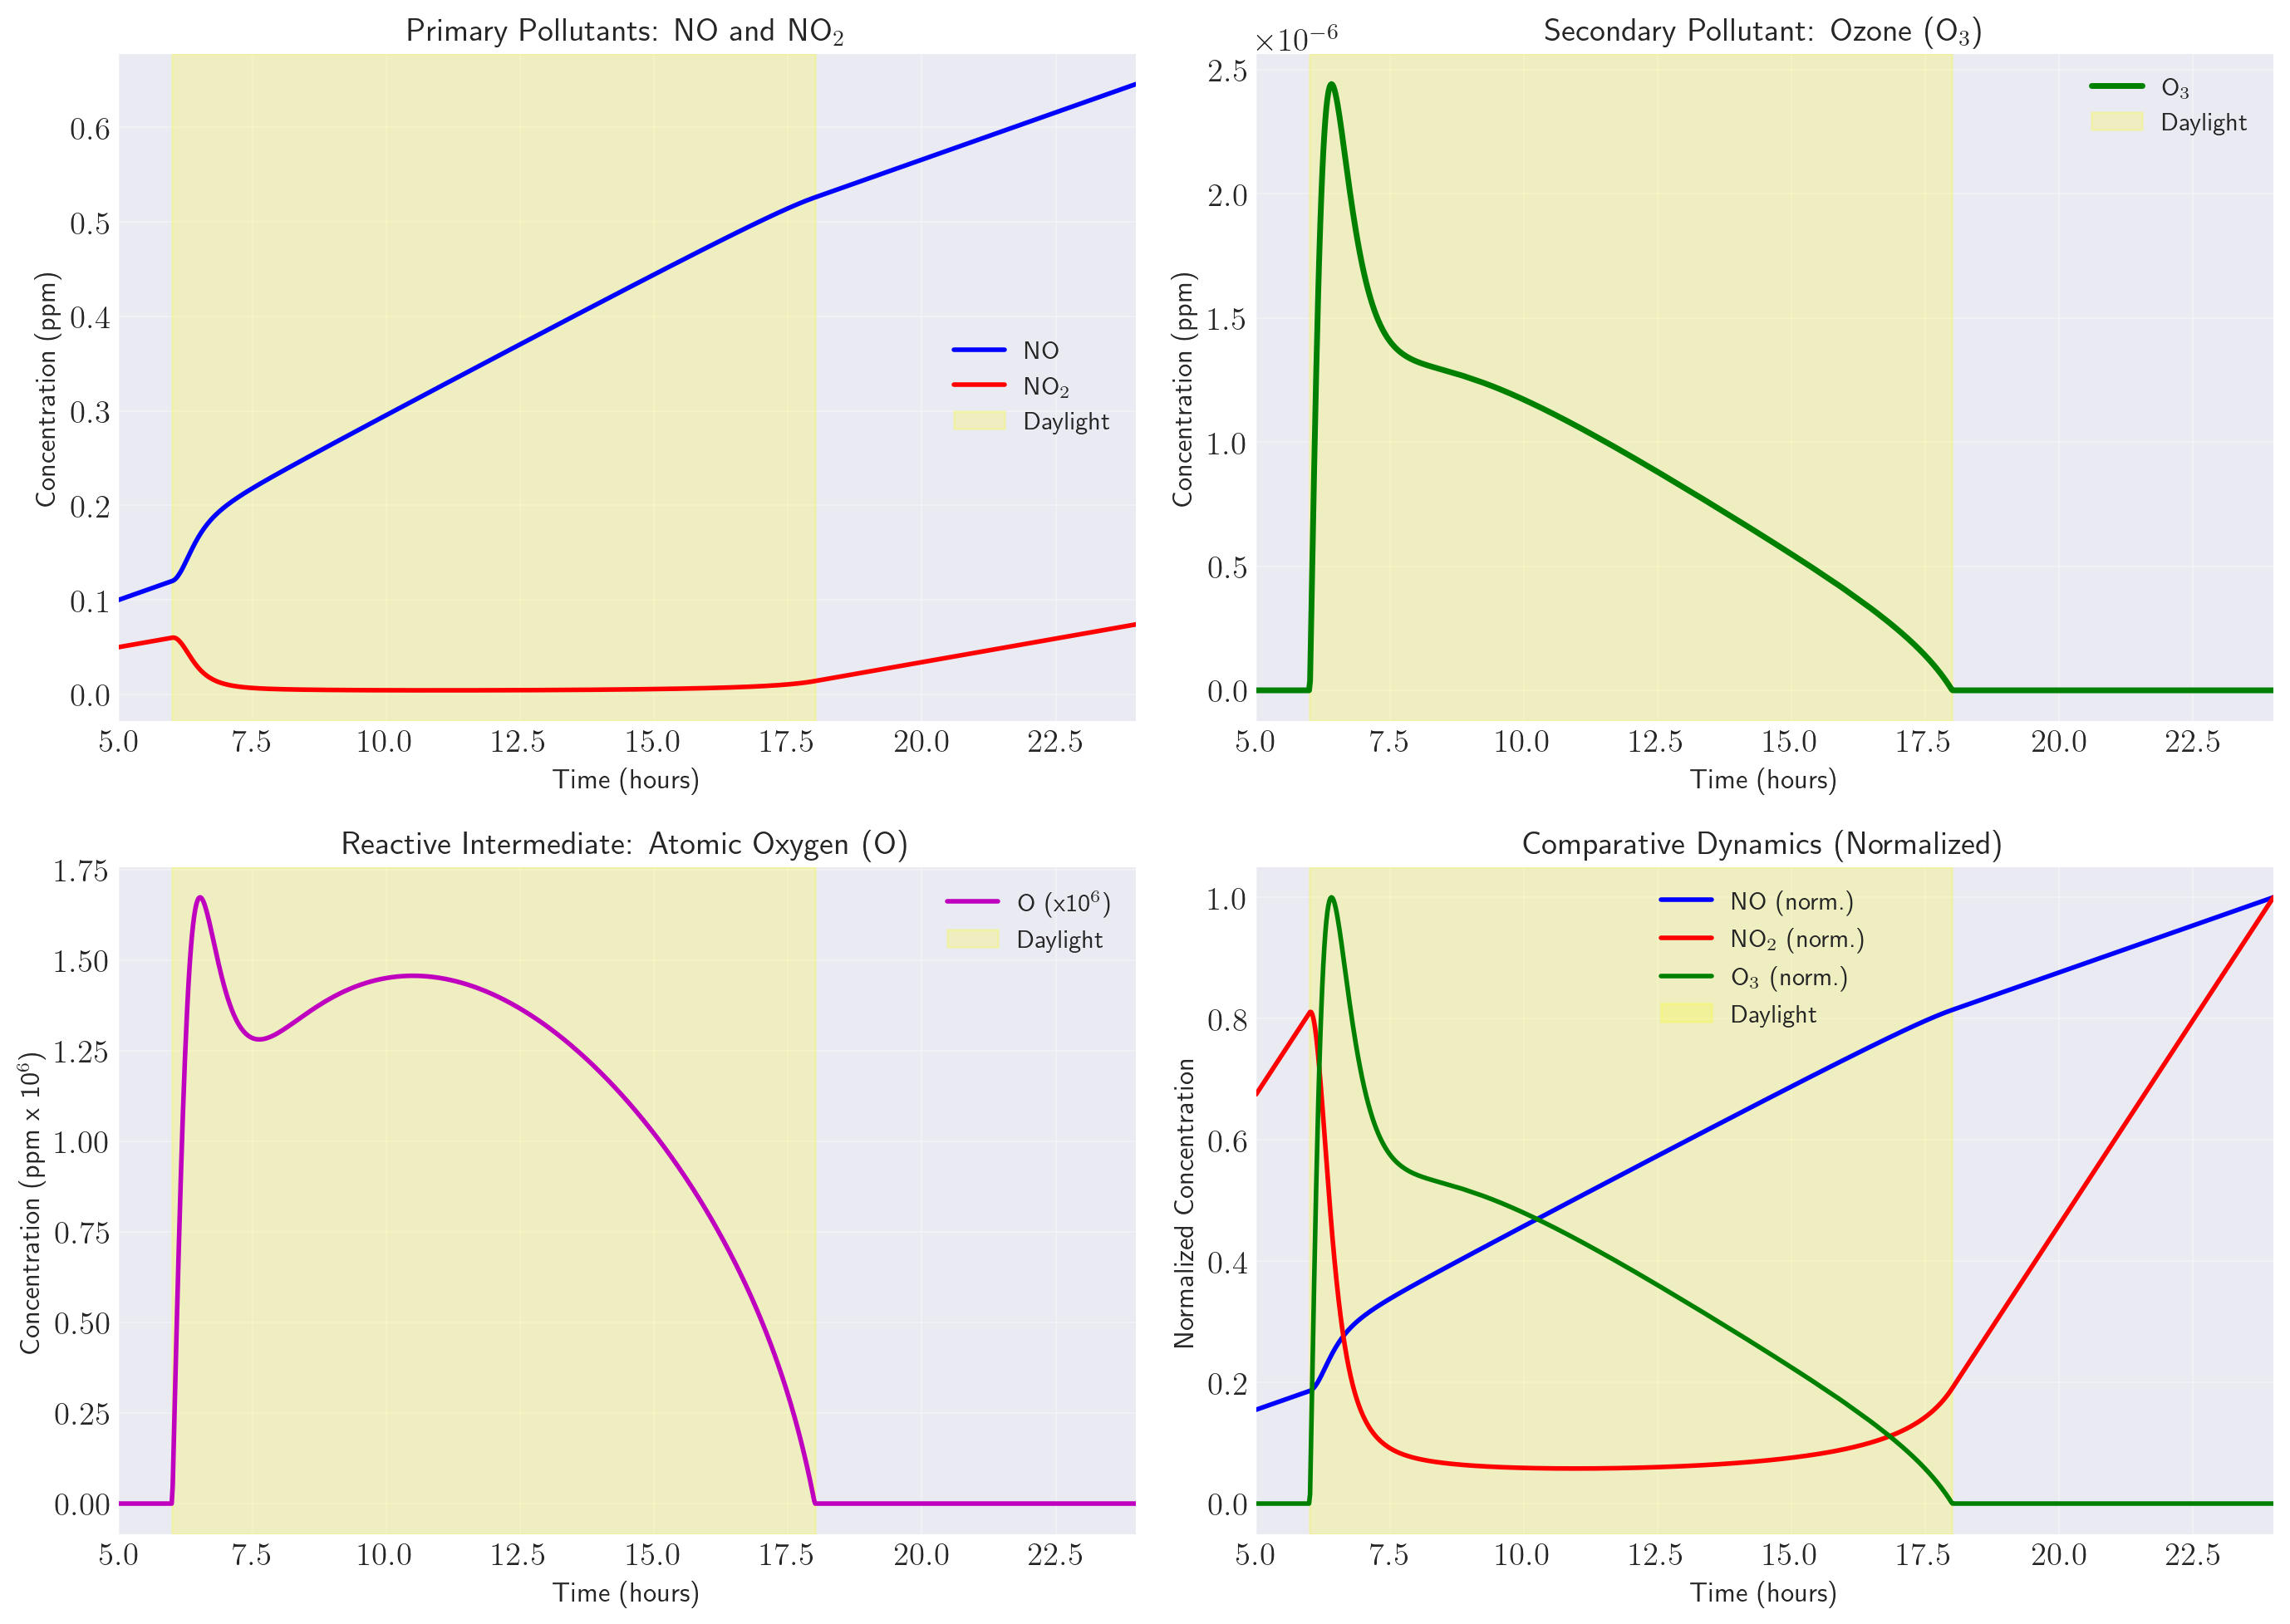


ITERATION 1: SIMPLE PHOTOCHEMICAL SMOG MODEL - RESULTS SUMMARY

Temperature: 288.0 K

Rate Constants:
  k1_max (photolysis): 30.480 h⁻¹
  k2 (O3 formation): 1.374925e-03 ppm⁻¹h⁻¹
  k3 (NO oxidation): 1.210489e+03 ppm⁻¹h⁻¹

Initial Concentrations (5:00 AM):
  [NO]₀  = 0.100 ppm
  [NO₂]₀ = 0.050 ppm
  [O₃]₀  = 0.000 ppm

Peak Concentrations:
  Max [O₃]  = 0.0000 ppm at 6.4:00
  Max [NO₂] = 0.0741 ppm at 24.0:00
  Min [NO]  = 0.1000 ppm at 5.0:00

Final Concentrations (midnight):
  [NO]  = 0.6459 ppm
  [NO₂] = 0.0741 ppm
  [O₃]  = 0.0000 ppm



In [3]:
# ============================================================================
# PARAMETERS
# ============================================================================

# Temperature (K)
T = 288.0

# Rate constants (converted to per hour and ppm units)
k1_max = 0.508 * 60  # Max photolysis rate (1/h)
k2 = 3.9e-6 * np.exp(510/T) * 60  # O3 formation (ppm^-1 h^-1)
k3 = 3.1e3 * np.exp(-1450/T) * 60  # NO oxidation by O3 (ppm^-1 h^-1)
k4 = 1.34e4 * 60  # NO2 reduction by O (ppm^-1 h^-1)
k5 = 5.6e2 * np.exp(584/T) * 60  # NO oxidation by O (ppm^-1 h^-1)

# Constant concentrations
O2 = 210000.0  # ppm (atmospheric oxygen)

# Emission rates (ppm/h)
E_NO = 0.02
E_NO2 = 0.01

# Initial conditions [NO, NO2, O3, O] at t=0 (5:00 AM)
C0 = [0.1, 0.05, 0.0, 0.0]

# ============================================================================
# SOLAR RADIATION FUNCTION
# ============================================================================

def k1_photolysis(t):
    """
    Photolysis rate constant for NO2 as function of time
    Solar radiation: 6:00 AM to 6:00 PM
    
    Parameters:
        t : float, time in hours (0 = 5:00 AM)
    
    Returns:
        float : photolysis rate constant (1/h)
    """
    t_solar = t + 5  # Convert to clock time
    
    if 6 <= t_solar <= 18:
        # Sine function peaks at noon
        return k1_max * np.sin(np.pi * (t_solar - 6) / 12)
    else:
        return 0.0

# ============================================================================
# DIFFERENTIAL EQUATIONS
# ============================================================================

def photochemical_model(C, t):
    """
    System of ODEs for photochemical smog formation
    
    Parameters:
        C : list, concentrations [NO, NO2, O3, O]
        t : float, time (hours since 5:00 AM)
    
    Returns:
        list : derivatives [dNO/dt, dNO2/dt, dO3/dt, dO/dt]
    """
    NO, NO2, O3, O = C
    
    # Get time-dependent photolysis rate
    k1 = k1_photolysis(t)
    
    # Reaction rates (R1-R5)
    R1 = k1 * NO2
    R2 = k2 * O * O2
    R3 = k3 * O3 * NO
    R4 = k4 * NO2 * O
    R5 = k5 * NO * O
    
    # Species mass balances
    dNO_dt = R1 - R3 + R4 - R5 + E_NO
    dNO2_dt = -R1 + R3 - R4 + R5 + E_NO2
    dO3_dt = R2 - R3
    dO_dt = R1 - R2 - R4 - R5
    
    return [dNO_dt, dNO2_dt, dO3_dt, dO_dt]

# ============================================================================
# SOLVE ODEs
# ============================================================================

# Time span: 19 hours (5:00 AM to midnight)
t_span = np.linspace(0, 19, 1000)

# Solve system
solution = odeint(photochemical_model, C0, t_span)

# Extract solutions
NO = solution[:, 0]
NO2 = solution[:, 1]
O3 = solution[:, 2]
O = solution[:, 3]

# Convert time to clock hours
t_clock = t_span + 5

# ============================================================================
# VISUALIZATION
# ============================================================================

plt.style.use('seaborn-v0_8-darkgrid')
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: NO and NO2
ax1 = axes[0, 0]
ax1.plot(t_clock, NO, 'b-', linewidth=2, label='NO')
ax1.plot(t_clock, NO2, 'r-', linewidth=2, label=r'NO$_2$')
ax1.axvspan(6, 18, alpha=0.2, color='yellow', label='Daylight')
ax1.set_xlabel('Time (hours)', fontsize=12)
ax1.set_ylabel('Concentration (ppm)', fontsize=12)
ax1.set_title(r'Primary Pollutants: NO and NO$_2$', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(5, 24)

# Plot 2: Ozone
ax2 = axes[0, 1]
ax2.plot(t_clock, O3, 'g-', linewidth=2.5, label=r'O$_3$')
ax2.axvspan(6, 18, alpha=0.2, color='yellow', label='Daylight')
ax2.set_xlabel('Time (hours)', fontsize=12)
ax2.set_ylabel('Concentration (ppm)', fontsize=12)
ax2.set_title(r'Secondary Pollutant: Ozone (O$_3$)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(5, 24)

# Plot 3: Atomic Oxygen
ax3 = axes[1, 0]
ax3.plot(t_clock, O * 1e6, 'm-', linewidth=2, label=r'O (x10$^6$)')
ax3.axvspan(6, 18, alpha=0.2, color='yellow', label='Daylight')
ax3.set_xlabel('Time (hours)', fontsize=12)
ax3.set_ylabel(r'Concentration (ppm x 10$^6$)', fontsize=12)
ax3.set_title(r'Reactive Intermediate: Atomic Oxygen (O)', fontsize=14, fontweight='bold')
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3)
ax3.set_xlim(5, 24)

# Plot 4: All species together (normalized)
ax4 = axes[1, 1]
ax4.plot(t_clock, NO / np.max(NO), 'b-', linewidth=2, label=r'NO (norm.)')
ax4.plot(t_clock, NO2 / np.max(NO2), 'r-', linewidth=2, label=r'NO$_2$ (norm.)')
ax4.plot(t_clock, O3 / np.max(O3), 'g-', linewidth=2, label=r'O$_3$ (norm.)')
ax4.axvspan(6, 18, alpha=0.2, color='yellow', label='Daylight')
ax4.set_xlabel('Time (hours)', fontsize=12)
ax4.set_ylabel('Normalized Concentration', fontsize=12)
ax4.set_title('Comparative Dynamics (Normalized)', fontsize=14, fontweight='bold')
ax4.legend(fontsize=11)
ax4.grid(True, alpha=0.3)
ax4.set_xlim(5, 24)

plt.tight_layout()
# plt.savefig('iteration1_photochemical_smog.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# SUMMARY STATISTICS
# ============================================================================

print("\n" + "="*70)
print("ITERATION 1: SIMPLE PHOTOCHEMICAL SMOG MODEL - RESULTS SUMMARY")
print("="*70)

print(f"\nTemperature: {T} K")
print(f"\nRate Constants:")
print(f"  k1_max (photolysis): {k1_max:.3f} h⁻¹")
print(f"  k2 (O3 formation): {k2:.6e} ppm⁻¹h⁻¹")
print(f"  k3 (NO oxidation): {k3:.6e} ppm⁻¹h⁻¹")

print(f"\nInitial Concentrations (5:00 AM):")
print(f"  [NO]₀  = {C0[0]:.3f} ppm")
print(f"  [NO₂]₀ = {C0[1]:.3f} ppm")
print(f"  [O₃]₀  = {C0[2]:.3f} ppm")

print(f"\nPeak Concentrations:")
idx_max_O3 = np.argmax(O3)
print(f"  Max [O₃]  = {np.max(O3):.4f} ppm at {t_clock[idx_max_O3]:.1f}:00")
print(f"  Max [NO₂] = {np.max(NO2):.4f} ppm at {t_clock[np.argmax(NO2)]:.1f}:00")
print(f"  Min [NO]  = {np.min(NO):.4f} ppm at {t_clock[np.argmin(NO)]:.1f}:00")

print(f"\nFinal Concentrations (midnight):")
print(f"  [NO]  = {NO[-1]:.4f} ppm")
print(f"  [NO₂] = {NO2[-1]:.4f} ppm")
print(f"  [O₃]  = {O3[-1]:.4f} ppm")

print("\n" + "="*70)

Solving refined photochemical model...


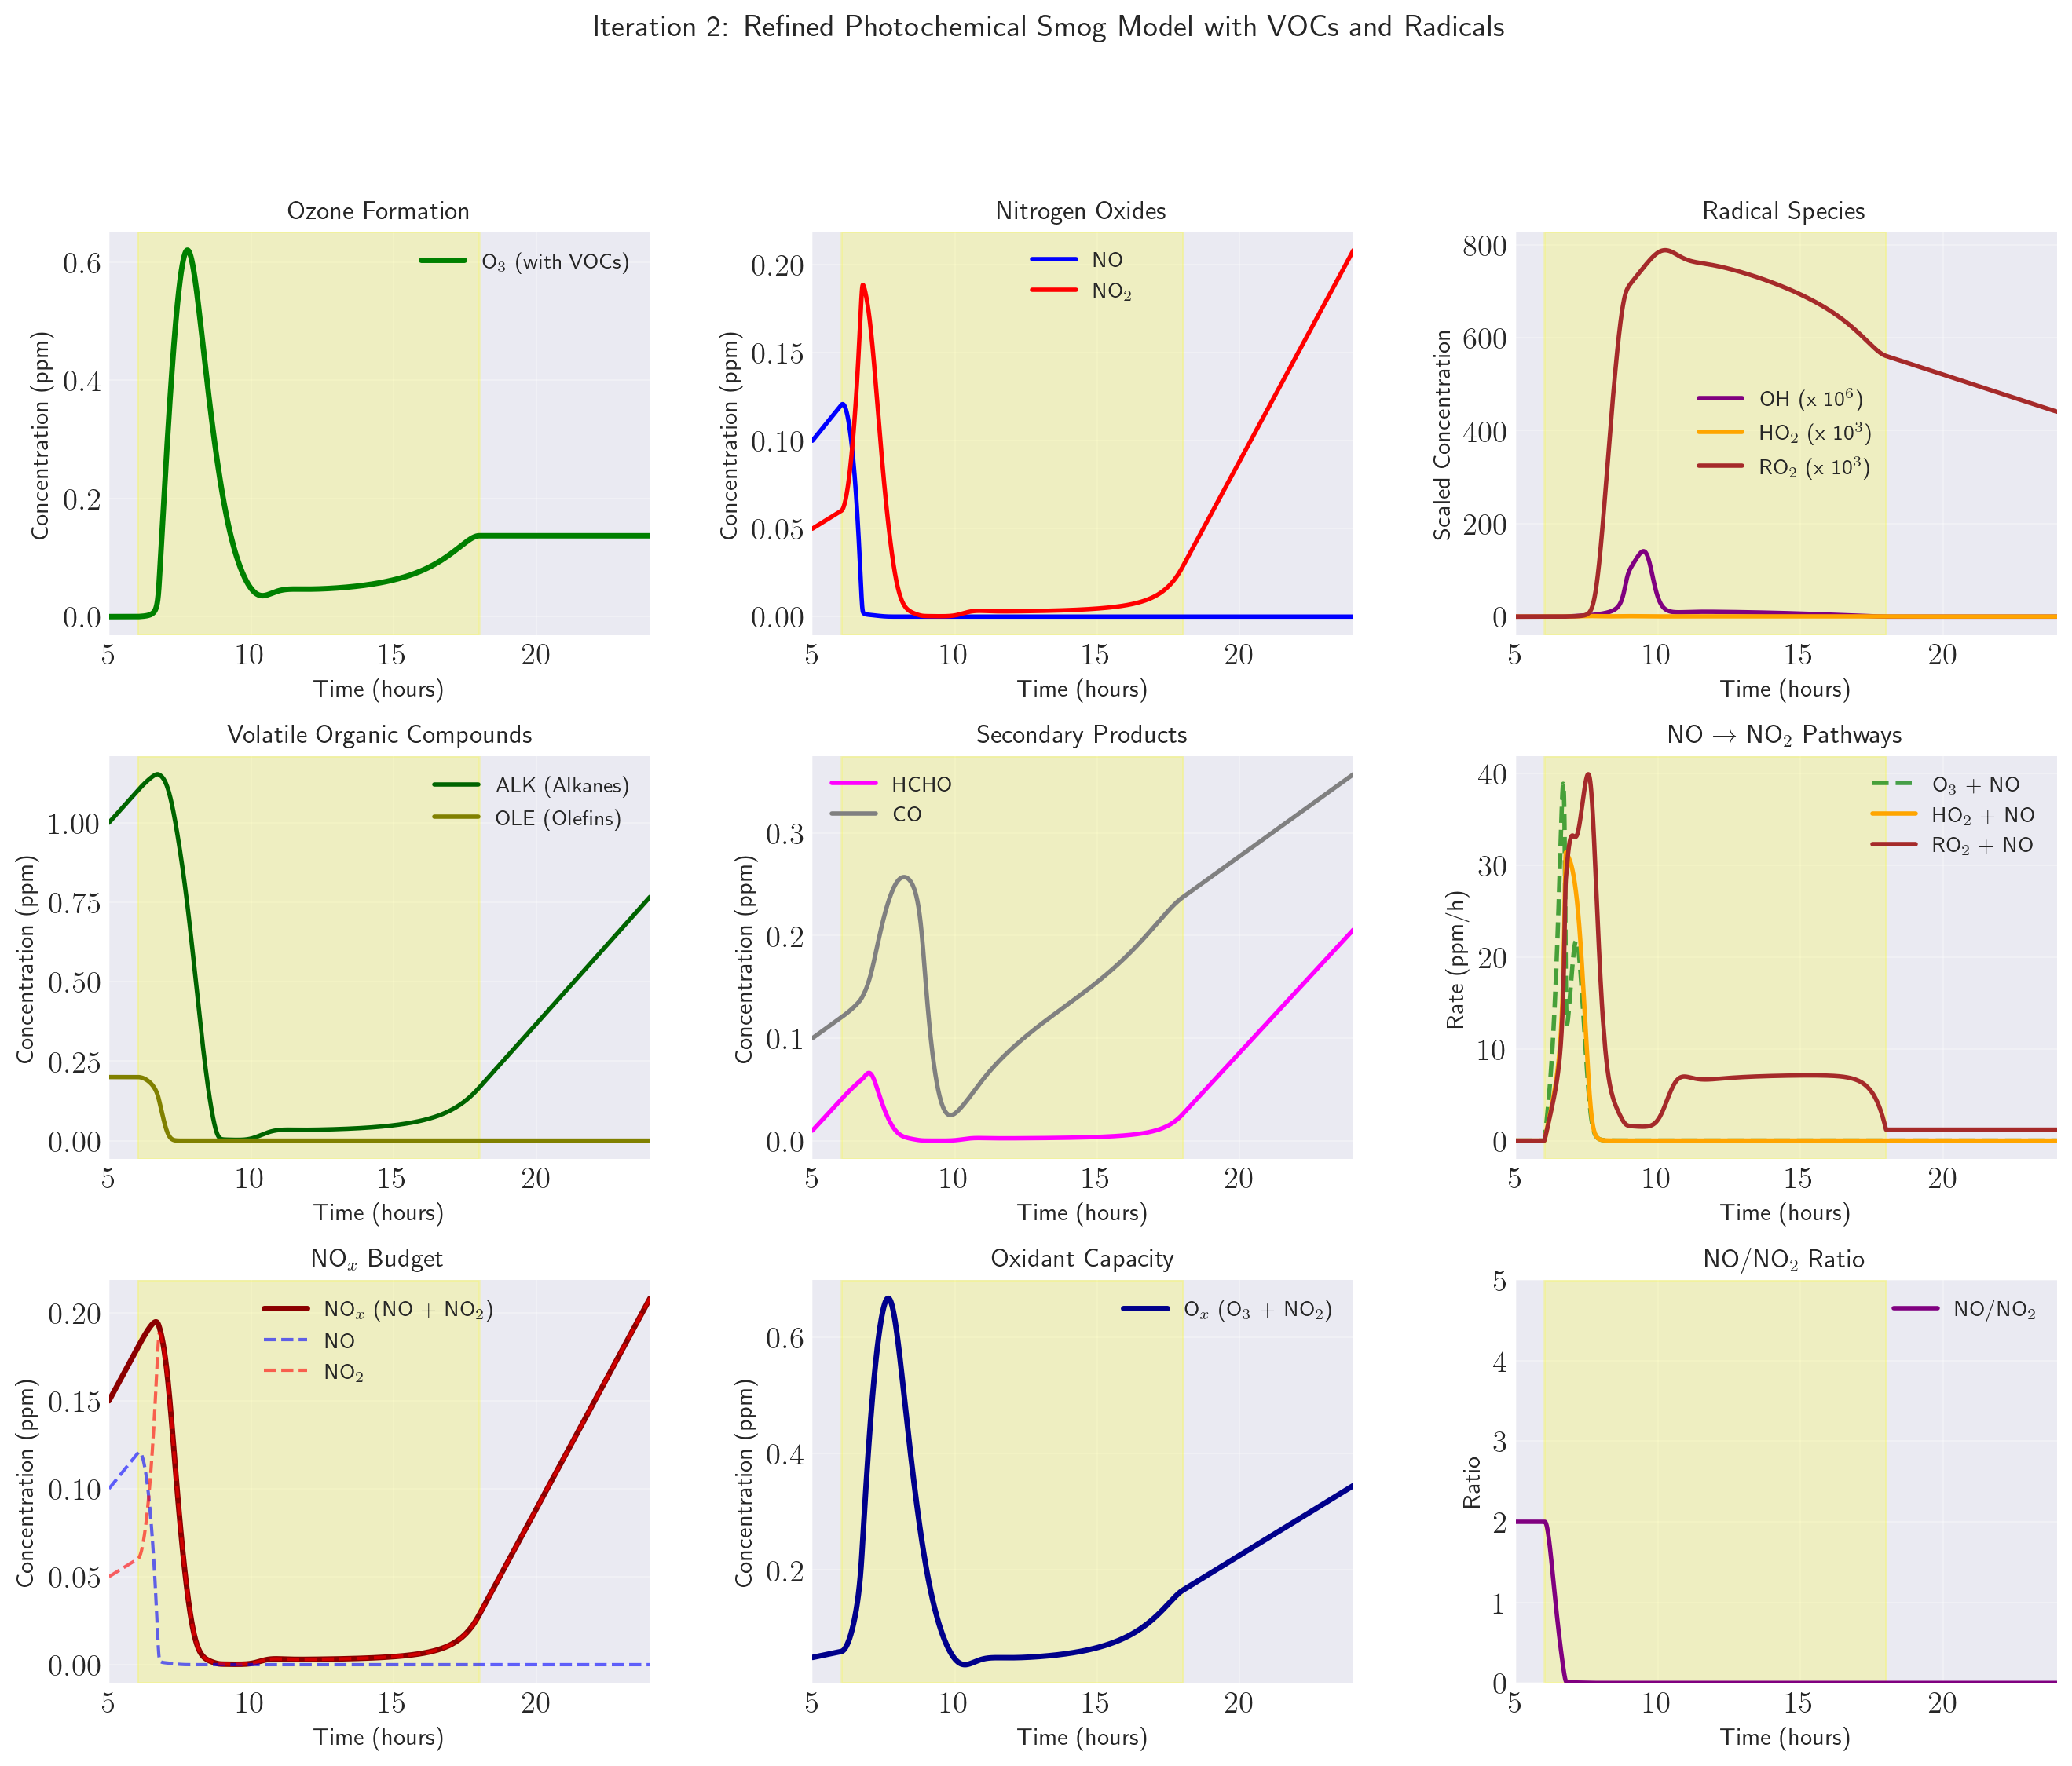

/var/folders/rn/v0v0mhyx1lq27mkj7vl7v5c80000gn/T/ipykernel_4459/3785887008.py:363: RuntimeWarning: invalid value encountered in divide
  O3_enhancement = np.where(O3_simple > 0.001, O3 / O3_simple, 1.0)


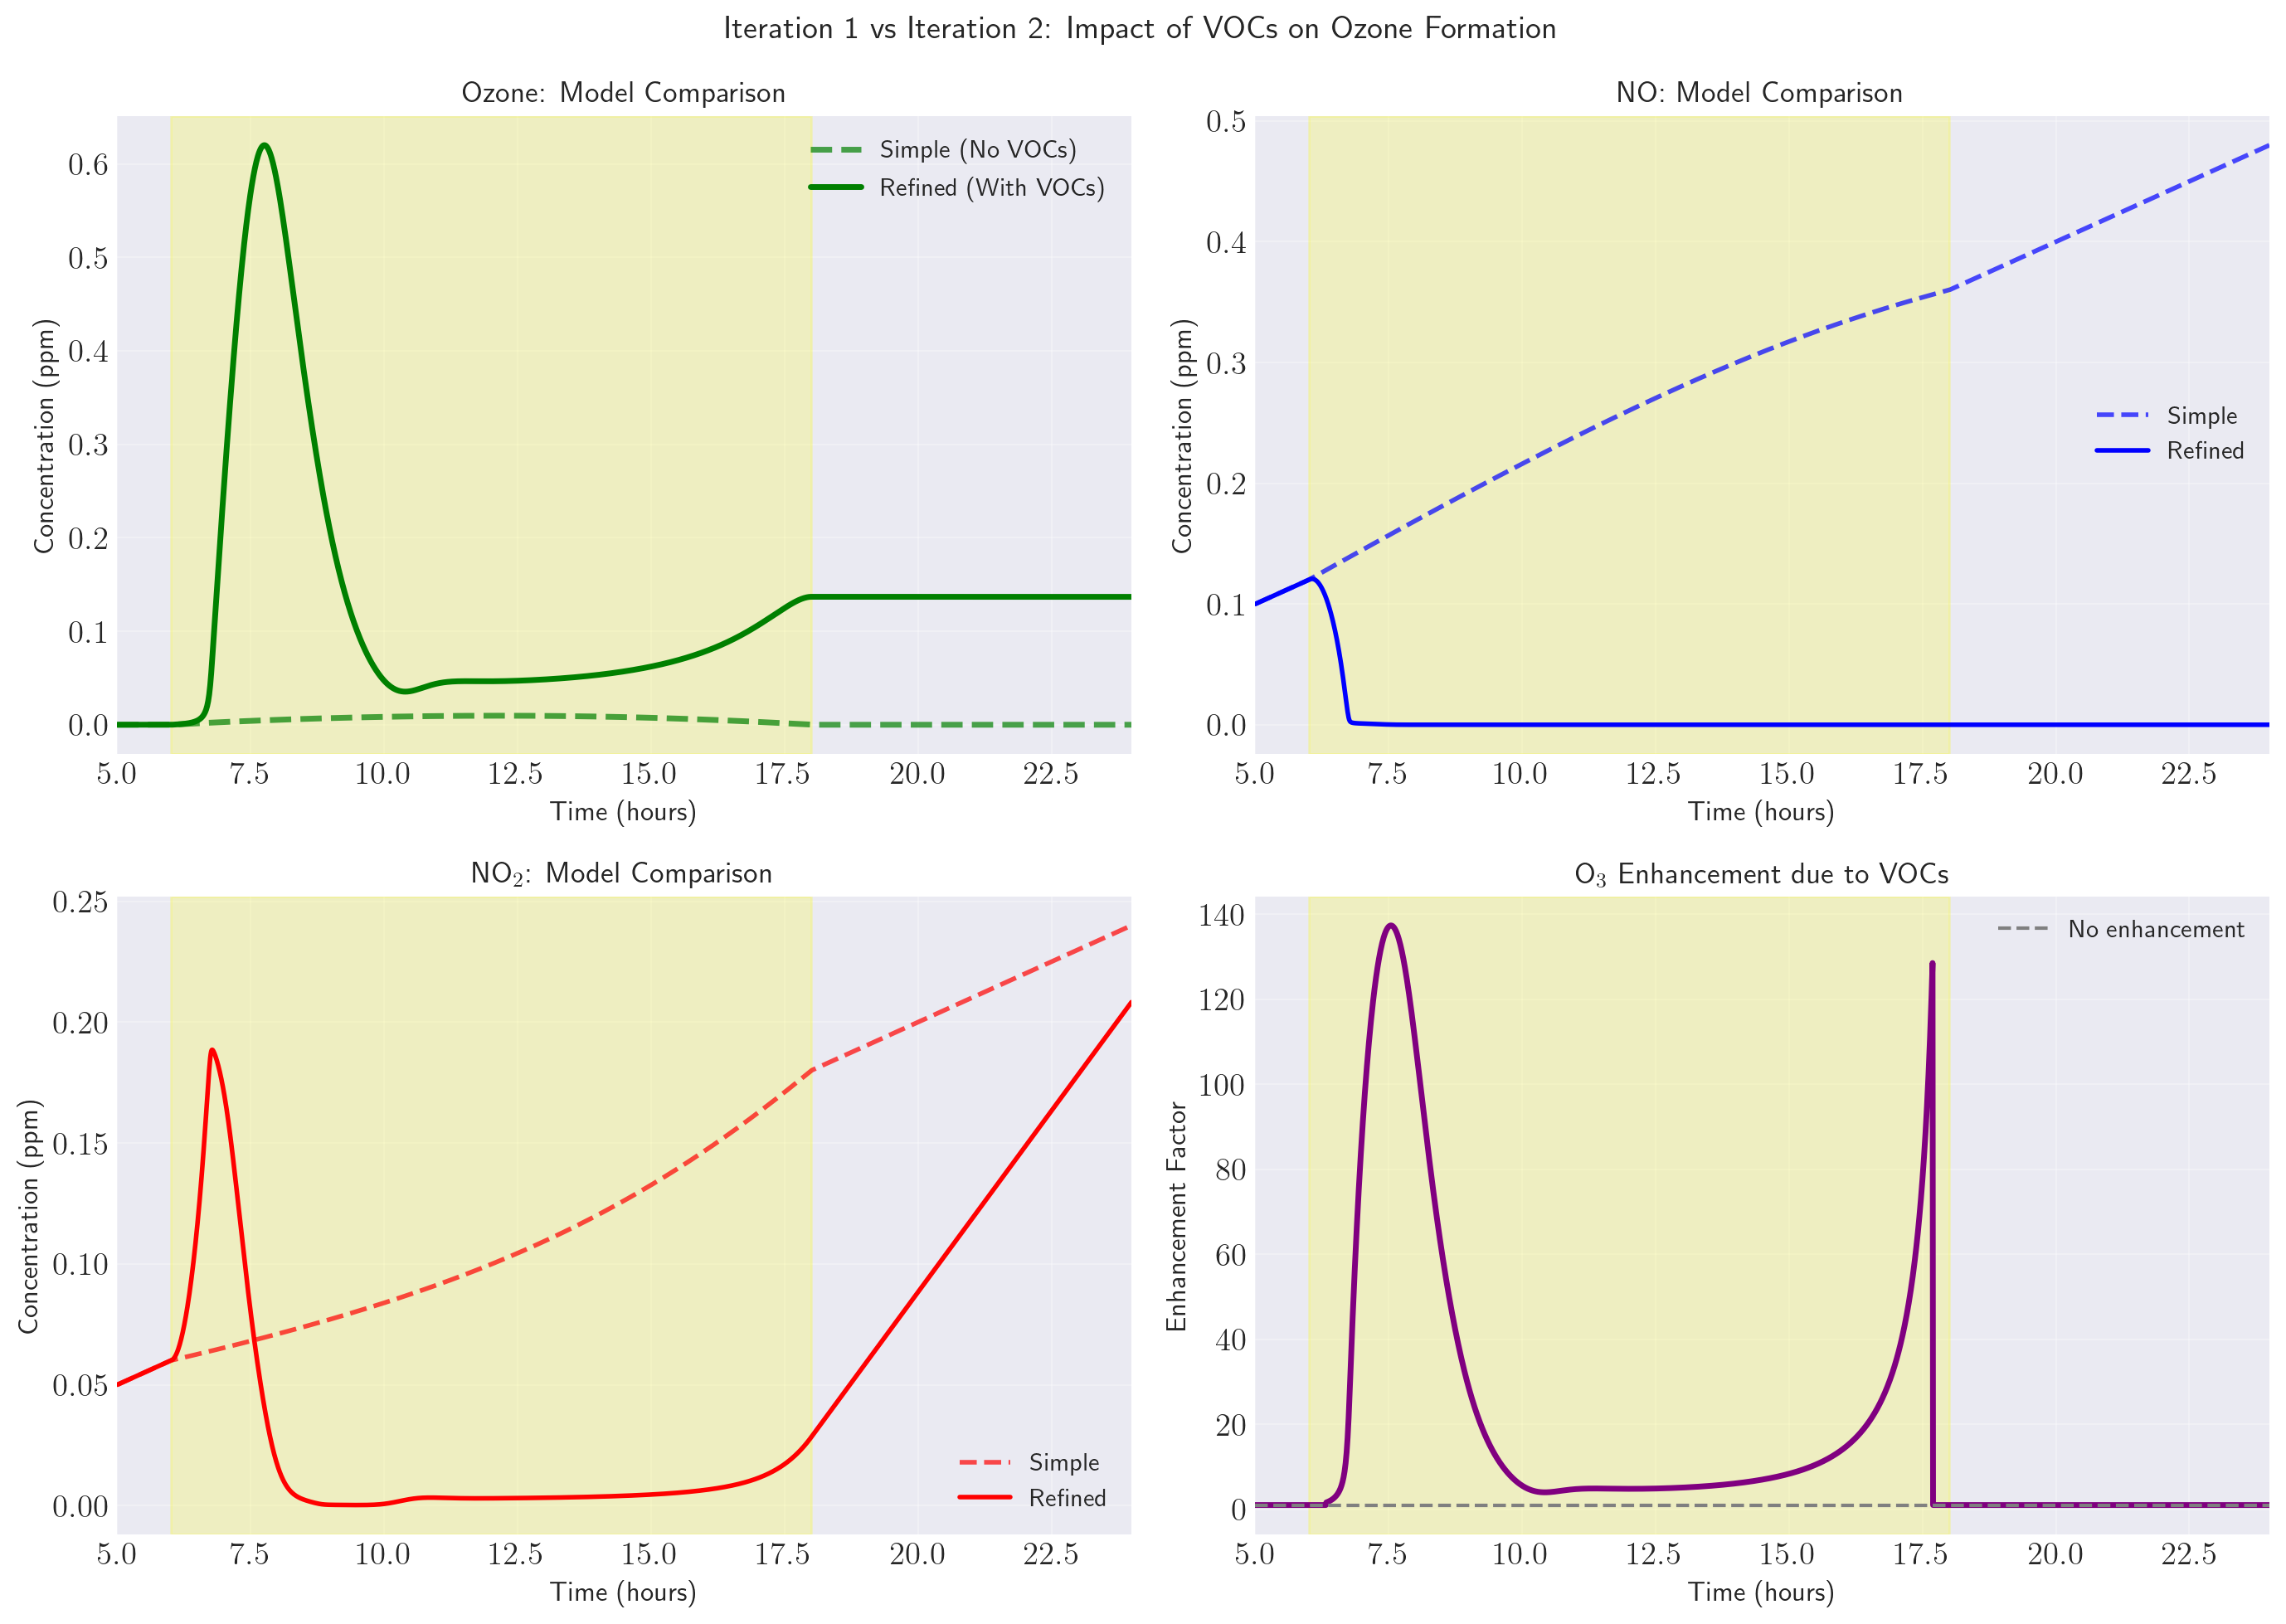


ITERATION 2: REFINED MODEL WITH VOCs - RESULTS SUMMARY

Model Configuration:
  Temperature: 288.0 K
  Species tracked: 11 (NO, NO₂, O₃, O, CO, HCHO, ALK, OLE, OH, HO₂, RO₂)
  Reactions included: 15

Initial Conditions (5:00 AM):
  [NO]₀   = 0.100 ppm
  [NO₂]₀  = 0.050 ppm
  [O₃]₀   = 0.000 ppm
  [CO]₀   = 0.100 ppm
  [ALK]₀  = 1.000 ppm
  [OLE]₀  = 0.200 ppm

Peak Concentrations:
  Max [O₃]   = 0.6200 ppm at 7.8:00
  Max [OH]   = 140.7637 × 10⁻⁶ ppm at 9.5:00
  Max [HO₂]  = 1.2530 × 10⁻³ ppm at 7.6:00
  Max [RO₂]  = 788.0157 × 10⁻³ ppm at 10.2:00
  Max [NO₂]  = 0.2083 ppm at 24.0:00
  Min [NO]   = 0.0000 ppm at 9.5:00

VOC Consumption:
  ALK consumed: 0.2334 ppm (23.3%)
  OLE consumed: 0.2000 ppm (100.0%)

Comparison with Simple Model (Iteration 1):
  Simple model max O₃:  0.0097 ppm
  Refined model max O₃: 0.6200 ppm
  Enhancement factor:   64.16x
  Additional O₃ formed: 610.31 ppb

NOₓ Budget at Peak O₃ Time:
  [NO]:    0.0000 ppm
  [NO₂]:   0.0406 ppm
  [NOₓ]:   0.0406 ppm
  NO/NO₂

In [12]:
# ============================================================================
# PARAMETERS
# ============================================================================

# Temperature (K)
T = 288.0

# Constants
O2 = 210000.0      # ppm (atmospheric oxygen)
H2O = 15000.0      # ppm (water vapor)
M = 1.0e6          # ppm (air, third body)

# Maximum photolysis rates (1/h)
k1_max = 0.508 * 60           # NO2 photolysis
k4_max = 0.0328 * 60          # O3 photolysis
k7_max = 0.00284 * 60         # HCHO photolysis

# Temperature-dependent rate constants
k2 = 3.9e-6 * np.exp(510/T) * 60           # O + O2 -> O3
k3 = 3.1e3 * np.exp(-1450/T) * 60          # O3 + NO -> NO2
k5 = 1.0e5 * 60                             # O(1D) + H2O -> 2OH
k6 = 4.4e2 * 60                             # CO + OH -> HO2
k8 = 19200.0 * 60                           # HCHO + OH -> HO2
k9 = 4700.0 * 60                            # ALK + OH -> RO2
k10 = 89142.0 * 60                          # OLE + OH -> RO2
k11 = 0.136 * 60                            # OLE + O3 -> products
k12 = 1.2e4 * 60                            # HO2 + NO -> NO2 + OH
k13 = 1.2e4 * 60                            # RO2 + NO -> NO2 + HO2
k14 = 3700.0 * 60                           # HO2 + HO2 -> H2O2
k15 = 1.477e15 * 10**(-11.6*T/(17.4+T)) * (280/T)**2 * 60  # OH + NO2 -> HNO3

# Emission rates (ppm/h)
E_NO = 0.02
E_NO2 = 0.01
E_CO = 0.02
E_HCHO = 0.03
E_ALK = 0.1
E_OLE = 0.0

# Initial conditions [NO, NO2, O3, O, CO, HCHO, ALK, OLE, OH, HO2, RO2]
C0 = [0.1, 0.05, 0.0, 0.0, 0.1, 0.01, 1.0, 0.2, 0.0, 0.0, 0.0]

# ============================================================================
# SOLAR RADIATION FUNCTIONS
# ============================================================================

def solar_intensity(t):
    """Solar intensity factor (0-1) based on time of day"""
    t_solar = t + 5  # Convert to clock time
    if 6 <= t_solar <= 18:
        return np.sin(np.pi * (t_solar - 6) / 12)
    else:
        return 0.0

def k1_photolysis(t):
    """NO2 photolysis rate"""
    return k1_max * solar_intensity(t)

def k4_photolysis(t):
    """O3 photolysis rate"""
    return k4_max * solar_intensity(t)

def k7_photolysis(t):
    """HCHO photolysis rate"""
    return k7_max * solar_intensity(t)

# ============================================================================
# DIFFERENTIAL EQUATIONS
# ============================================================================

def refined_photochemical_model(C, t):
    """
    Refined system of ODEs for photochemical smog with VOCs and radicals
    
    Species order: [NO, NO2, O3, O, CO, HCHO, ALK, OLE, OH, HO2, RO2]
    """
    NO, NO2, O3, O, CO, HCHO, ALK, OLE, OH, HO2, RO2 = C
    
    # Get time-dependent photolysis rates
    k1 = k1_photolysis(t)
    k4 = k4_photolysis(t)
    k7 = k7_photolysis(t)
    
    # Calculate O(1D) concentration (quasi-steady-state approximation)
    if k5 * H2O > 0:
        O1D = k4 * O3 / (k5 * H2O)
    else:
        O1D = 0.0
    
    # Reaction rates
    R1 = k1 * NO2
    R2 = k2 * O * O2
    R3 = k3 * O3 * NO
    R4 = k4 * O3
    R5 = k5 * O1D * H2O
    R6 = k6 * CO * OH
    R7 = k7 * HCHO
    R8 = k8 * HCHO * OH
    R9 = k9 * ALK * OH
    R10 = k10 * OLE * OH
    R11 = k11 * OLE * O3
    R12 = k12 * HO2 * NO
    R13 = k13 * RO2 * NO
    R14 = k14 * HO2 * HO2
    R15 = k15 * OH * NO2
    
    # Species mass balances
    dNO_dt = R1 - R3 - R12 - R13 + E_NO
    
    dNO2_dt = -R1 + R3 + R12 + R13 - R15 + E_NO2
    
    dO3_dt = R2 - R3 - R4 - R11
    
    dO_dt = R1 - R2
    
    dCO_dt = -R6 + R7 + R8 + E_CO
    
    dHCHO_dt = 0.5 * R11 - R7 - R8 + E_HCHO
    
    dALK_dt = -R9 + E_ALK
    
    dOLE_dt = -R10 - R11 + E_OLE
    
    dOH_dt = 2*R5 - R6 - R8 - R9 - R10 - R15 + R12
    
    dHO2_dt = R6 + 2*R7 + R8 + 0.5*R11 + R13 - R12 - 2*R14
    
    dRO2_dt = R9 + R10 + 0.5*R11 - R13
    
    return [dNO_dt, dNO2_dt, dO3_dt, dO_dt, dCO_dt, dHCHO_dt, 
            dALK_dt, dOLE_dt, dOH_dt, dHO2_dt, dRO2_dt]

# ============================================================================
# SOLVE ODEs
# ============================================================================

# Time span: 19 hours (5:00 AM to midnight)
t_span = np.linspace(0, 19, 2000)

# Solve system
print("Solving refined photochemical model...")
solution = odeint(refined_photochemical_model, C0, t_span, rtol=1e-6, atol=1e-8)

# Extract solutions
NO = solution[:, 0]
NO2 = solution[:, 1]
O3 = solution[:, 2]
O = solution[:, 3]
CO = solution[:, 4]
HCHO = solution[:, 5]
ALK = solution[:, 6]
OLE = solution[:, 7]
OH = solution[:, 8]
HO2 = solution[:, 9]
RO2 = solution[:, 10]

# Convert time to clock hours
t_clock = t_span + 5

# ============================================================================
# VISUALIZATION
# ============================================================================

plt.style.use('seaborn-v0_8-darkgrid')
fig = plt.figure(figsize=(16, 12))

# Create grid for subplots
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Plot 1: Ozone comparison (will compare with Iteration 1 later)
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(t_clock, O3, 'g-', linewidth=2.5, label=r'O$_3$ (with VOCs)')
ax1.axvspan(6, 18, alpha=0.2, color='yellow')
ax1.set_xlabel('Time (hours)', fontsize=11)
ax1.set_ylabel('Concentration (ppm)', fontsize=11)
ax1.set_title('Ozone Formation', fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(5, 24)

# Plot 2: NO and NO2
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(t_clock, NO, 'b-', linewidth=2, label=r'NO')
ax2.plot(t_clock, NO2, 'r-', linewidth=2, label=r'NO$_2$')
ax2.axvspan(6, 18, alpha=0.2, color='yellow')
ax2.set_xlabel('Time (hours)', fontsize=11)
ax2.set_ylabel('Concentration (ppm)', fontsize=11)
ax2.set_title('Nitrogen Oxides', fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(5, 24)

# Plot 3: Radicals (OH, HO2, RO2)
ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(t_clock, OH * 1e6, 'purple', linewidth=2, label=r'OH (x 10$^6$)')
ax3.plot(t_clock, HO2 * 1e3, 'orange', linewidth=2, label=r'HO$_2$ (x 10$^3$)')
ax3.plot(t_clock, RO2 * 1e3, 'brown', linewidth=2, label=r'RO$_2$ (x 10$^3$)')
ax3.axvspan(6, 18, alpha=0.2, color='yellow')
ax3.set_xlabel('Time (hours)', fontsize=11)
ax3.set_ylabel('Scaled Concentration', fontsize=11)
ax3.set_title('Radical Species', fontsize=12, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)
ax3.set_xlim(5, 24)

# Plot 4: VOCs (ALK, OLE)
ax4 = fig.add_subplot(gs[1, 0])
ax4.plot(t_clock, ALK, 'darkgreen', linewidth=2, label='ALK (Alkanes)')
ax4.plot(t_clock, OLE, 'olive', linewidth=2, label='OLE (Olefins)')
ax4.axvspan(6, 18, alpha=0.2, color='yellow')
ax4.set_xlabel('Time (hours)', fontsize=11)
ax4.set_ylabel('Concentration (ppm)', fontsize=11)
ax4.set_title('Volatile Organic Compounds', fontsize=12, fontweight='bold')
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3)
ax4.set_xlim(5, 24)

# Plot 5: Secondary products (HCHO, CO)
ax5 = fig.add_subplot(gs[1, 1])
ax5.plot(t_clock, HCHO, 'magenta', linewidth=2, label='HCHO')
ax5.plot(t_clock, CO, 'gray', linewidth=2, label='CO')
ax5.axvspan(6, 18, alpha=0.2, color='yellow')
ax5.set_xlabel('Time (hours)', fontsize=11)
ax5.set_ylabel('Concentration (ppm)', fontsize=11)
ax5.set_title('Secondary Products', fontsize=12, fontweight='bold')
ax5.legend(fontsize=10)
ax5.grid(True, alpha=0.3)
ax5.set_xlim(5, 24)

# Plot 6: O3 production mechanisms
ax6 = fig.add_subplot(gs[1, 2])
# Calculate contributions
NO_to_NO2_via_HO2 = k12 * HO2 * NO * 60  # Convert to ppm/h
NO_to_NO2_via_RO2 = k13 * RO2 * NO * 60
NO_to_NO2_via_O3 = k3 * O3 * NO * 60
ax6.plot(t_clock, NO_to_NO2_via_O3, 'g--', linewidth=2, label=r'O$_3$ + NO', alpha=0.7)
ax6.plot(t_clock, NO_to_NO2_via_HO2, 'orange', linewidth=2, label=r'HO$_2$ + NO')
ax6.plot(t_clock, NO_to_NO2_via_RO2, 'brown', linewidth=2, label=r'RO$_2$ + NO')
ax6.axvspan(6, 18, alpha=0.2, color='yellow')
ax6.set_xlabel('Time (hours)', fontsize=11)
ax6.set_ylabel('Rate (ppm/h)', fontsize=11)
ax6.set_title(r'NO $\to$ NO$_2$ Pathways', fontsize=12, fontweight='bold')
ax6.legend(fontsize=10)
ax6.grid(True, alpha=0.3)
ax6.set_xlim(5, 24)

# Plot 7: NOx budget
ax7 = fig.add_subplot(gs[2, 0])
NOx = NO + NO2
ax7.plot(t_clock, NOx, 'darkred', linewidth=2.5, label=r'NO$_x$ (NO + NO$_2$)')
ax7.plot(t_clock, NO, 'b--', linewidth=1.5, label=r'NO', alpha=0.6)
ax7.plot(t_clock, NO2, 'r--', linewidth=1.5, label=r'NO$_2$', alpha=0.6)
ax7.axvspan(6, 18, alpha=0.2, color='yellow')
ax7.set_xlabel('Time (hours)', fontsize=11)
ax7.set_ylabel('Concentration (ppm)', fontsize=11)
ax7.set_title(r'NO$_x$ Budget', fontsize=12, fontweight='bold')
ax7.legend(fontsize=10)
ax7.grid(True, alpha=0.3)
ax7.set_xlim(5, 24)

# Plot 8: Oxidant capacity (O3 + NO2)
ax8 = fig.add_subplot(gs[2, 1])
Ox = O3 + NO2
ax8.plot(t_clock, Ox, 'darkblue', linewidth=2.5, label=r'O$_x$ (O$_3$ + NO$_2$)')
ax8.axvspan(6, 18, alpha=0.2, color='yellow')
ax8.set_xlabel('Time (hours)', fontsize=11)
ax8.set_ylabel('Concentration (ppm)', fontsize=11)
ax8.set_title('Oxidant Capacity', fontsize=12, fontweight='bold')
ax8.legend(fontsize=10)
ax8.grid(True, alpha=0.3)
ax8.set_xlim(5, 24)

# Plot 9: Key ratios
ax9 = fig.add_subplot(gs[2, 2])
# Avoid division by zero
NO2_safe = np.where(NO2 > 1e-6, NO2, 1e-6)
NO_NO2_ratio = NO / NO2_safe
VOC_NOx_ratio = (ALK + OLE) / (NO + NO2_safe)
ax9.plot(t_clock, NO_NO2_ratio, 'purple', linewidth=2, label=r'NO/NO$_2$')
ax9.axvspan(6, 18, alpha=0.2, color='yellow')
ax9.set_xlabel('Time (hours)', fontsize=11)
ax9.set_ylabel('Ratio', fontsize=11)
ax9.set_title(r'NO/NO$_2$ Ratio', fontsize=12, fontweight='bold')
ax9.legend(fontsize=10)
ax9.grid(True, alpha=0.3)
ax9.set_xlim(5, 24)
ax9.set_ylim(0, 5)

plt.suptitle('Iteration 2: Refined Photochemical Smog Model with VOCs and Radicals', 
             fontsize=14, fontweight='bold', y=0.995)

# plt.savefig('iteration2_refined_model.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# COMPARISON WITH ITERATION 1 (Re-run simple model for comparison)
# ============================================================================

def simple_model(C, t):
    """Simple model from Iteration 1 for comparison"""
    NO, NO2, O3, O = C
    k1 = k1_photolysis(t)
    
    R1 = k1 * NO2
    R2 = k2 * O * O2
    R3 = k3 * O3 * NO
    
    dNO_dt = R1 - R3 + E_NO
    dNO2_dt = -R1 + R3 + E_NO2
    dO3_dt = R2 - R3
    dO_dt = R1 - R2
    
    return [dNO_dt, dNO2_dt, dO3_dt, dO_dt]

C0_simple = [0.1, 0.05, 0.0, 0.0]
solution_simple = odeint(simple_model, C0_simple, t_span)

NO_simple = solution_simple[:, 0]
NO2_simple = solution_simple[:, 1]
O3_simple = solution_simple[:, 2]

# Comparison plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Ozone comparison
ax1 = axes[0, 0]
ax1.plot(t_clock, O3_simple, 'g--', linewidth=2.5, label='Simple (No VOCs)', alpha=0.7)
ax1.plot(t_clock, O3, 'g-', linewidth=2.5, label='Refined (With VOCs)')
ax1.axvspan(6, 18, alpha=0.2, color='yellow')
ax1.set_xlabel('Time (hours)', fontsize=12)
ax1.set_ylabel('Concentration (ppm)', fontsize=12)
ax1.set_title('Ozone: Model Comparison', fontsize=13, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(5, 24)

# NO comparison
ax2 = axes[0, 1]
ax2.plot(t_clock, NO_simple, 'b--', linewidth=2, label='Simple', alpha=0.7)
ax2.plot(t_clock, NO, 'b-', linewidth=2, label='Refined')
ax2.axvspan(6, 18, alpha=0.2, color='yellow')
ax2.set_xlabel('Time (hours)', fontsize=12)
ax2.set_ylabel('Concentration (ppm)', fontsize=12)
ax2.set_title('NO: Model Comparison', fontsize=13, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(5, 24)

# NO2 comparison
ax3 = axes[1, 0]
ax3.plot(t_clock, NO2_simple, 'r--', linewidth=2, label='Simple', alpha=0.7)
ax3.plot(t_clock, NO2, 'r-', linewidth=2, label='Refined')
ax3.axvspan(6, 18, alpha=0.2, color='yellow')
ax3.set_xlabel('Time (hours)', fontsize=12)
ax3.set_ylabel('Concentration (ppm)', fontsize=12)
ax3.set_title(r'NO$_2$: Model Comparison', fontsize=13, fontweight='bold')
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3)
ax3.set_xlim(5, 24)

# Ozone enhancement factor
ax4 = axes[1, 1]
O3_enhancement = np.where(O3_simple > 0.001, O3 / O3_simple, 1.0)
ax4.plot(t_clock, O3_enhancement, 'purple', linewidth=2.5)
ax4.axhline(y=1, color='gray', linestyle='--', label='No enhancement')
ax4.axvspan(6, 18, alpha=0.2, color='yellow')
ax4.set_xlabel('Time (hours)', fontsize=12)
ax4.set_ylabel('Enhancement Factor', fontsize=12)
ax4.set_title(r'O$_3$ Enhancement due to VOCs', fontsize=13, fontweight='bold')
ax4.legend(fontsize=11)
ax4.grid(True, alpha=0.3)
ax4.set_xlim(5, 24)
# ax4.set_ylim(0, 5)

plt.suptitle('Iteration 1 vs Iteration 2: Impact of VOCs on Ozone Formation', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
# plt.savefig('iteration_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# SUMMARY STATISTICS
# ============================================================================

print("\n" + "="*80)
print("ITERATION 2: REFINED MODEL WITH VOCs - RESULTS SUMMARY")
print("="*80)

print(f"\nModel Configuration:")
print(f"  Temperature: {T} K")
print(f"  Species tracked: 11 (NO, NO₂, O₃, O, CO, HCHO, ALK, OLE, OH, HO₂, RO₂)")
print(f"  Reactions included: 15")

print(f"\nInitial Conditions (5:00 AM):")
print(f"  [NO]₀   = {C0[0]:.3f} ppm")
print(f"  [NO₂]₀  = {C0[1]:.3f} ppm")
print(f"  [O₃]₀   = {C0[2]:.3f} ppm")
print(f"  [CO]₀   = {C0[4]:.3f} ppm")
print(f"  [ALK]₀  = {C0[6]:.3f} ppm")
print(f"  [OLE]₀  = {C0[7]:.3f} ppm")

print(f"\nPeak Concentrations:")
idx_O3_max = np.argmax(O3)
idx_OH_max = np.argmax(OH)
idx_HO2_max = np.argmax(HO2)
idx_RO2_max = np.argmax(RO2)

print(f"  Max [O₃]   = {np.max(O3):.4f} ppm at {t_clock[idx_O3_max]:.1f}:00")
print(f"  Max [OH]   = {np.max(OH)*1e6:.4f} × 10⁻⁶ ppm at {t_clock[idx_OH_max]:.1f}:00")
print(f"  Max [HO₂]  = {np.max(HO2)*1e3:.4f} × 10⁻³ ppm at {t_clock[idx_HO2_max]:.1f}:00")
print(f"  Max [RO₂]  = {np.max(RO2)*1e3:.4f} × 10⁻³ ppm at {t_clock[idx_RO2_max]:.1f}:00")
print(f"  Max [NO₂]  = {np.max(NO2):.4f} ppm at {t_clock[np.argmax(NO2)]:.1f}:00")
print(f"  Min [NO]   = {np.min(NO):.4f} ppm at {t_clock[np.argmin(NO)]:.1f}:00")

print(f"\nVOC Consumption:")
ALK_consumed = C0[6] - ALK[-1]
OLE_consumed = C0[7] - OLE[-1]
print(f"  ALK consumed: {ALK_consumed:.4f} ppm ({ALK_consumed/C0[6]*100:.1f}%)")
print(f"  OLE consumed: {OLE_consumed:.4f} ppm ({OLE_consumed/C0[7]*100:.1f}%)")

print(f"\nComparison with Simple Model (Iteration 1):")
O3_simple_max = np.max(O3_simple)
O3_refined_max = np.max(O3)
enhancement = O3_refined_max / O3_simple_max if O3_simple_max > 0 else 0
print(f"  Simple model max O₃:  {O3_simple_max:.4f} ppm")
print(f"  Refined model max O₃: {O3_refined_max:.4f} ppm")
print(f"  Enhancement factor:   {enhancement:.2f}x")
print(f"  Additional O₃ formed: {(O3_refined_max - O3_simple_max)*1000:.2f} ppb")

print(f"\nNOₓ Budget at Peak O₃ Time:")
idx_peak = idx_O3_max
print(f"  [NO]:    {NO[idx_peak]:.4f} ppm")
print(f"  [NO₂]:   {NO2[idx_peak]:.4f} ppm")
print(f"  [NOₓ]:   {(NO[idx_peak] + NO2[idx_peak]):.4f} ppm")
print(f"  NO/NO₂:  {NO[idx_peak]/NO2[idx_peak]:.4f}")

print(f"\nRadical Concentrations at Peak O₃ Time:")
print(f"  [OH]:    {OH[idx_peak]*1e6:.4f} × 10⁻⁶ ppm")
print(f"  [HO₂]:   {HO2[idx_peak]*1e3:.4f} × 10⁻³ ppm")
print(f"  [RO₂]:   {RO2[idx_peak]*1e3:.4f} × 10⁻³ ppm")

print(f"\nNO → NO₂ Conversion Pathways (at peak O₃):")
rate_O3 = k3 * O3[idx_peak] * NO[idx_peak] * 60
rate_HO2 = k12 * HO2[idx_peak] * NO[idx_peak] * 60
rate_RO2 = k13 * RO2[idx_peak] * NO[idx_peak] * 60
total_rate = rate_O3 + rate_HO2 + rate_RO2
if total_rate > 0:
    print(f"  Via O₃:    {rate_O3:.6f} ppm/h ({rate_O3/total_rate*100:.1f}%)")
    print(f"  Via HO₂:   {rate_HO2:.6f} ppm/h ({rate_HO2/total_rate*100:.1f}%)")
    print(f"  Via RO₂:   {rate_RO2:.6f} ppm/h ({rate_RO2/total_rate*100:.1f}%)")
    print(f"  Total:     {total_rate:.6f} ppm/h")

print("\n" + "="*80)